# SARIMA/SARIMAX Modeling
SARIMA is a time series forecasting model that takes historical data into account using past lags, past error lags, and seasonality in each of those components. 
It stands for Seasonal, AutoRegressive, Integrated, Moving Average modeling and is a robust statistical model for fields such as finance, economics, sales, etc. 

SARIMAX also takes into account exogenous variables that can help predict the variable of interest. 

Here, I am forecasting real (not nominal) effective electricity rates, first with just the effective rates' historical data to predict its future values. Then, I model using SARIMAX, using net generation, natural gas prices, crude oil production, crude oil prices, coal generation, oil generation, and wind generation. 


## The first step is to determine stationarity. 
The Augmented Dickey Fuller Test tests the null hypothesis, that is that a unit root (γ) is present in a time series. The alternative hypothesis is that a unit root is not present in a time series. In simpler terms, it tests whether the time series sample is stationary, meaning a constant mean, variance, and covariance. If a unit root is present, the sample is nonstationary and differencing or other methods to create stationarity are needed. The number of unit roots contained in the series corresponds to the number of differencing operations required to make the series stationary. 

Looking at our EDA jupyter notebook, the real effective rates do not look to have a constant variance. But to confirm, we run the ADF test. 

In [991]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from numpy import log
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt


file_path = '/Users/ashleyyang/Desktop/acep/final_data/quarter.xlsx'
df = pd.read_excel(file_path)
# Assuming df is your DataFrame with 'Date' and 'Effective' columns
# Drop missing values from the 'Effective' column
effective_values = df['fpp_real']

# Perform the Augmented Dickey-Fuller test
result = adfuller(effective_values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')    

ADF Statistic: -1.7630926407187677
n_lags: 0.39893291422023064
p-value: 0.39893291422023064
Critial Values:
   1%, -3.548493559596539
Critial Values:
   5%, -2.912836594776334
Critial Values:
   10%, -2.594129155766944


Since the p-value is greater than 0.05, we fail to reject the null (that the series is stationary) and say that the series is non stationary.

## Step 2: Differencing and Model Evaluation

Now, in order to find the differencing necessary to make this stationary (differencing = compute the differences between consecutive observations), we plot the autocorrelation plots. Then, we look at autocorrelation function and partial autocorrelation plots to determine parameters for the Autoregressive and Moving Average components.

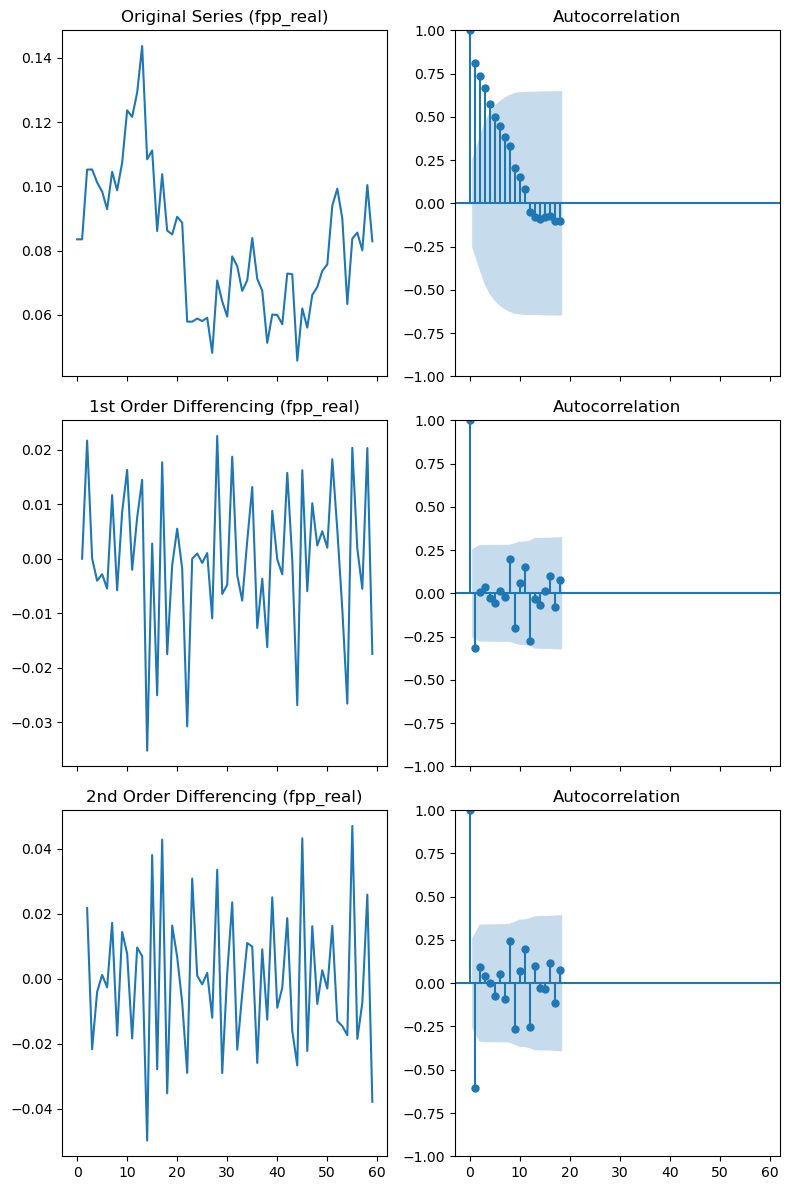

In [992]:
plt.rcParams.update({'figure.figsize':(6, 15), 'figure.dpi':100})  
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(8, 12))  

# Original Series and ACF for 'effective_real'
axes[0, 0].plot(df.fpp_real); axes[0, 0].set_title('Original Series (fpp_real)')
plot_acf(df.fpp_real, ax=axes[0, 1])

# 1st Order Differencing and ACF for 'effective_real'
axes[1, 0].plot(df.fpp_real.diff()); axes[1, 0].set_title('1st Order Differencing (fpp_real)')
plot_acf(df.fpp_real.diff().dropna(), ax=axes[1, 1])

# 2nd Order Differencing and ACF for 'effective_real'
axes[2, 0].plot(df.fpp_real.diff().diff()); axes[2, 0].set_title('2nd Order Differencing (fpp_real)')
plot_acf(df.fpp_real.diff().diff().dropna(), ax=axes[2, 1])

# Adjust layout
plt.tight_layout()


Taking a closer look, out PACF plot shows (PACF = measures the correlation between two variables, while also taking into account the values of other variables, measuring the correlation between a stationary time series and its own lagged values, while also adjusting for the presence of shorter lags). 

(0.0, 30.0)

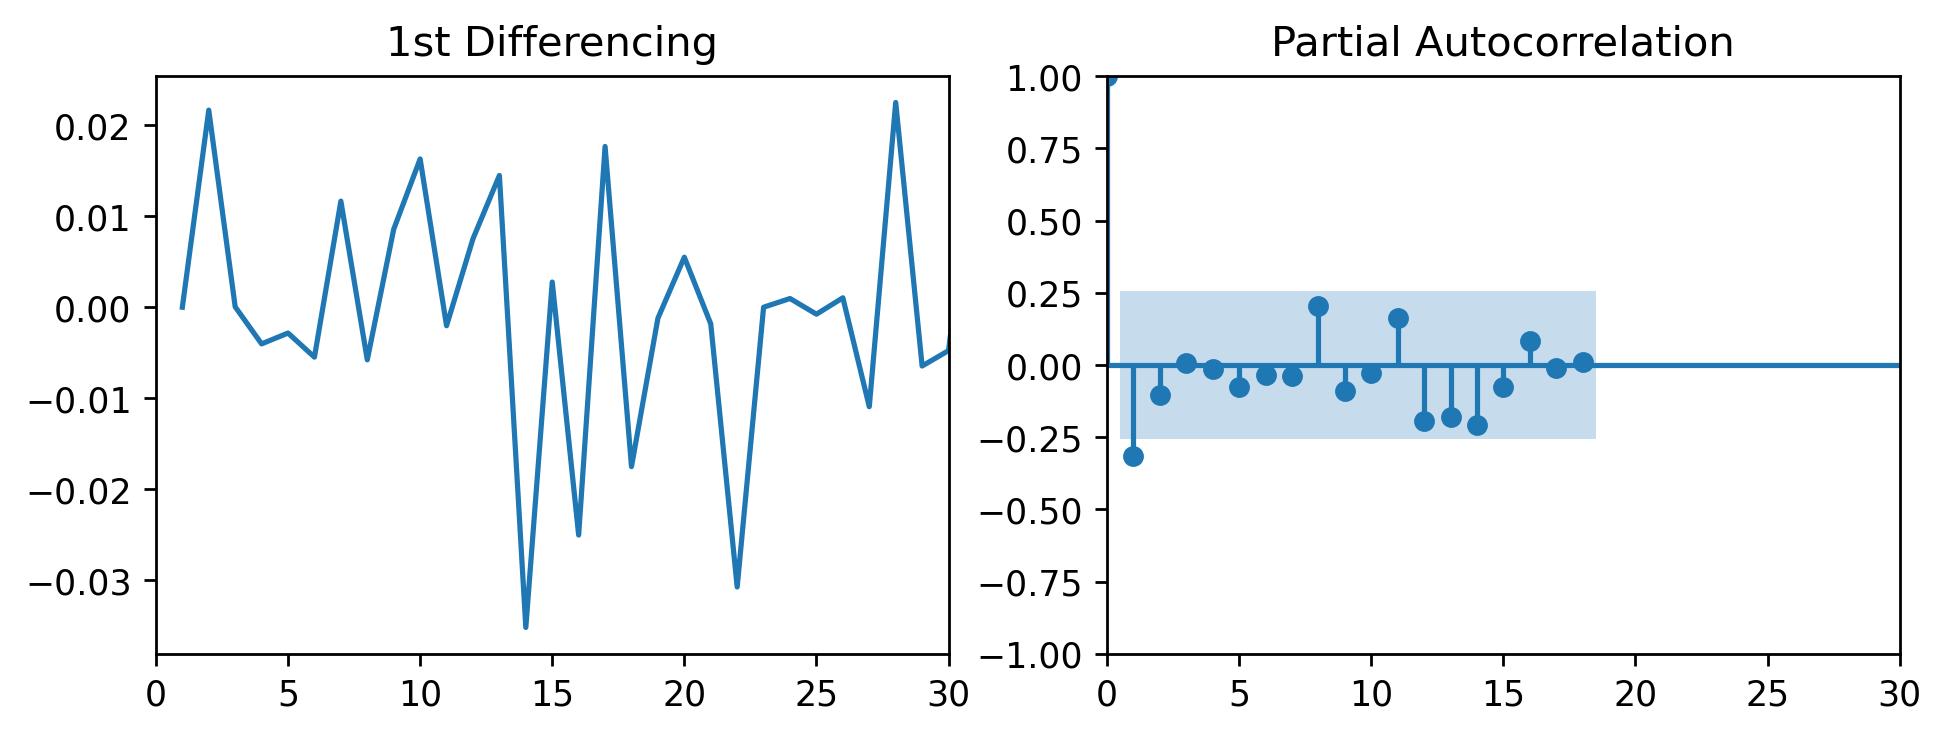

In [993]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':250})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.fpp_real.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.fpp_real.diff().dropna(), ax=axes[1])
plt.xlim(0, 30)  # X-axis range from 0 to 50
#PACF-> AR = order of the AR model = 1


The spike at lag 1 suggest thats an autoregressive model with order 1 (AR(1)) may be appropriate. This means the current value of the series is influenced by the previous value.

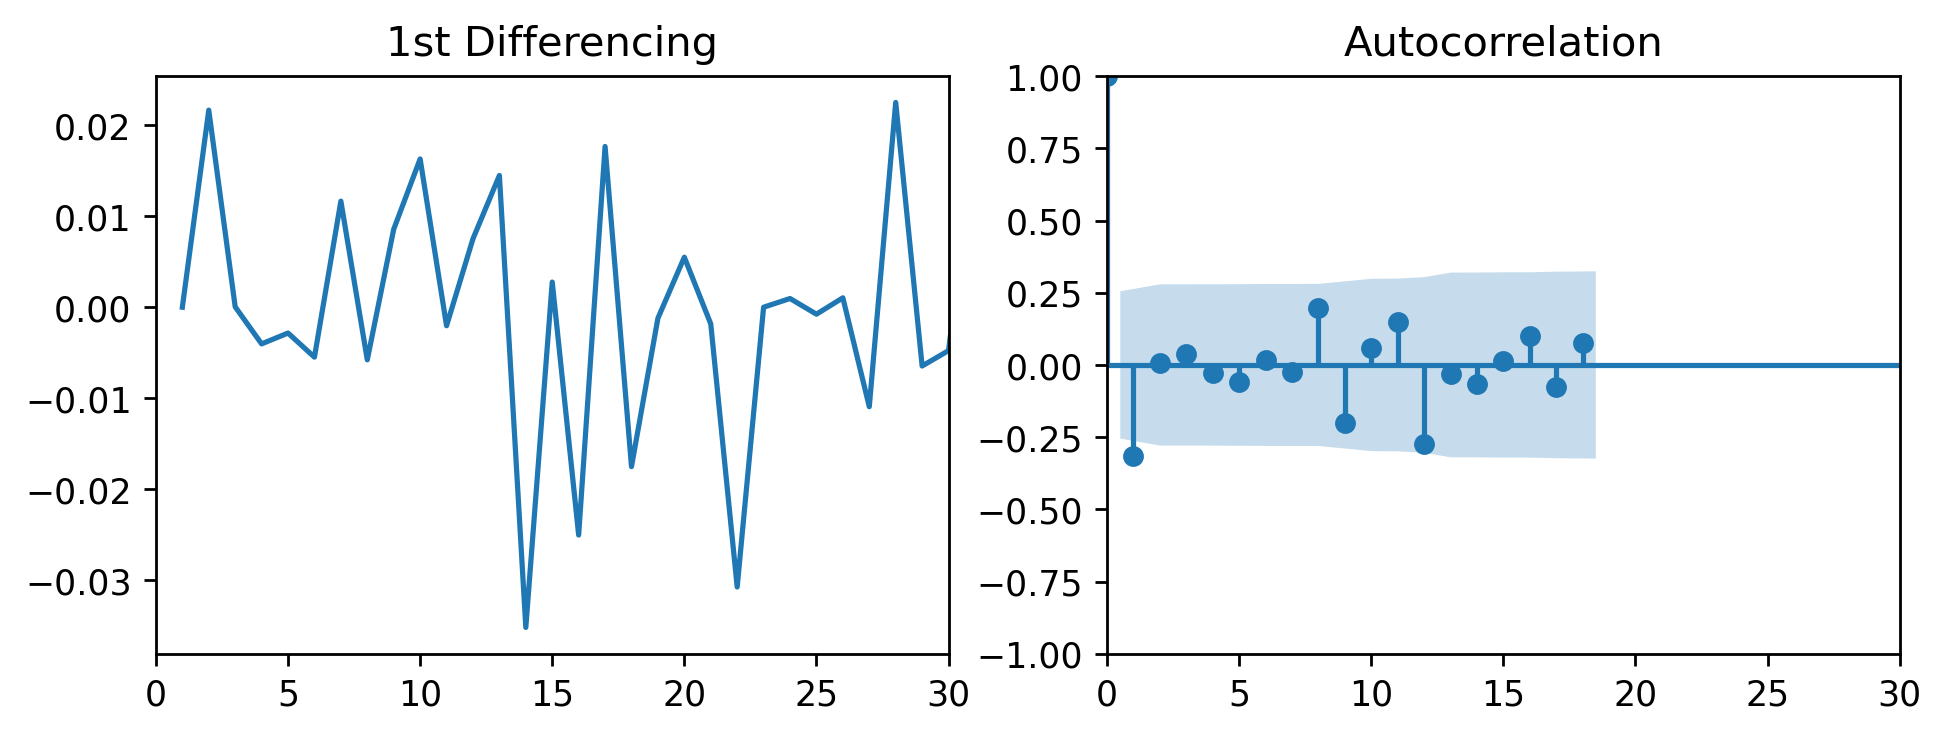

In [994]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.read_excel(file_path)
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':250})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.fpp_real.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.fpp_real.diff().dropna(), ax=axes[1])

#ACF shows that the MA model is of order 1
plt.xlim(0, 30)

plt.show()


The ACF plot shows most of the spikes except the first one at lag 1 are within the confidence intervals after first differencing. This suggests that the autocorrelations are not significant at higher lags. This can imply that the MA order might be MA(1) or MA(0), if there are no significant spikes beyond lag 1.


## Part 3: Computing Best Parameters
AIC/BIC (Akaike Information Criterion, Bayesian Information Criterion) are metrics to estimate model parameters. The lower the AIC or BIC, the better. Here, I am computing the AIC's and the BIC's of every possible combination to confirm the best model parameters. 

In [995]:
prices = df['fpp_real']
print(prices.tail())

p_values = [0, 1, 2]    # AR orders
d_values = [0, 1]       # I orders 
q_values = [0, 1, 2]    # MA orders
P_values = [0, 1, 2]    # Seasonal AR orders
D_values = [0, 1]       # Seasonal I orders
Q_values = [0, 1, 2]    # Seasonal MA orders
m_values = [4]         # Seasonal period 

results = []

# order_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m_values))

# for p, d, q, P, D, Q, m in order_combinations:
#     model = SARIMAX(prices, order=(p, d, q), seasonal_order=(P, D, Q, m))
#     model_fit = model.fit(disp=False)
    
#     results.append({
#         'p': p,
#         'd': d,
#         'q': q,
#         'P': P,
#         'D': D,
#         'Q': Q,
#         'm': m,
#         'AIC': model_fit.aic,
#         'BIC': model_fit.bic
#     })

# results_df = pd.DataFrame(results)
# results_df.to_csv('AIC_BIC_SARIMA.csv', index=False)


55    0.083752
56    0.085613
57    0.080087
58    0.100398
59    0.082901
Name: fpp_real, dtype: float64


In [996]:
min_aic = results_df['AIC'].min()
min_bic = results_df['BIC'].min()
print(min_aic)
print(min_bic)

-349.100768618026
-341.4145240401141


### The best fit parameters are (0, 1, 1)  (1, 0, 2, 4) for the SARIMA model
This means: AR = 0, indicates that no previous quarter's values are used in the prediction.
I = 1, indicates that one differencing transformation was needed to make the data stationary
MA = 1, indicates that 1 previous error values from the quarter before are used in the prediction

SAR = 1, indicates that values from the same season (quarter) from 1 previous year are used to help predict
Seasonal I = 0, indicates that seasonal differencing is not needed
SMA = 2, indicates that the model uses the errors (or residuals) from the same season in the previous period, incorporating up to the last two seasonal lags to predict
S = 4, this is because we are using resolution of quarters (quarterly data )




## Part 4: SARIMA

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.51382D+00    |proj g|=  3.32088D-01

At iterate    5    f= -2.51564D+00    |proj g|=  4.27623D+00

At iterate   10    f= -2.52053D+00    |proj g|=  8.95673D-02

At iterate   15    f= -2.52418D+00    |proj g|=  4.51972D+00

At iterate   20    f= -2.55097D+00    |proj g|=  1.46025D+00

At iterate   25    f= -2.55159D+00    |proj g|=  1.17227D+00

At iterate   30    f= -2.55898D+00    |proj g|=  1.19015D-01

At iterate   35    f= -2.55898D+00    |proj g|=  9.95053D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/3903962694.py:37: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_index = pd.date_range(start=data.index[-1], periods=n_steps+1, freq='Q')[1:]  # Generate future dates


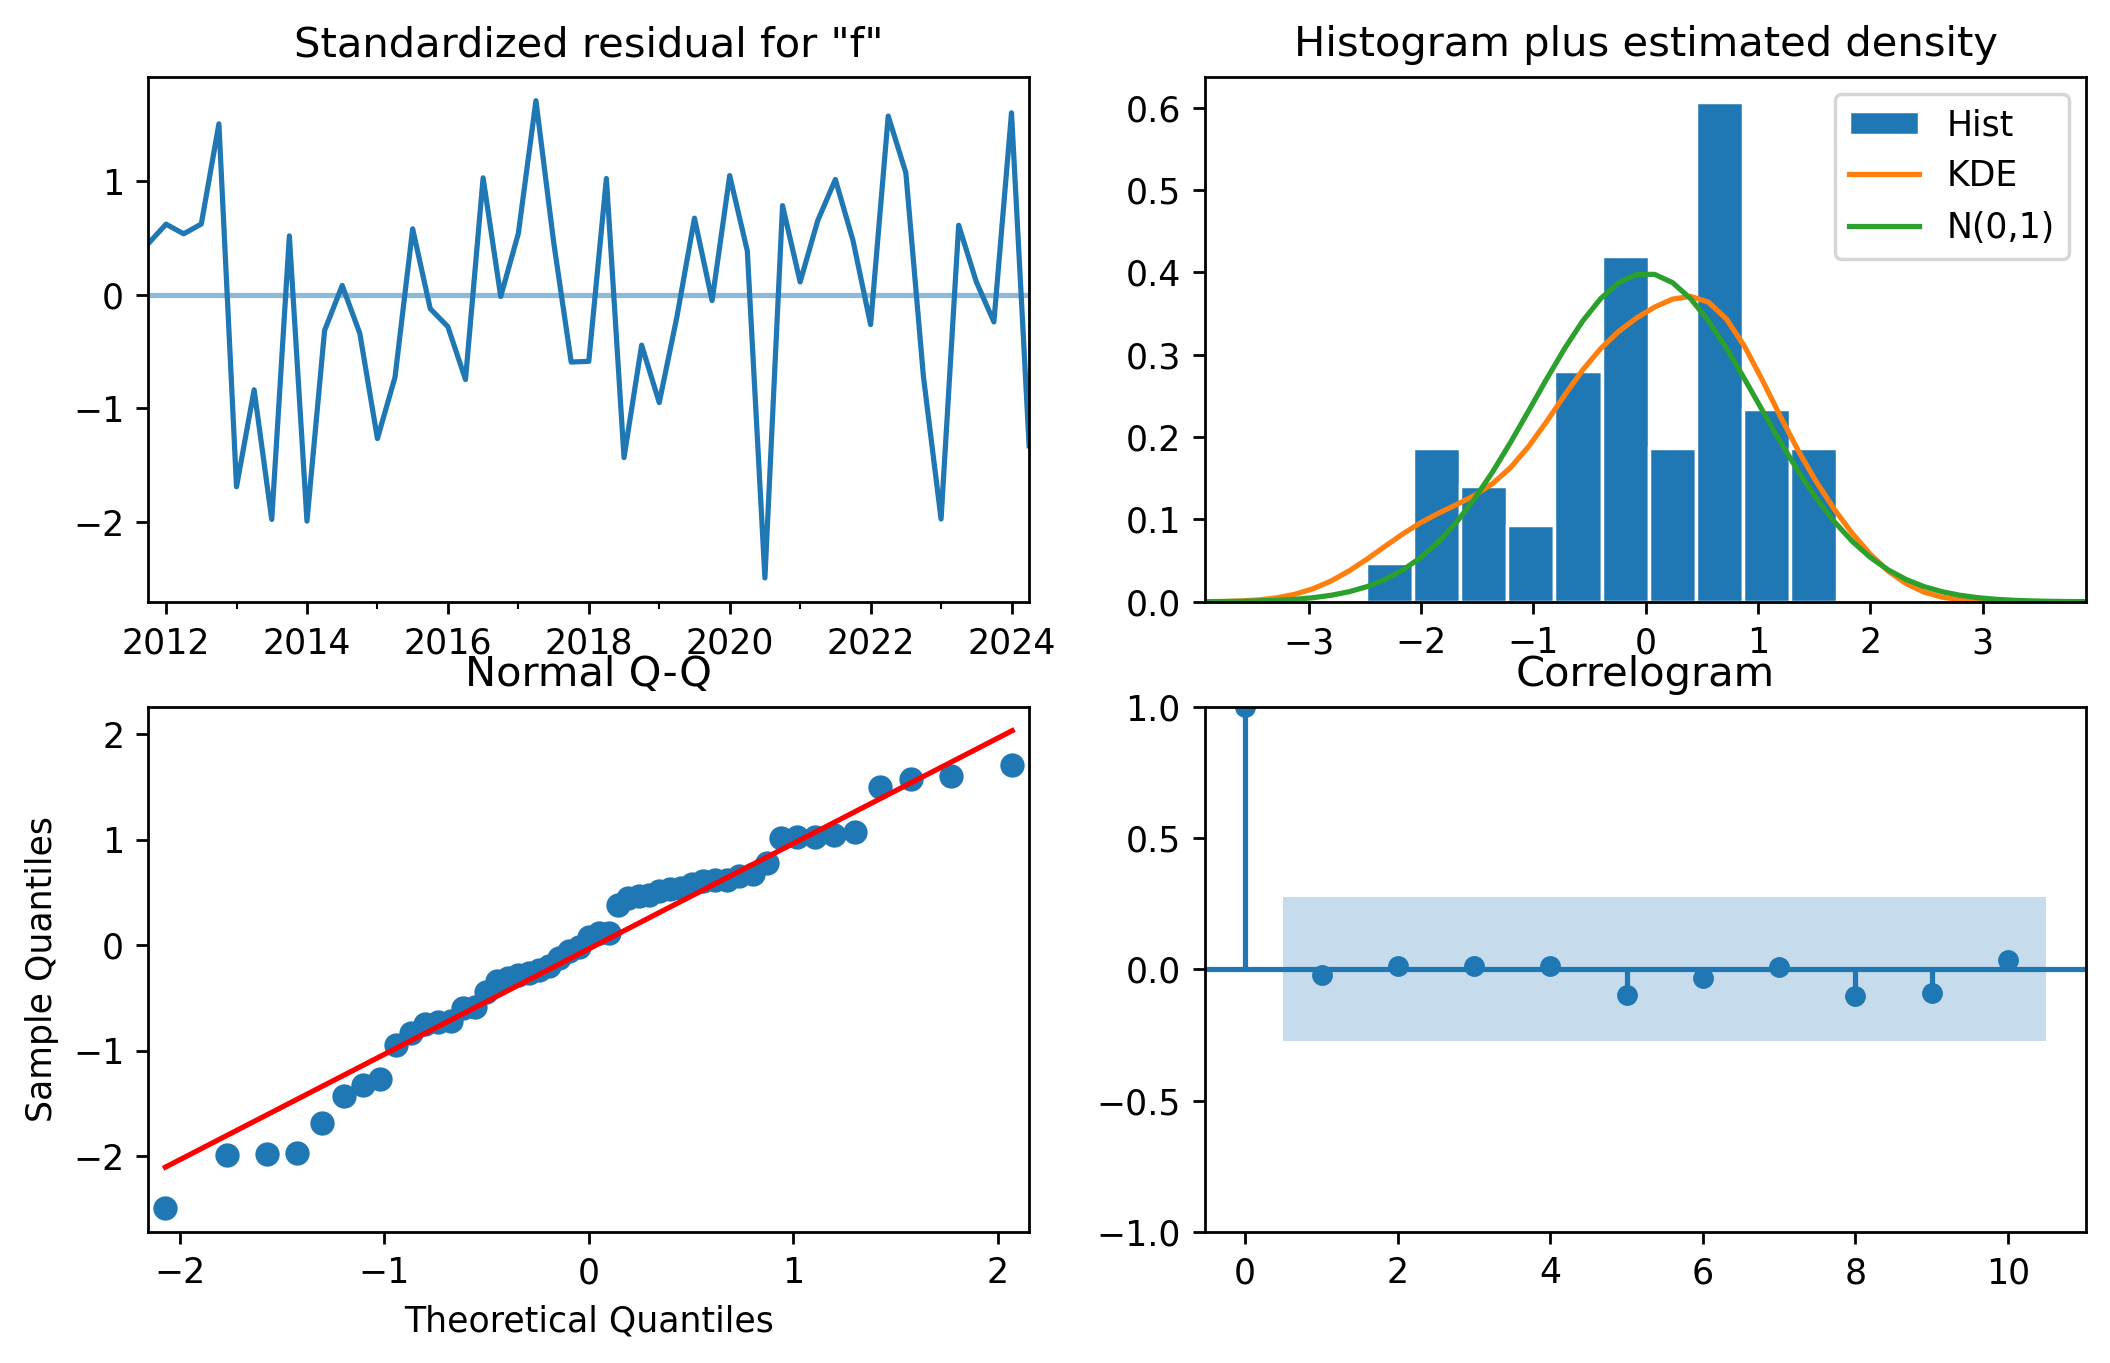

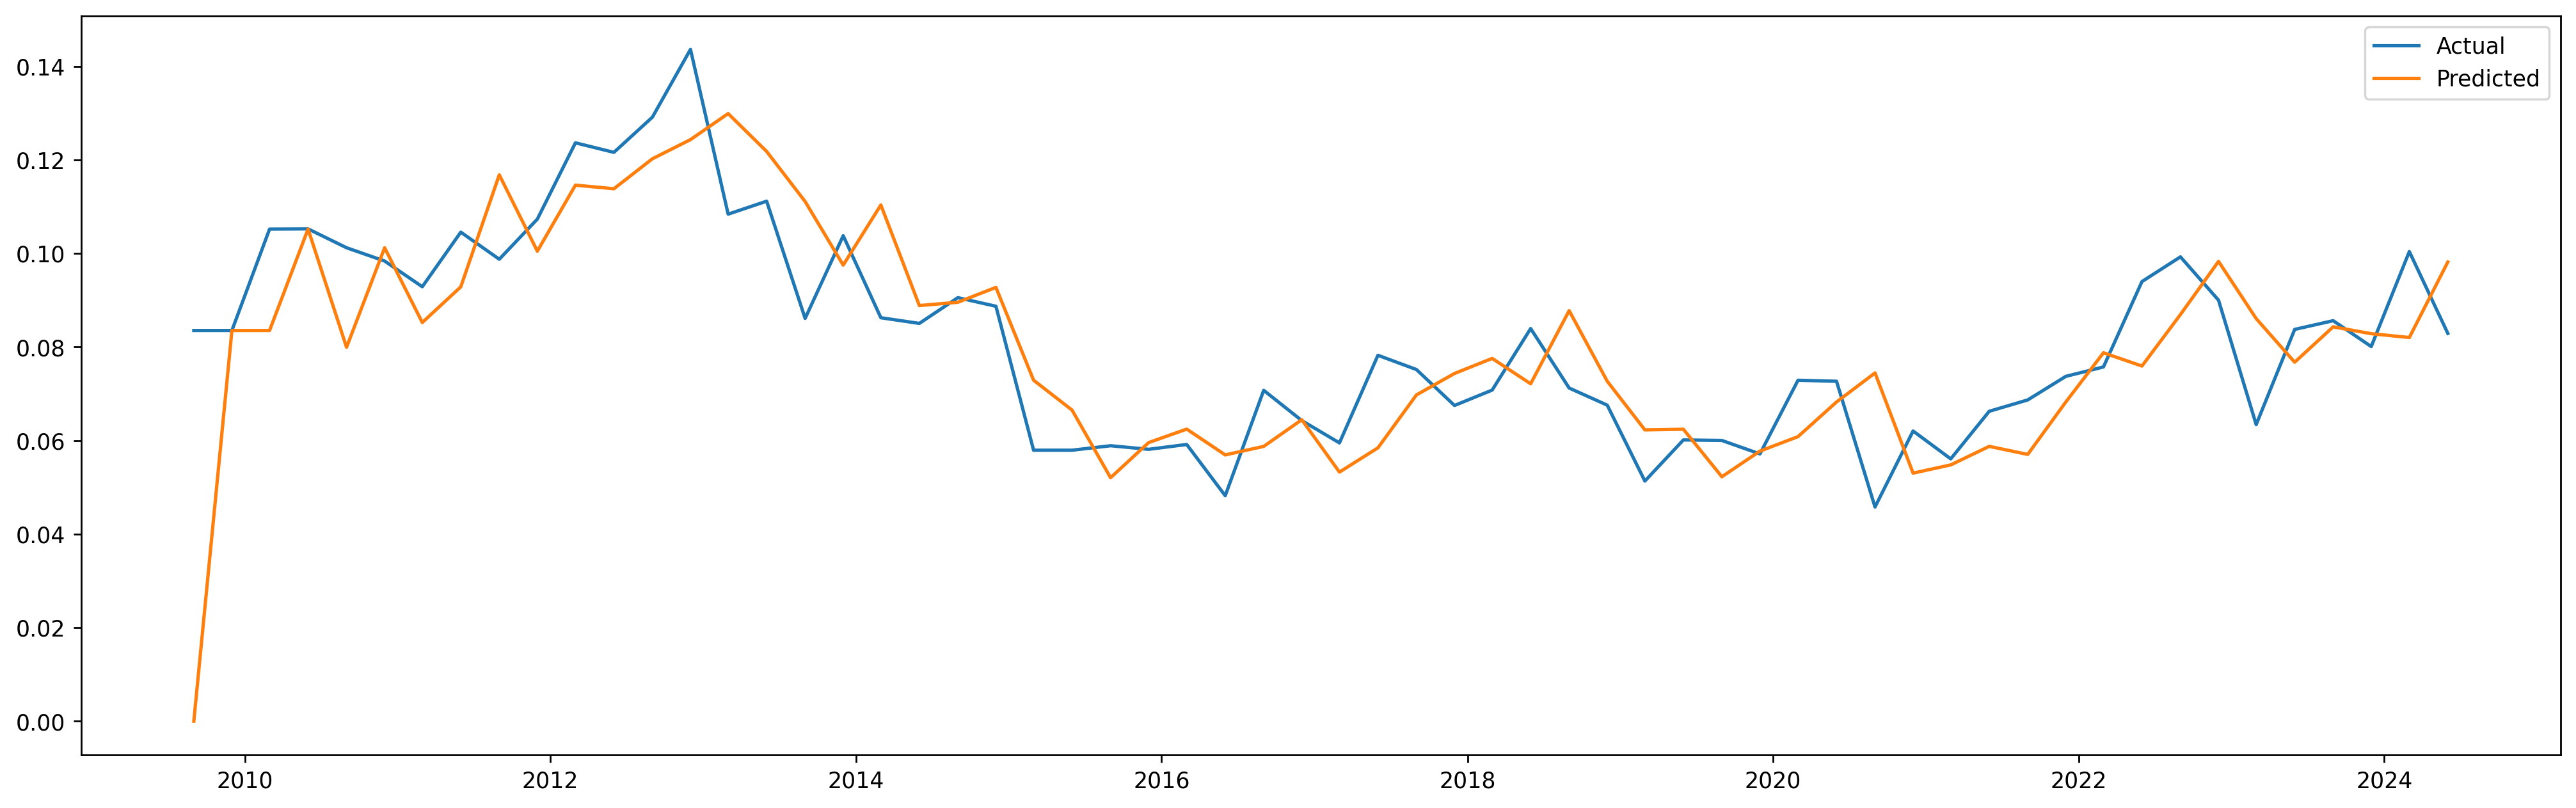

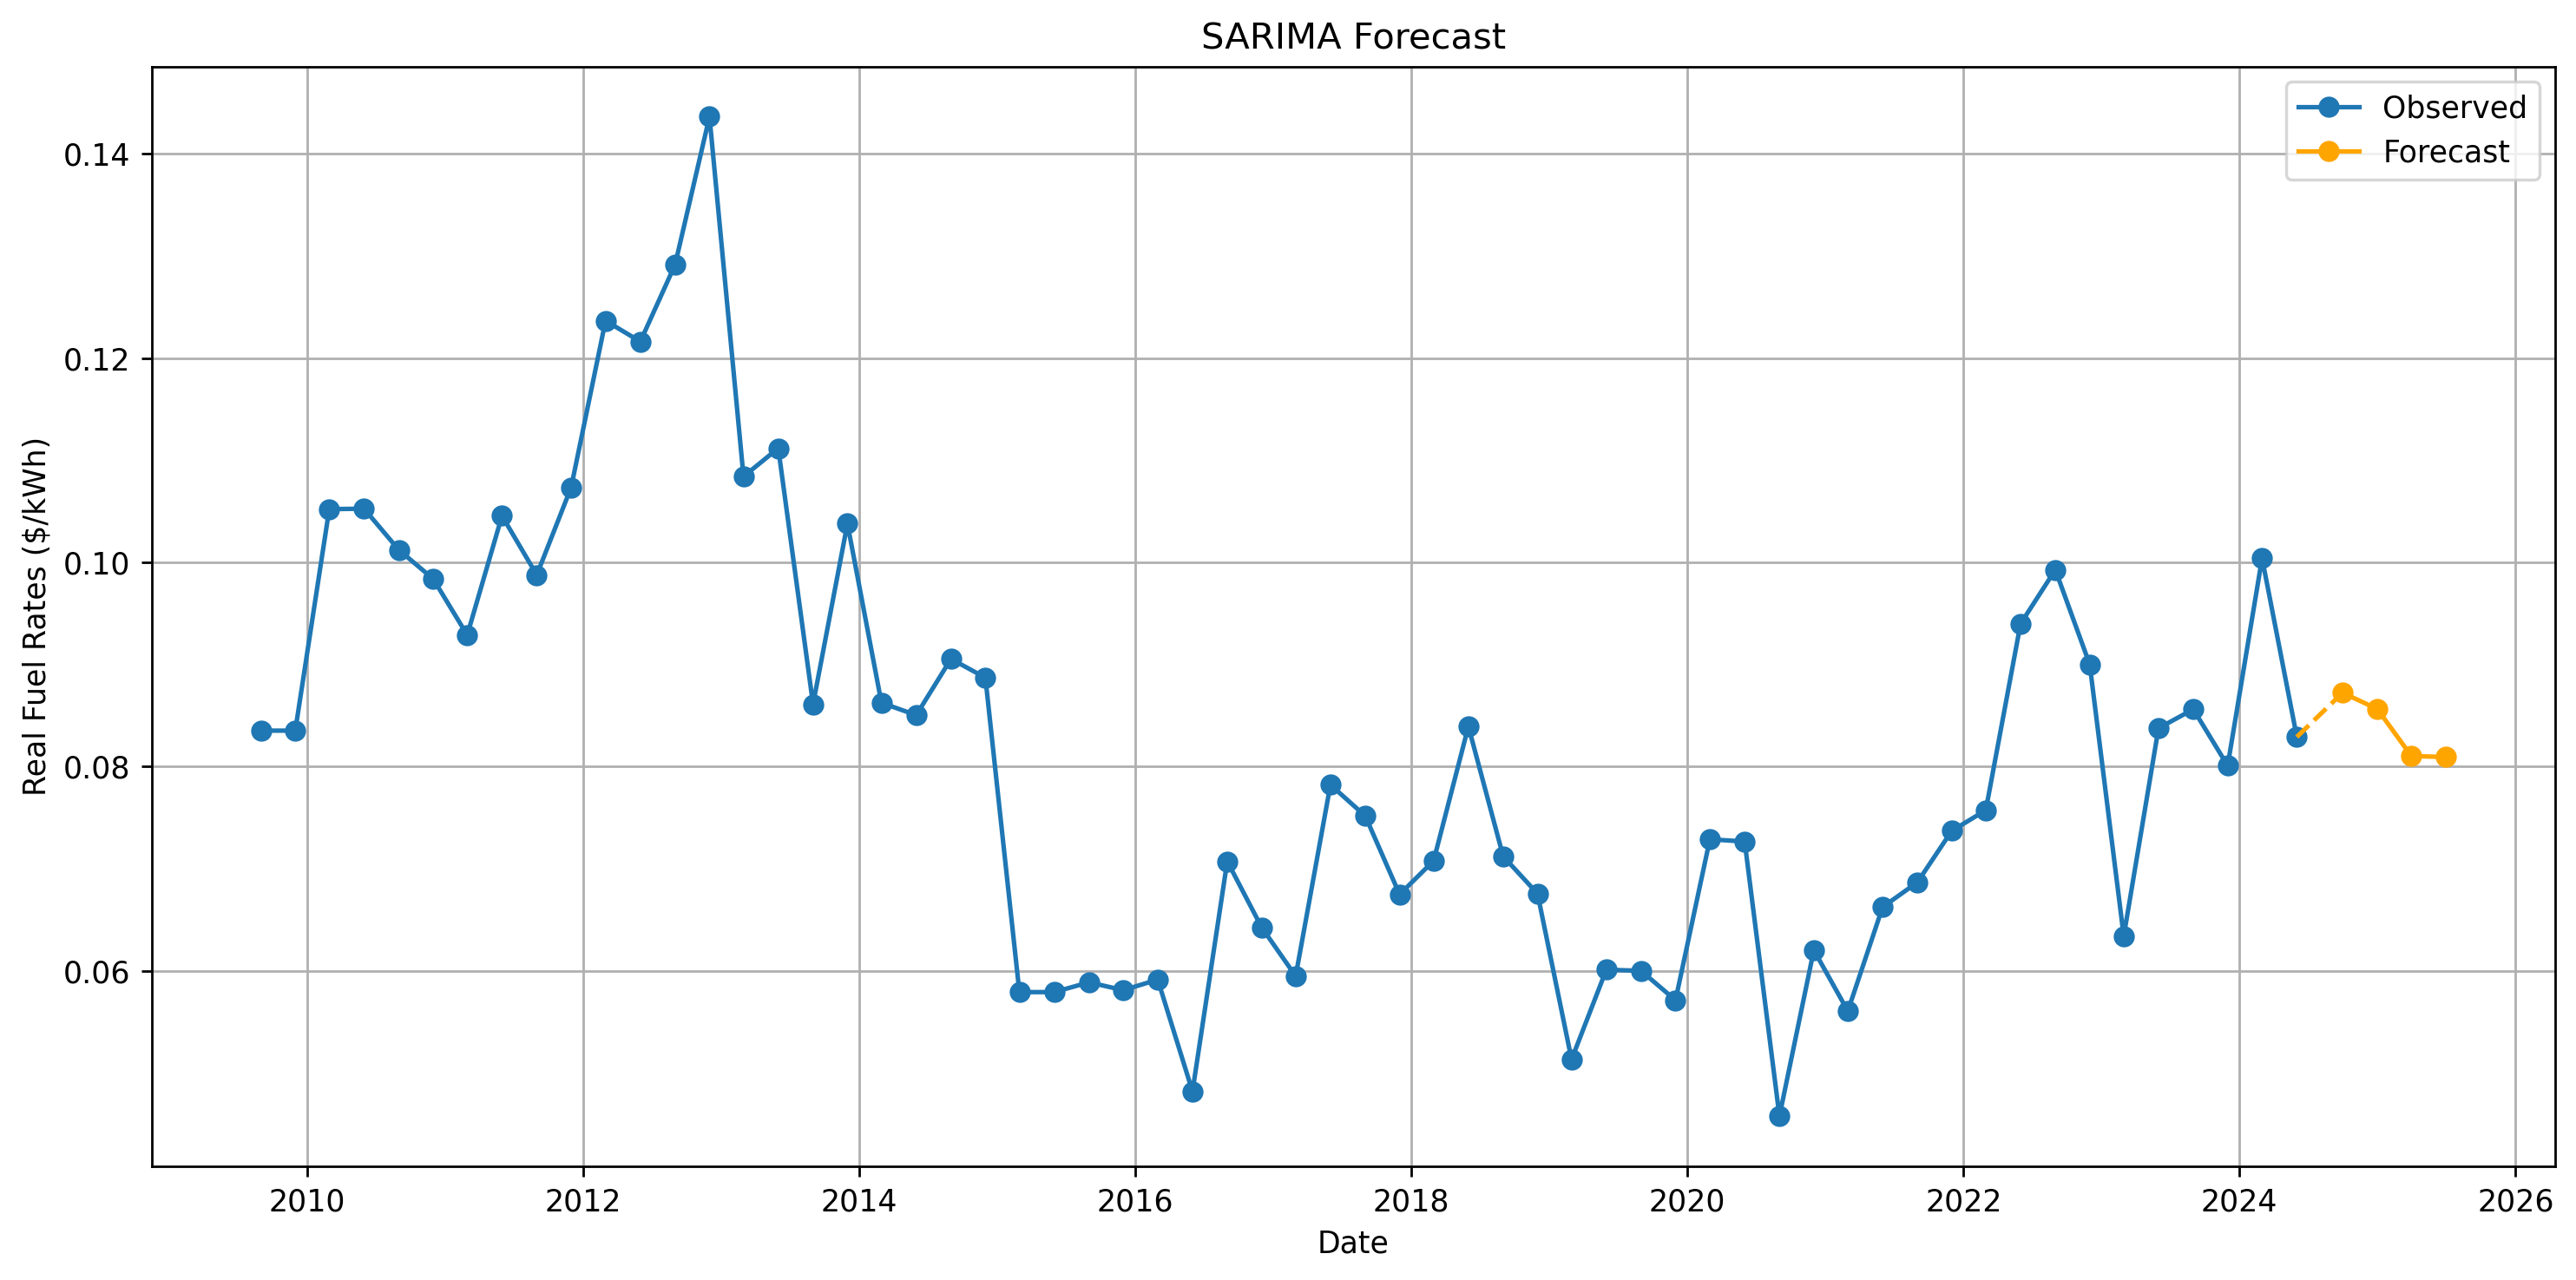

Forecasted Real Values
2024-09-01    0.087229
2024-12-01    0.085637
2025-03-01    0.081035
2025-06-01    0.080939
Freq: QS-DEC, Name: predicted_mean, dtype: float64
Nominal Forecast Values
2024-09-01    0.144478
2024-12-01    0.141842
2025-03-01    0.134220
2025-06-01    0.134060
Freq: QS-DEC, Name: predicted_mean, dtype: float64
Nominal Effective Rates Forecast
0.28494819506891855
0.28231198543657116
0.2746895664455991
0.2745299430775797


/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/3903962694.py:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_series[i] = (forecast_series[i]*last_cpi)/100
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/3903962694.py:72: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  forecast_series[i] = (forecast_series[i]*last_cpi)/100
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/3903962694.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFram

In [997]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMAResults 

import pandas as pd
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMAResults 


data = pd.read_excel(file_path, index_col='date', parse_dates=True)

model = SARIMAX(data['fpp_real'],
                order=(0, 1, 1),
                seasonal_order=(2, 0, 1, 4),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()

print(results.summary())

predicted=results.predict();predicted

# Plot diagnostics
results.plot_diagnostics(figsize=(10, 6))
plt.figure(figsize=(20,6))
plt.plot(data['fpp_real'],label='Actual')
plt.plot(predicted,label='Predicted')
plt.legend()

## include constant of the model
#forecasting
n_steps = 4  # number of steps to forecast
forecast = results.get_forecast(steps=n_steps)
forecast_index = pd.date_range(start=data.index[-1], periods=n_steps+1, freq='Q')[1:]  # Generate future dates
forecast_series = forecast.predicted_mean  # Series of forecasted values


fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(data.index, data['fpp_real'], label='Observed', marker='o')

ax.plot(forecast_index, forecast_series, color='orange', label='Forecast', marker='o')

# Extend observed data line to forecast start
observed_end = data.index[-1]
forecast_start = forecast_index[0]
observed_value_end = data['fpp_real'].iloc[-1]
forecast_value_start = forecast_series.iloc[0]
ax.plot([observed_end, forecast_start], [observed_value_end, forecast_value_start], color='orange', linestyle='--')

ax.set_title('SARIMA Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Real Fuel Rates ($/kWh)')
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

#print forecasted values
print("Forecasted Real Values")
print(forecast_series)

utility_last = data["utility_real"].iloc[-1]

#adjust for CPi
last_cpi = data['CPI_new'].iloc[-1]
for i in range(len(forecast_series)):
    forecast_series[i] = (forecast_series[i]*last_cpi)/100

print("Nominal Forecast Values")
print(forecast_series)

print("Nominal Effective Rates Forecast")
utility_add = (utility_last*last_cpi)/100

for i in range(len(forecast_series)):
    print(forecast_series[i] + utility_add)




The SARIMA model predicts (in nominal values): 0.287229, 0.283060, 0.263805, 0.278897 for the upcoming year's effective rates

In [998]:
#validate the model
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

# Calculate RMSE
rmse = sqrt(mean_squared_error(data['fpp_real'], predicted))
print(f'RMSE: {rmse}')
#calculate MAE
mae = np.mean(np.abs(data['fpp_real'] - predicted))
print(f'MAE: {mae}')


RMSE: 0.016158849117902958
MAE: 0.011004673328050756


The RMSE is 0.0163, meaning that, on average, the difference between the predicted effective rate and the actual value is 0.0163 cents of the effective rate, which is pretty high considering the effective rate this quarter is only $0.30.

The MAE is 0.011, meaning that the average absolute difference between the predicted effective rates and the actual effective rates is 0.01 cents. 

The SARIMA model predicts (in nominal values): 0.293234, 0.300906, 0.287456, 0.297921 for the upcoming year


### Part 5: SARIMAX with all the exogeous variables



In [999]:
prices = data['fpp_real']

p_values = [0, 1, 2]    # AR orders
d_values = [0, 1]       # I orders 
q_values = [0, 1, 2]    # MA orders
P_values = [0, 1, 2]    # Seasonal AR orders
D_values = [0, 1]       # Seasonal I orders
Q_values = [0, 1, 2]    # Seasonal MA orders
m_values = [4]         # Seasonal period 

results = []

#divide wind by 1000

data['wnd'] = data['wnd']/1000

exog = pd.DataFrame({
    'net_gen': data['net_gen'],
    'nat_gas_prices': data['nat_gas_real'],
    'crude_prod': data['crude_oil_prod'], 
    'crude_prices_real': data['crude_prices_real'],
    'coal': data['coal'],
    'wind': data['wnd'],
    'oil': data['oil']
})

# order_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m_values))

# for p, d, q, P, D, Q, m in order_combinations:
#     model = SARIMAX(prices, order=(p, d, q), seasonal_order=(P, D, Q, m), exog=exog)
#     model_fit = model.fit(disp=False)
    
#     results.append({
#         'p': p,
#         'd': d,
#         'q': q,
#         'P': P,
#         'D': D,
#         'Q': Q,
#         'm': m,
#         'AIC': model_fit.aic,
#         'BIC': model_fit.bic
#     })

# results_df = pd.DataFrame(results)
# results_df.to_csv('AIC_BIC_Exog.csv', index=False)


In [1000]:
# min_aic = results_df['AIC'].min()
# print(min_aic)

/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.61764D+00    |proj g|=  3.55033D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12      1     21      1     0     0   3.550D+07  -2.618D+00
  F =  -2.6176431490457777     

ABNORMAL_TERMINATION_IN_LNSRCH                              


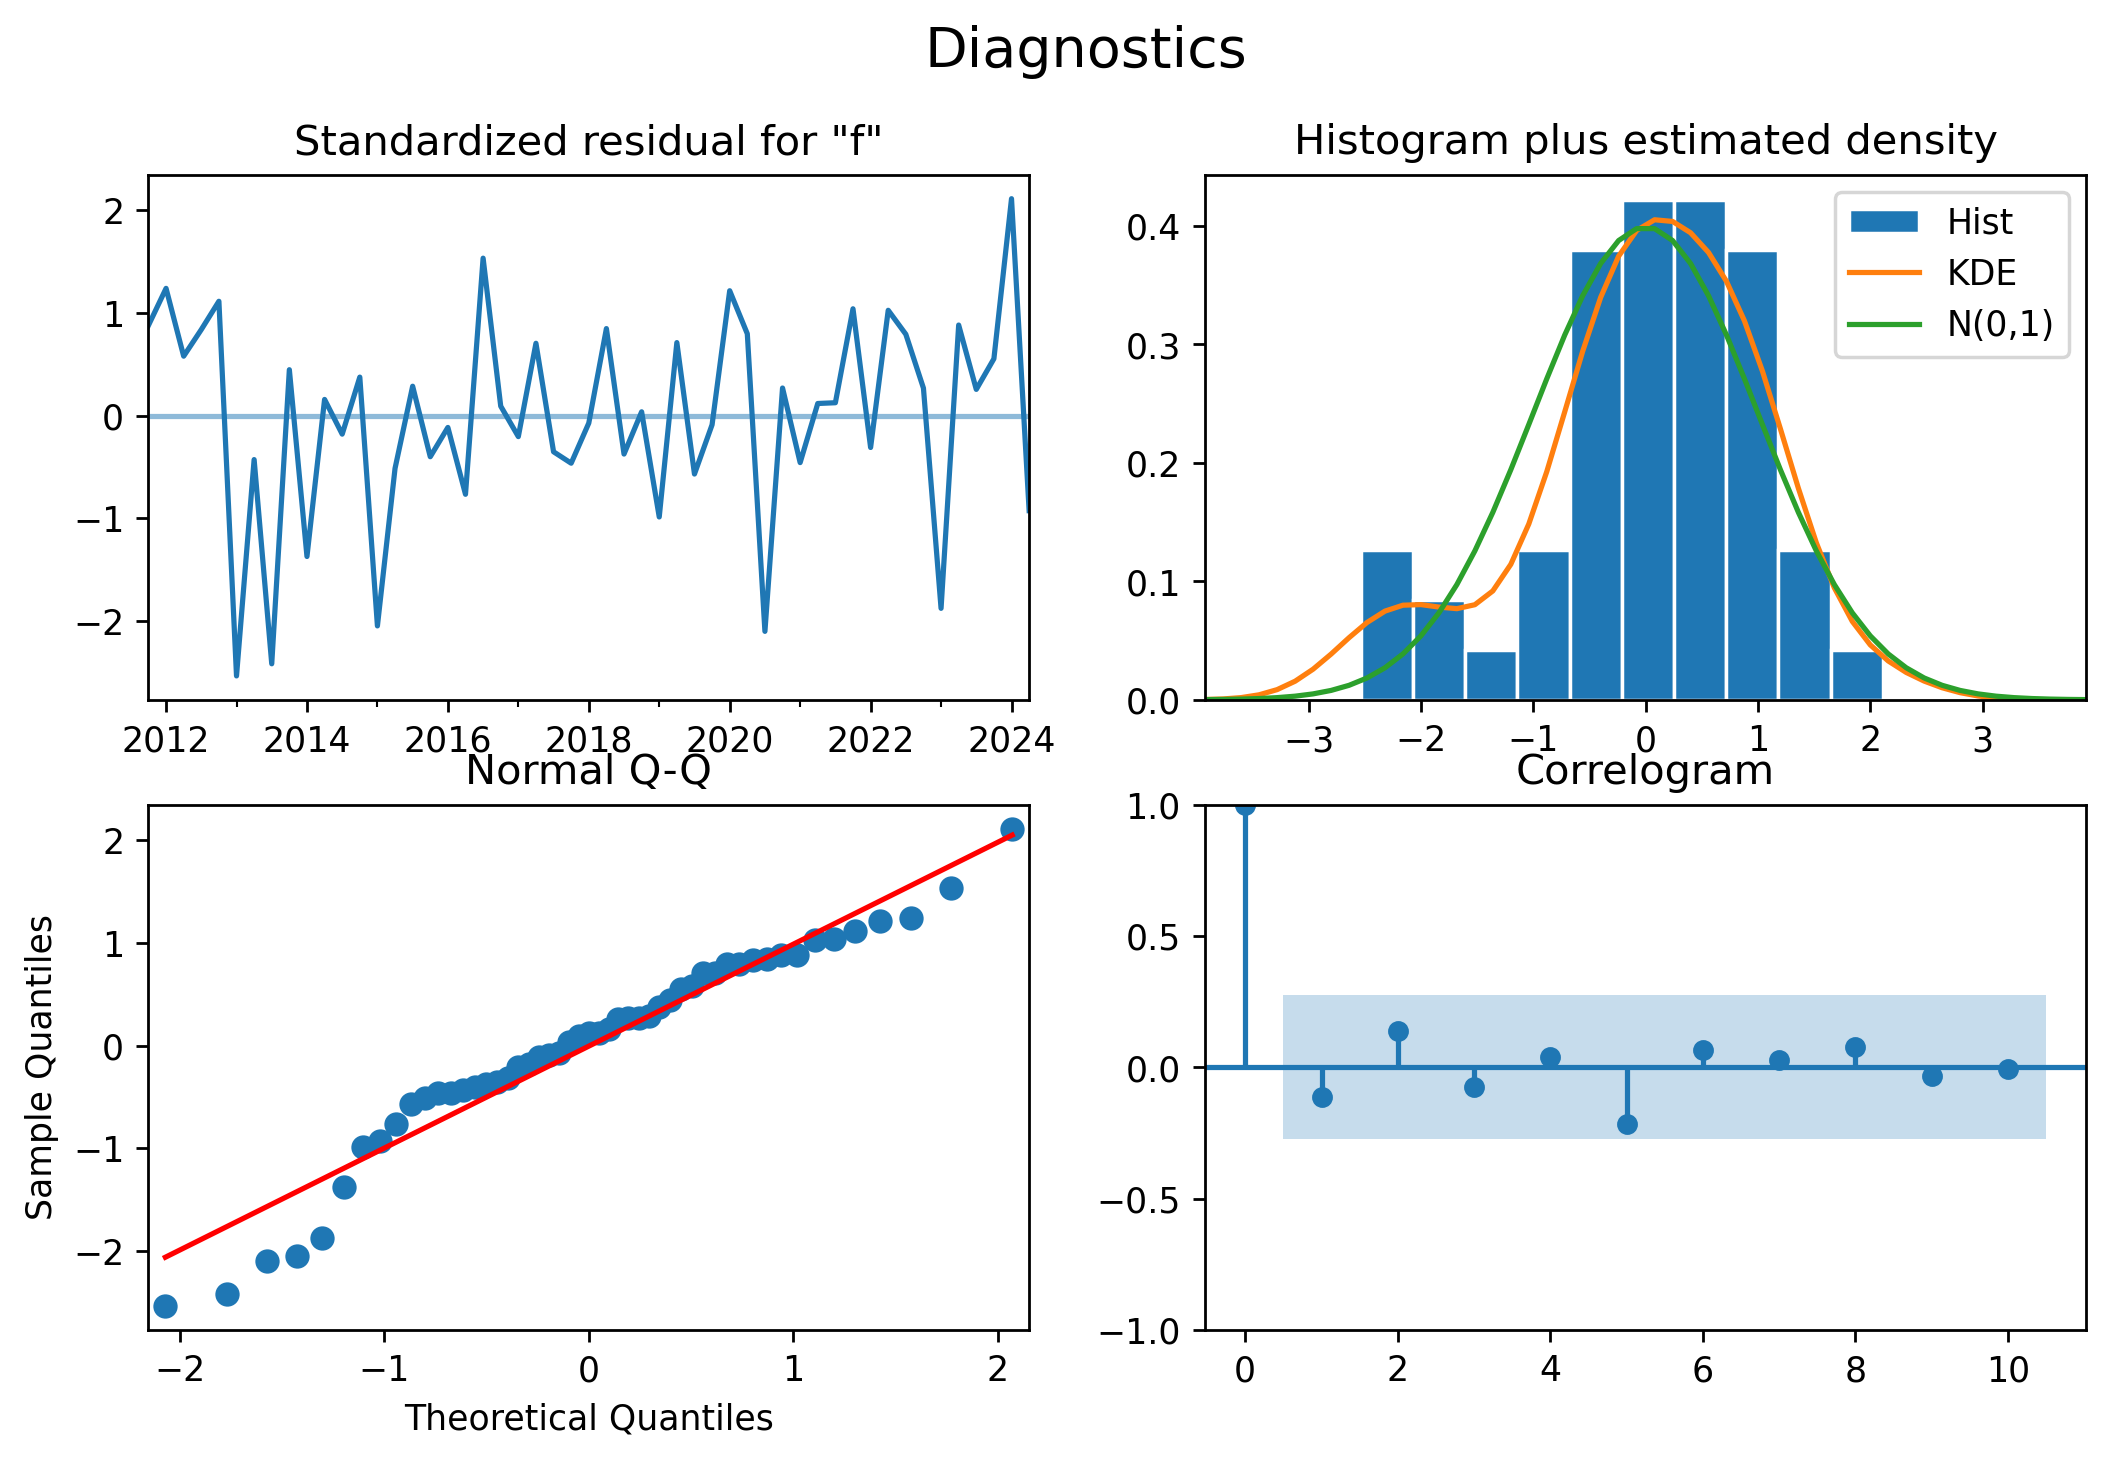

/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/3540250142.py:39: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start=data.index[-1], periods=5, freq='Q')[1:]


Forecasted Dates:
DatetimeIndex(['2024-09-30', '2024-12-31', '2025-03-31', '2025-06-30'], dtype='datetime64[ns]', freq='QE-DEC')

Forecasted Values:
2024-09-30    0.094811
2024-12-31    0.093962
2025-03-31    0.089483
2025-06-30    0.093697
Freq: QE-DEC, Name: predicted_mean, dtype: float64


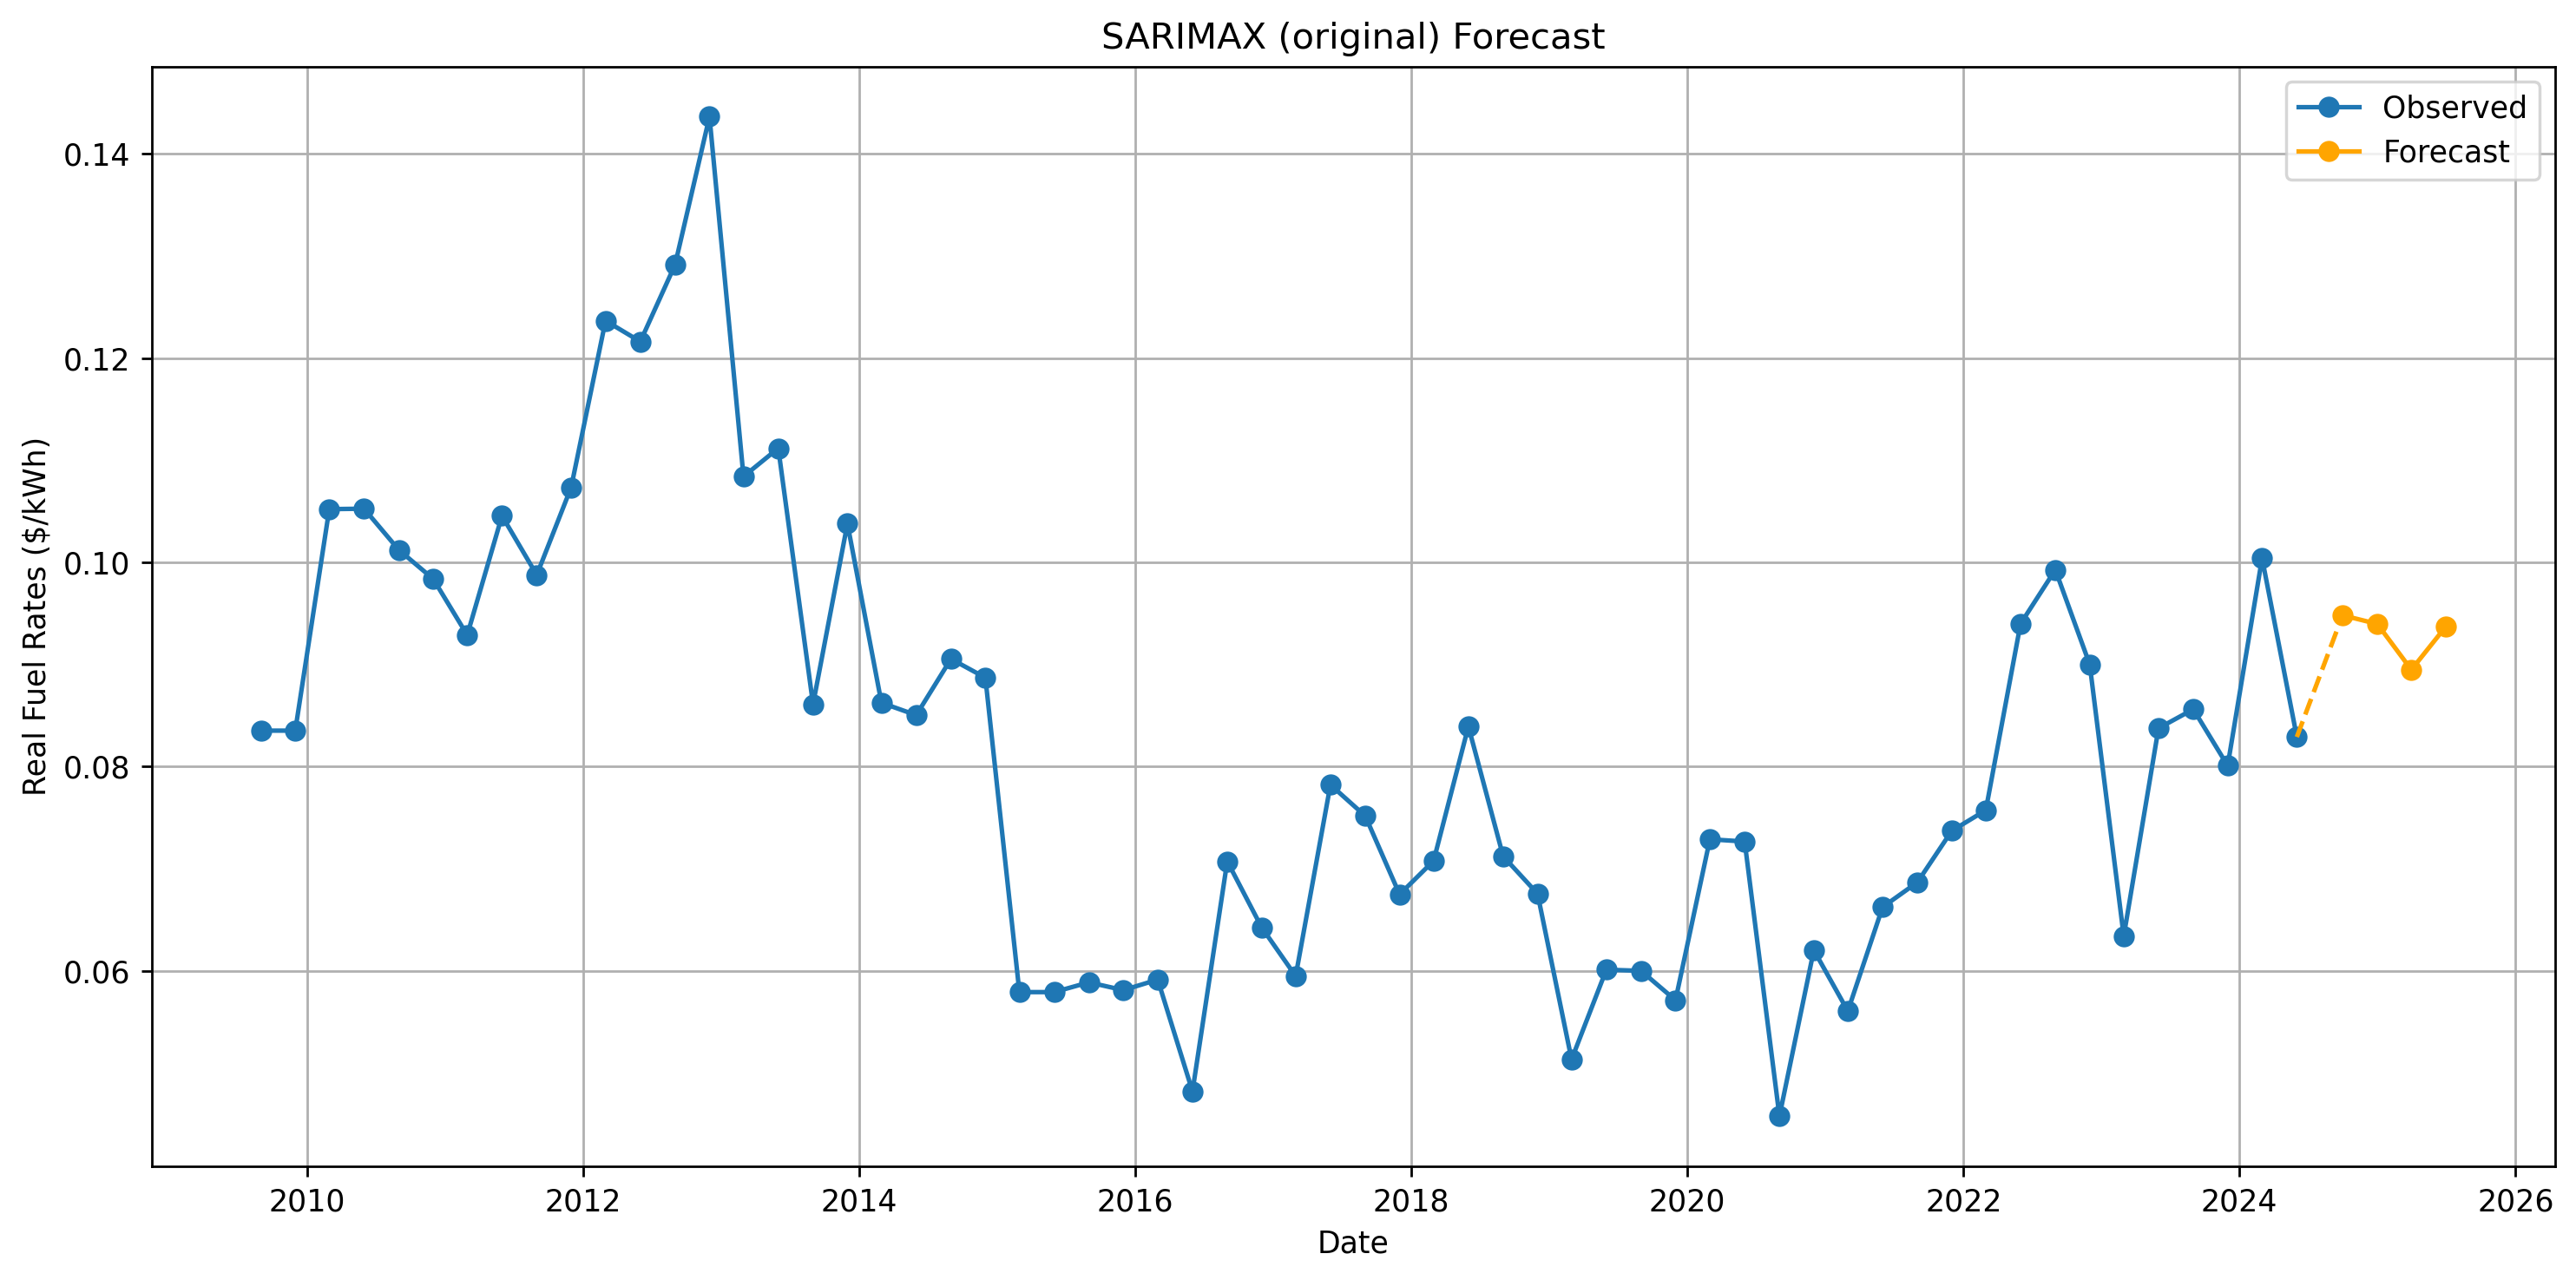

/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/3540250142.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_series[i] = (forecast_series[i]*last_cpi)/100
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/3540250142.py:106: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  forecast_series[i] = (forecast_series[i]*last_cpi)/100
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/3540250142.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

Nominal Forecast Values
2024-09-30    0.157036
2024-12-31    0.155630
2025-03-31    0.148212
2025-06-30    0.155192
Freq: QE-DEC, Name: predicted_mean, dtype: float64
Nominal Effective Rates Forecast
0.2975062926250239
0.296100139045563
0.28868219006403556
0.2956621459277675


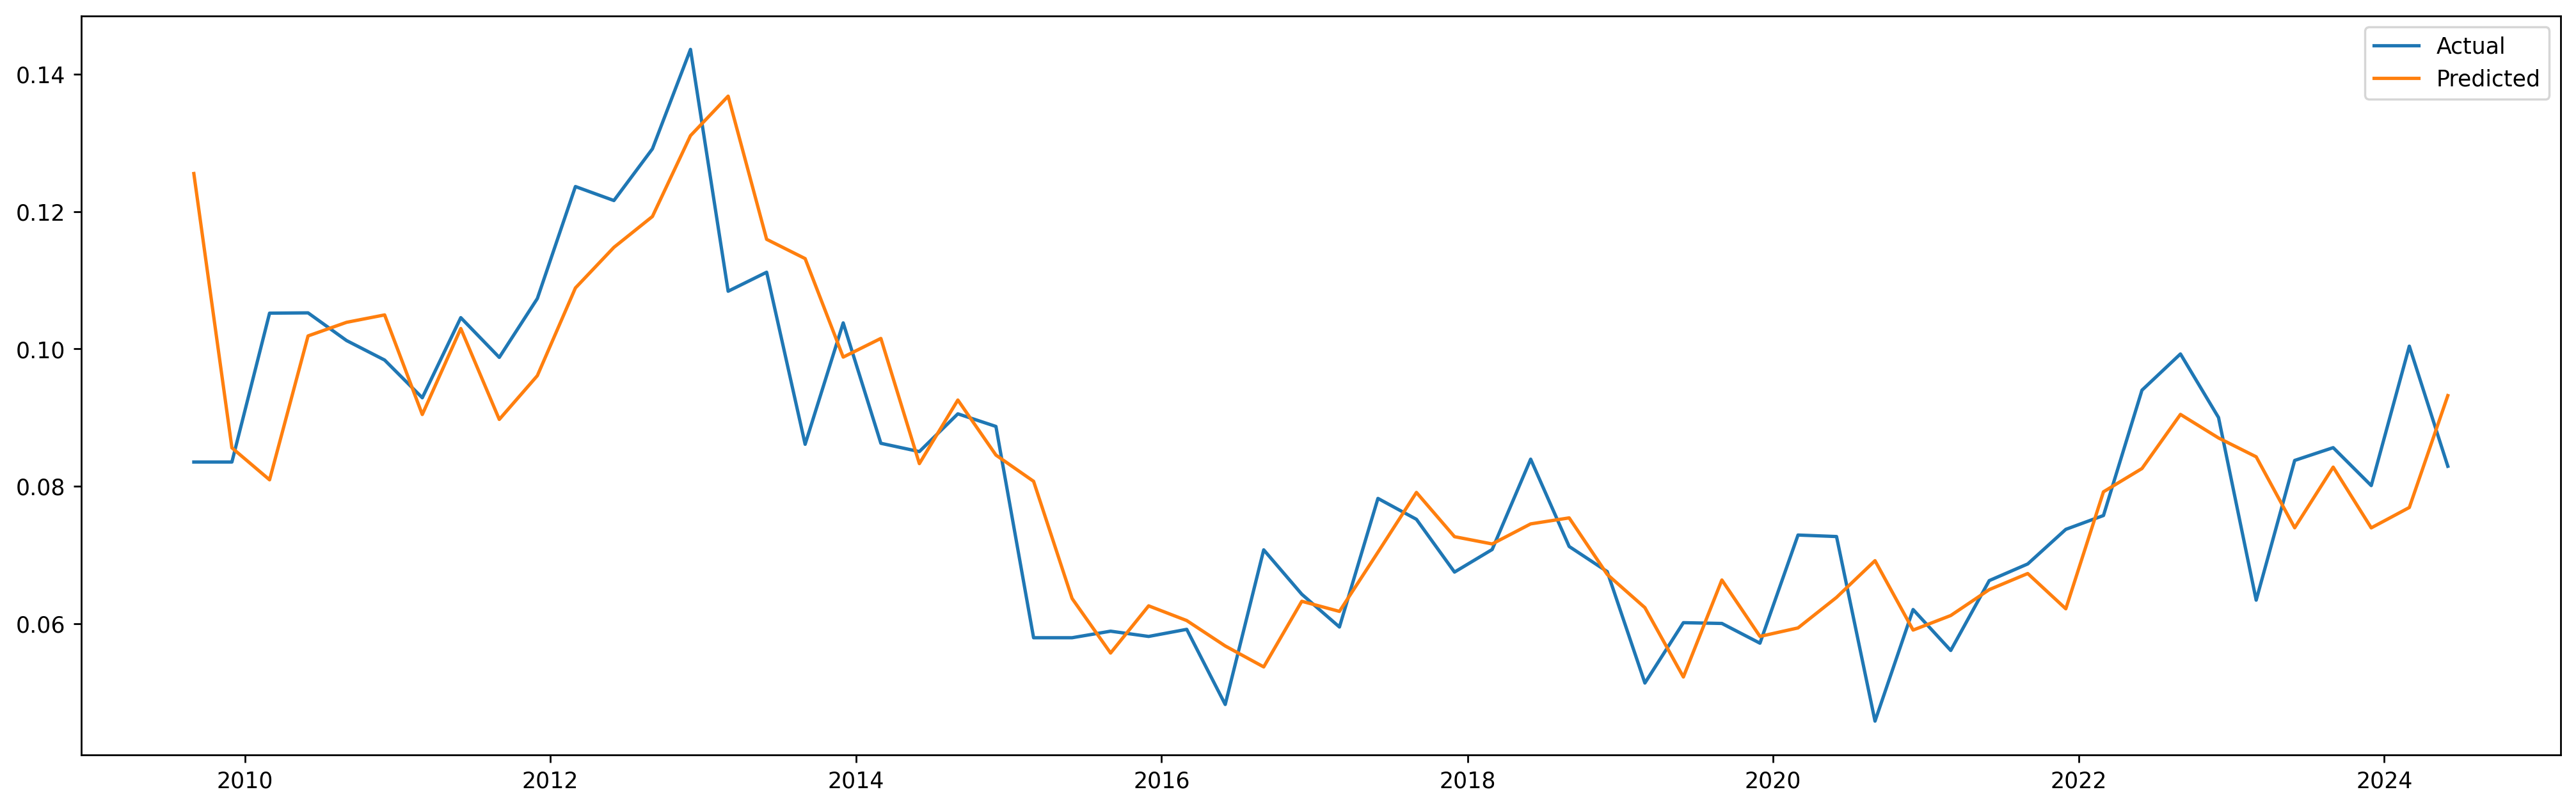

In [1007]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define exogenous variables
exog = pd.DataFrame({
    'net_gen': data['net_gen'],
    'nat_gas_prices': data['nat_gas_real'],
    'crude_prod': data['crude_oil_prod'], 
    'crude_prices_real': data['crude_prices_real'],
    'coal': data['coal'],
    'wind': data['wnd'],
    'oil': data['oil']
})

# Fit the SARIMAX model using the scaled exogenous variables
model_sarimax = SARIMAX(
    endog=data['fpp_real'],
    exog=exog,
    order=(0, 1, 1),
    trend = [0,0],
    seasonal_order=(2, 0, 1, 4),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model_sarimax.fit()

#plot diagnostics
results.plot_diagnostics(figsize=(10, 6))
plt.suptitle('Diagnostics', fontsize=16)
plt.show()

# Generate in-sample predictions
predicted = results.predict(start=0, end=len(data)-1, exog=exog)

# Prepare future exogenous data
future_dates = pd.date_range(start=data.index[-1], periods=5, freq='Q')[1:]

# Assuming window_size and n_steps are defined
window_size = 4  # Example window size
n_steps = 4  # Number of steps to forecast

future_exog = {
    'net_gen': np.mean(data['net_gen'].values[-window_size:]) * np.ones(n_steps),
    'nat_gas_prices': np.mean(data['nat_gas_real'].values[-window_size:]*1.1) * np.ones(n_steps), ##based on henry hub projected increase, a conservative estimate, 10% increase
    'crude_prod': np.mean(data['crude_oil_prod'].values[-window_size:]) * np.ones(n_steps), 
    'crude_prices_real': np.mean(data['crude_prices_real'].values[-window_size:]*1.059) * np.ones(n_steps),#based on henry hub projected increase in crude oil prices, 0.059% increase
    'coal': np.mean(data['coal'].values[-window_size:]) * np.ones(n_steps),
    'wind': np.mean(data['wnd'].values[-window_size:]) * np.ones(n_steps),
    'oil': np.mean(data['oil'].values[-window_size:]) * np.ones(n_steps)

}
future_exog_df = pd.DataFrame(future_exog, index=future_dates)

# Forecasting with the SARIMAX model
forecast = results.get_forecast(steps=n_steps, exog=future_exog_df)
forecast_index = future_dates
forecast_series = forecast.predicted_mean

# Assign the forecast index to the forecast series
forecast_series.index = forecast_index

# Print the forecasted values
print("Forecasted Dates:")
print(forecast_index)

print("\nForecasted Values:")
print(forecast_series)

# Plotting the forecast
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(data.index, data['fpp_real'], label='Observed', marker='o')
ax.plot(forecast_index, forecast_series, color='orange', label='Forecast', marker='o')

# Extend observed data line to forecast start
observed_end = data.index[-1]
forecast_start = forecast_index[0]
observed_value_end = data['fpp_real'].iloc[-1]
forecast_value_start = forecast_series.iloc[0]
ax.plot([observed_end, forecast_start], [observed_value_end, forecast_value_start], color='orange', linestyle='--')

ax.set_title('SARIMAX (original) Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Real Fuel Rates ($/kWh)')
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

#plot predicted and actual values
plt.figure(figsize=(20,6))
plt.plot(data['fpp_real'],label='Actual')
plt.plot(predicted,label='Predicted')
plt.legend()


utility_last = data["utility_real"].iloc[-1]

#adjust for CPi
last_cpi = data['CPI_new'].iloc[-1]
for i in range(len(forecast_series)):
    forecast_series[i] = (forecast_series[i]*last_cpi)/100

print("Nominal Forecast Values")
print(forecast_series)

print("Nominal Effective Rates Forecast")
utility_add = (utility_last*last_cpi)/100

for i in range(len(forecast_series)):
    print(forecast_series[i] + utility_add)


The SARIMAX model predicts (in nominal values): $0.30/kWh

In [1008]:
#RMSE
rmse = sqrt(mean_squared_error(data['fpp_real'], predicted))
print(f'RMSE: {rmse}')

#MAE
mae = np.mean(np.abs(data['fpp_real'] - predicted))
print(f'MAE: {mae}')

RMSE: 0.01213447935293006
MAE: 0.008836634206853012


In [1009]:

#how much generation is coal generation
coal_gen = data['coal'].sum()
print(coal_gen)
perc_coal = coal_gen/data['net_gen'].sum()
print(perc_coal)
net_gen_last = data['net_gen'].iloc[-1]
coal_part = perc_coal*net_gen_last
perc_oil = data['oil'].sum()/data['net_gen'].sum()
print(perc_oil)
oil_part = perc_oil*net_gen_last
perc_wind = data['wnd'].sum()/data['net_gen'].sum()

3952408.4985960415
0.34558011904826264
0.5957169272882205


## Doubled generation met with coal

/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.61764D+00    |proj g|=  3.55033D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12      1     21      1     0     0   3.550D+07  -2.618D+00
  F =  -2.6176431490457777     

ABNORMAL_TERMINATION_IN_LNSRCH                              


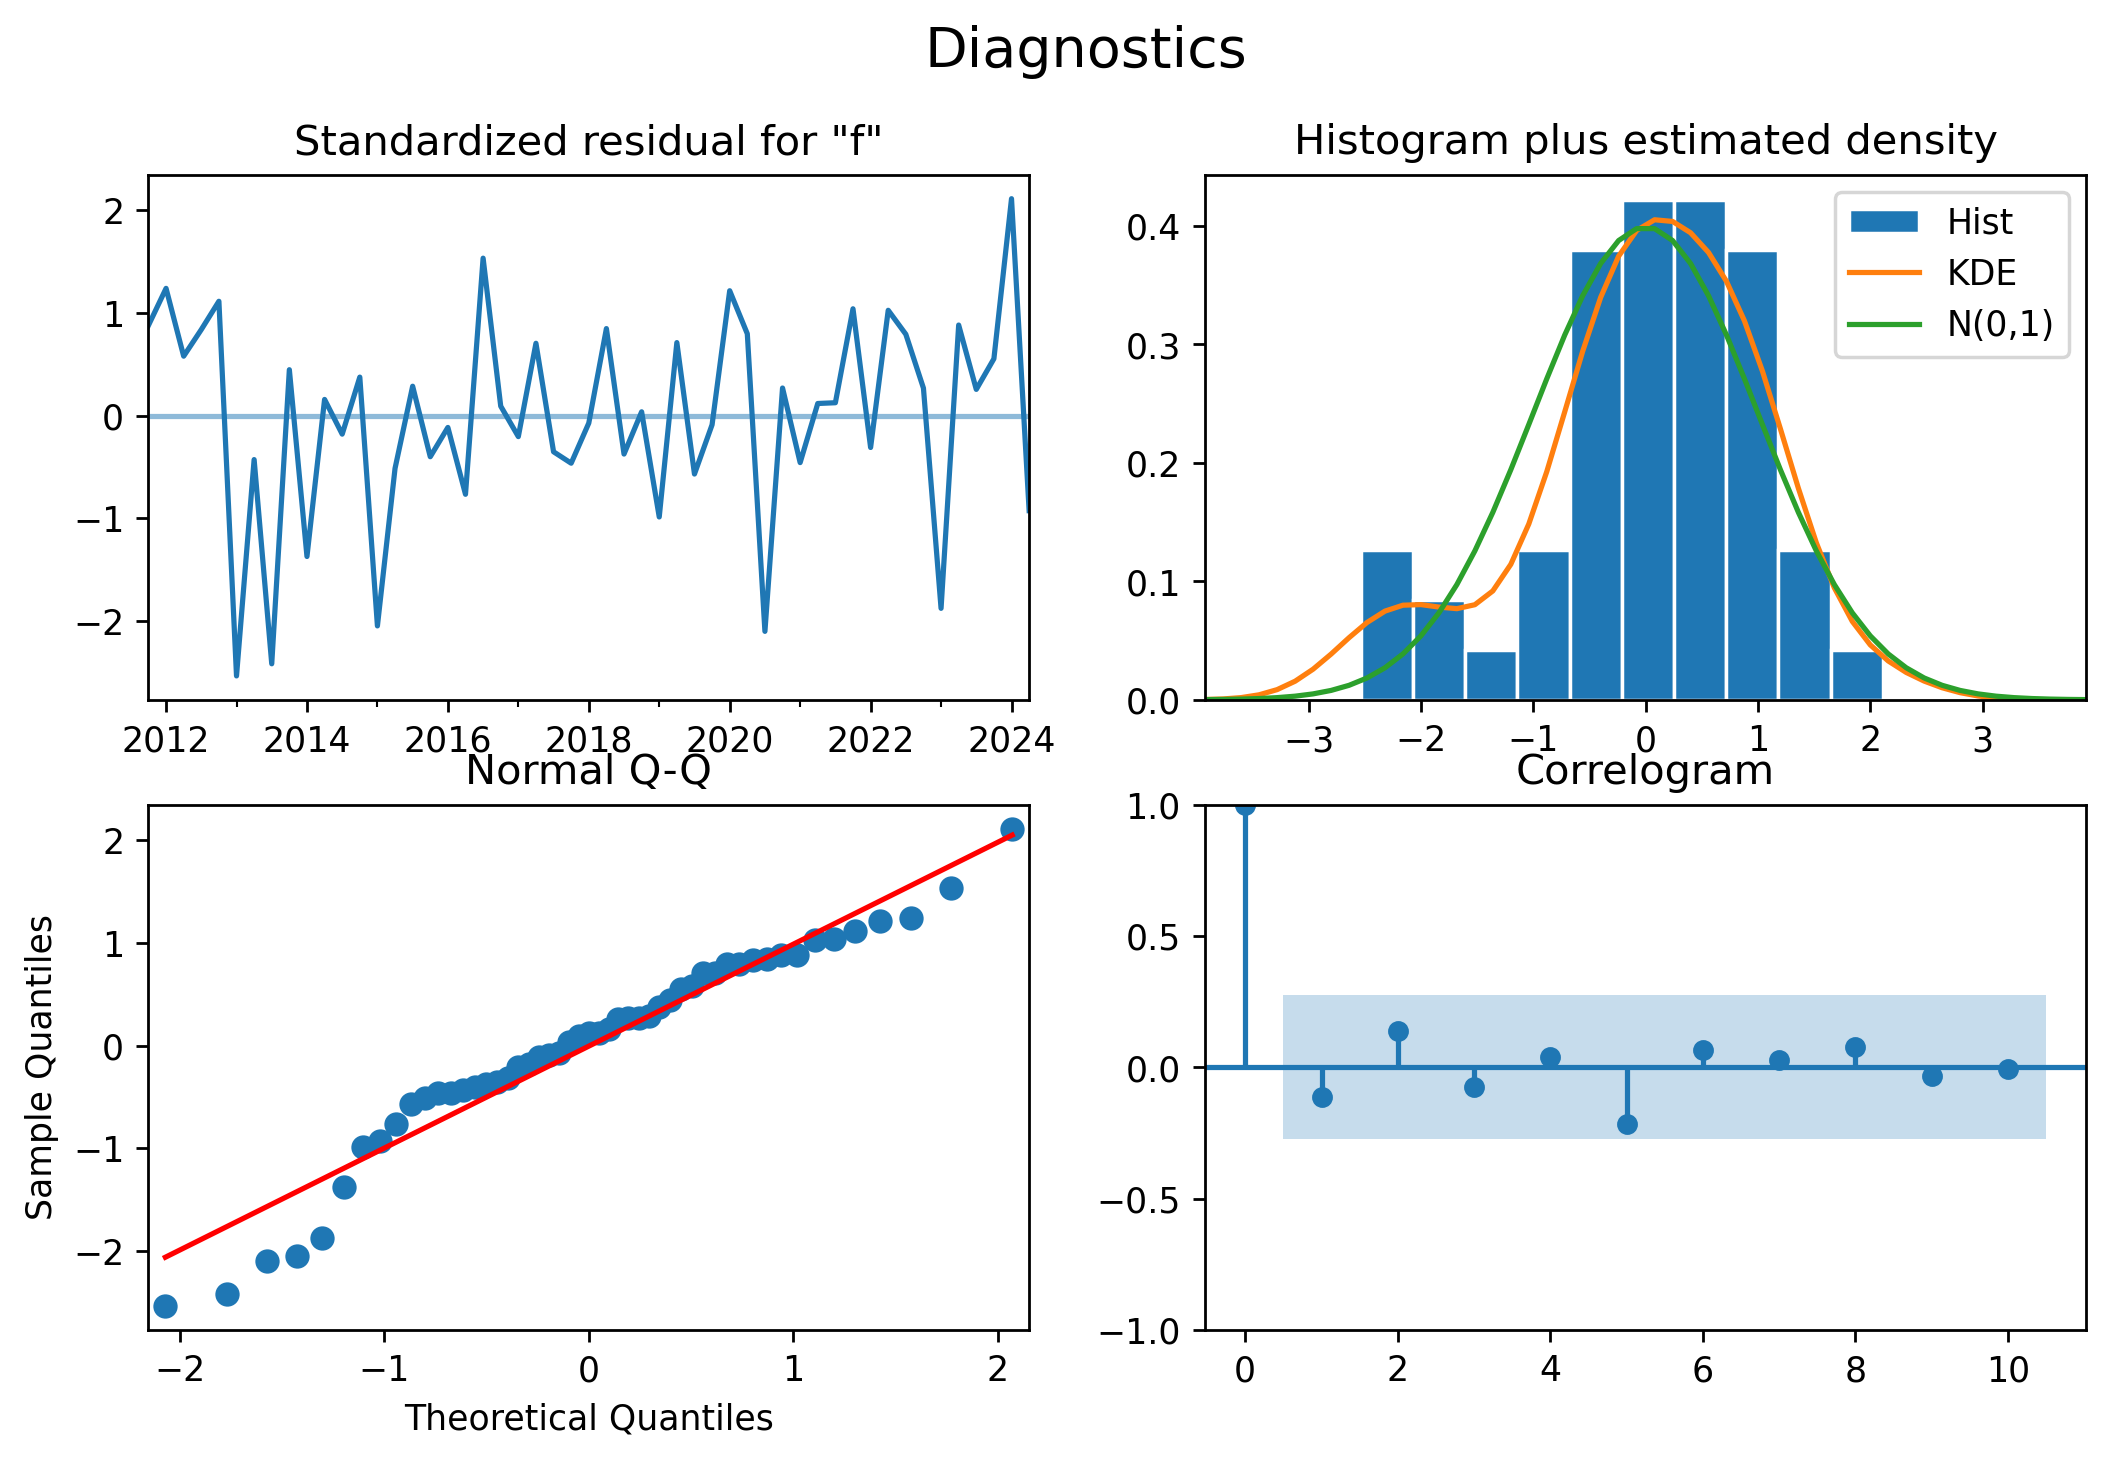

/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/951701396.py:38: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start=data.index[-1], periods=5, freq='Q')[1:]


Forecasted Dates:
DatetimeIndex(['2024-09-30', '2024-12-31', '2025-03-31', '2025-06-30'], dtype='datetime64[ns]', freq='QE-DEC')

Forecasted Values:
2024-09-30    0.109237
2024-12-31    0.108388
2025-03-31    0.103909
2025-06-30    0.108123
Freq: QE-DEC, Name: predicted_mean, dtype: float64


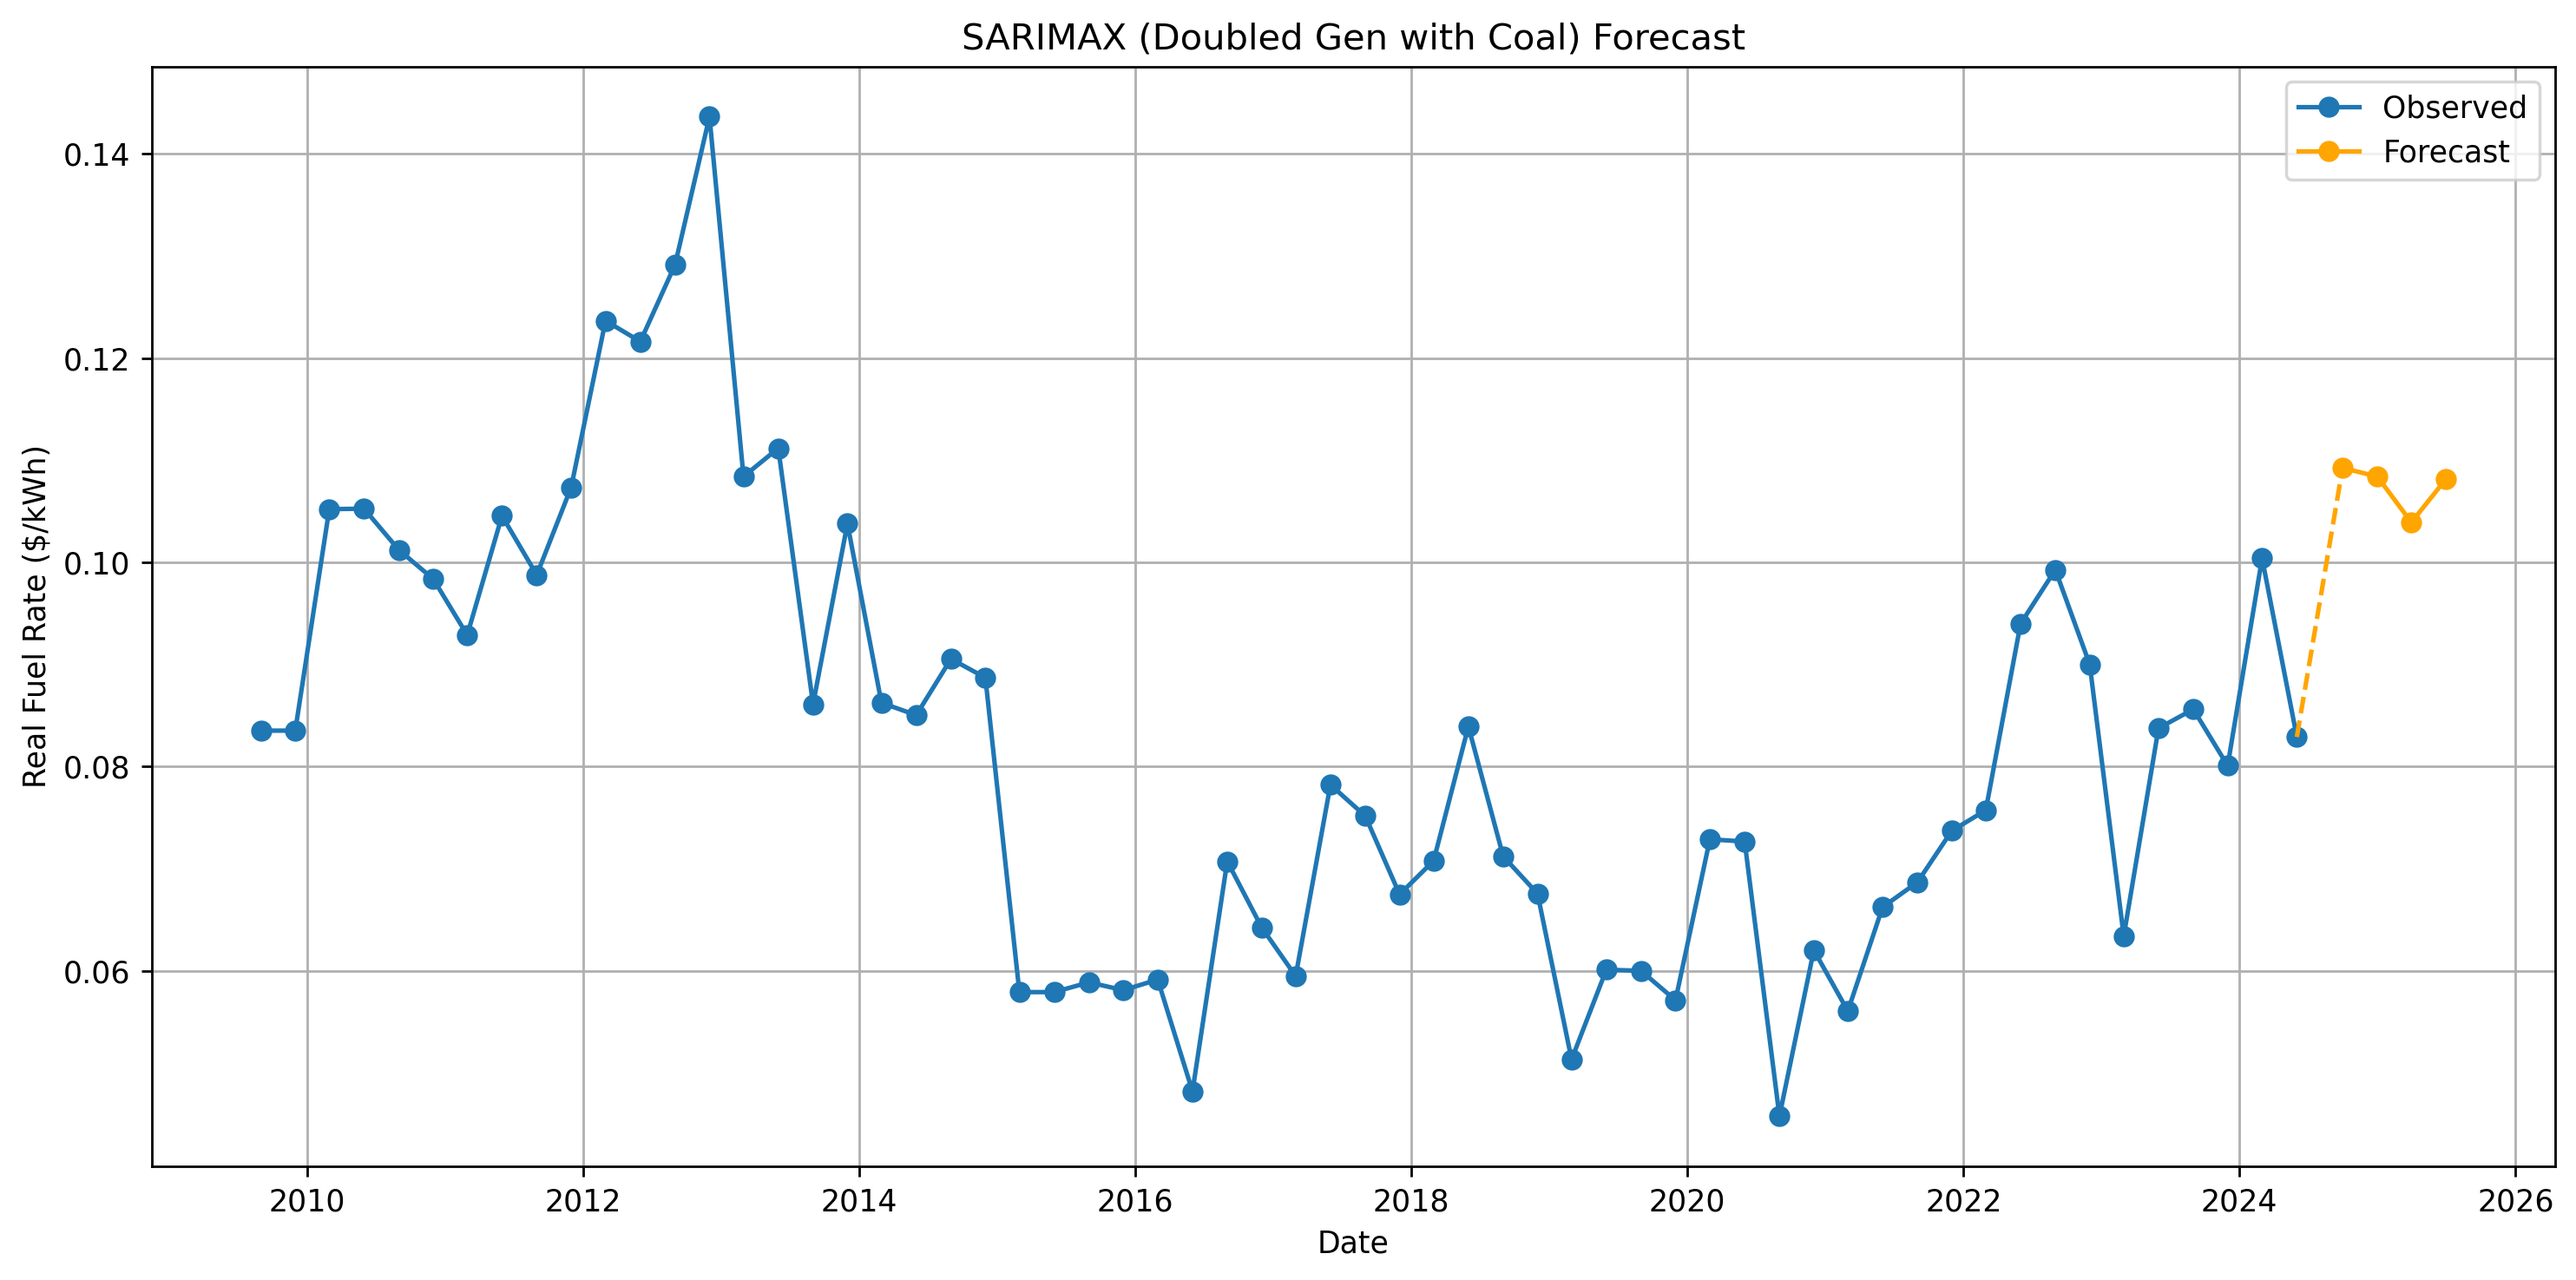

/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/951701396.py:109: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_series[i] = (forecast_series[i]*last_cpi)/100
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/951701396.py:109: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  forecast_series[i] = (forecast_series[i]*last_cpi)/100
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/951701396.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFram

Nominal Forecast Values
2024-09-30    0.180931
2024-12-31    0.179525
2025-03-31    0.172107
2025-06-30    0.179087
Freq: QE-DEC, Name: predicted_mean, dtype: float64
Nominal Effective Rates Forecast
0.3214007958583808
0.31999464227891994
0.31257669329739246
0.3195566491611244


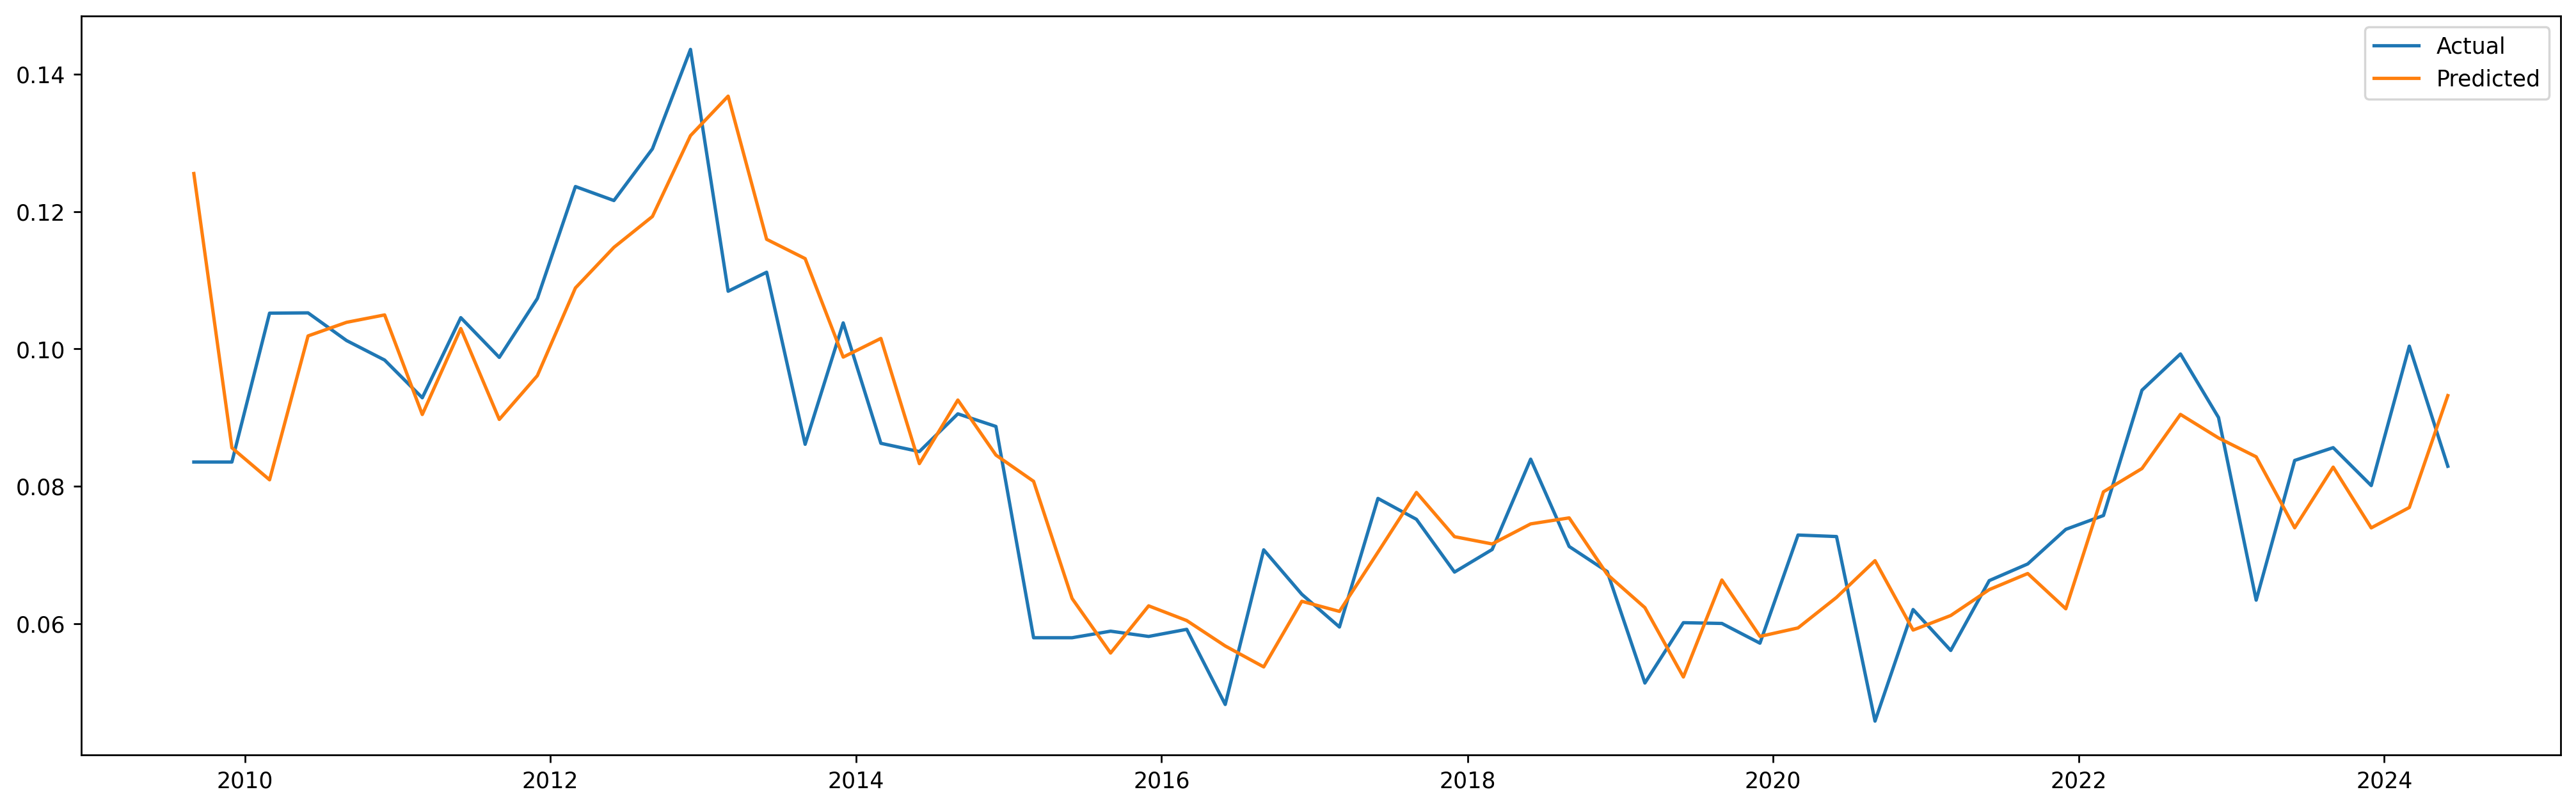

In [1022]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define exogenous variables
exog = pd.DataFrame({
    'net_gen': data['net_gen'],
    'nat_gas_prices': data['nat_gas_real'],
    'crude_prod': data['crude_oil_prod'], 
    'crude_prices_real': data['crude_prices_real'],
    'coal': data['coal'],
    'wind': data['wnd'],
    'oil': data['oil']
})

# Fit the SARIMAX model using the scaled exogenous variables
model_sarimax = SARIMAX(
    endog=data['fpp_real'],
    exog=exog,
    order=(0, 1, 1),
    seasonal_order=(2, 0, 1, 4),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model_sarimax.fit()

#plot diagnostics
results.plot_diagnostics(figsize=(10, 6))
plt.suptitle('Diagnostics', fontsize=16)
plt.show()

# Generate in-sample predictions
predicted = results.predict(start=0, end=len(data)-1, exog=exog)

# Prepare future exogenous data
future_dates = pd.date_range(start=data.index[-1], periods=5, freq='Q')[1:]

# Assuming window_size and n_steps are defined
window_size = 4  
n_steps = 4  # Number of steps to forecast

net_gen_adding = np.mean(data['net_gen'].values[-window_size:])


future_exog = {
    'net_gen': np.mean(data['net_gen'].values[-window_size:]*2) * np.ones(n_steps),
    'nat_gas_prices': np.mean(data['nat_gas_real'].values[-window_size:]) * np.ones(n_steps), 
    'crude_prod': np.mean(data['crude_oil_prod'].values[-window_size:]) * np.ones(n_steps),
    'crude_prices_real': np.mean(data['crude_prices_real'].values[-window_size:]) * np.ones(n_steps),
    'coal': np.mean(data['coal'].values[-window_size:]+net_gen_adding) * np.ones(n_steps),
    'wind': np.mean(data['wnd'].values[-window_size:]) * np.ones(n_steps),
    'oil': np.mean(data['oil'].values[-window_size:]) * np.ones(n_steps)

}
future_exog_df = pd.DataFrame(future_exog, index=future_dates)

# Forecasting with the SARIMAX model
forecast = results.get_forecast(steps=n_steps, exog=future_exog_df)
forecast_index = future_dates
forecast_series = forecast.predicted_mean

# Assign the forecast index to the forecast series
forecast_series.index = forecast_index

# Print the forecasted values
print("Forecasted Dates:")
print(forecast_index)

print("\nForecasted Values:")
print(forecast_series)

# Plotting the forecast
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(data.index, data['fpp_real'], label='Observed', marker='o')
ax.plot(forecast_index, forecast_series, color='orange', label='Forecast', marker='o')

# Extend observed data line to forecast start
observed_end = data.index[-1]
forecast_start = forecast_index[0]
observed_value_end = data['fpp_real'].iloc[-1]
forecast_value_start = forecast_series.iloc[0]
ax.plot([observed_end, forecast_start], [observed_value_end, forecast_value_start], color='orange', linestyle='--')

ax.set_title('SARIMAX (Doubled Gen with Coal) Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Real Fuel Rate ($/kWh)')
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


#plot predicted and actual values
plt.figure(figsize=(20,6))
plt.plot(data['fpp_real'],label='Actual')
plt.plot(predicted,label='Predicted')
plt.legend()


utility_last = data["utility_real"].iloc[-1]

#adjust for CPi
last_cpi = data['CPI_new'].iloc[-1]
for i in range(len(forecast_series)):
    forecast_series[i] = (forecast_series[i]*last_cpi)/100

print("Nominal Forecast Values")
print(forecast_series)

print("Nominal Effective Rates Forecast")
utility_add = (utility_last*last_cpi)/100

for i in range(len(forecast_series)):
    print(forecast_series[i] + utility_add)


### What if the natural gas prices double?

/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.61764D+00    |proj g|=  3.55033D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12      1     21      1     0     0   3.550D+07  -2.618D+00
  F =  -2.6176431490457777     

ABNORMAL_TERMINATION_IN_LNSRCH                              


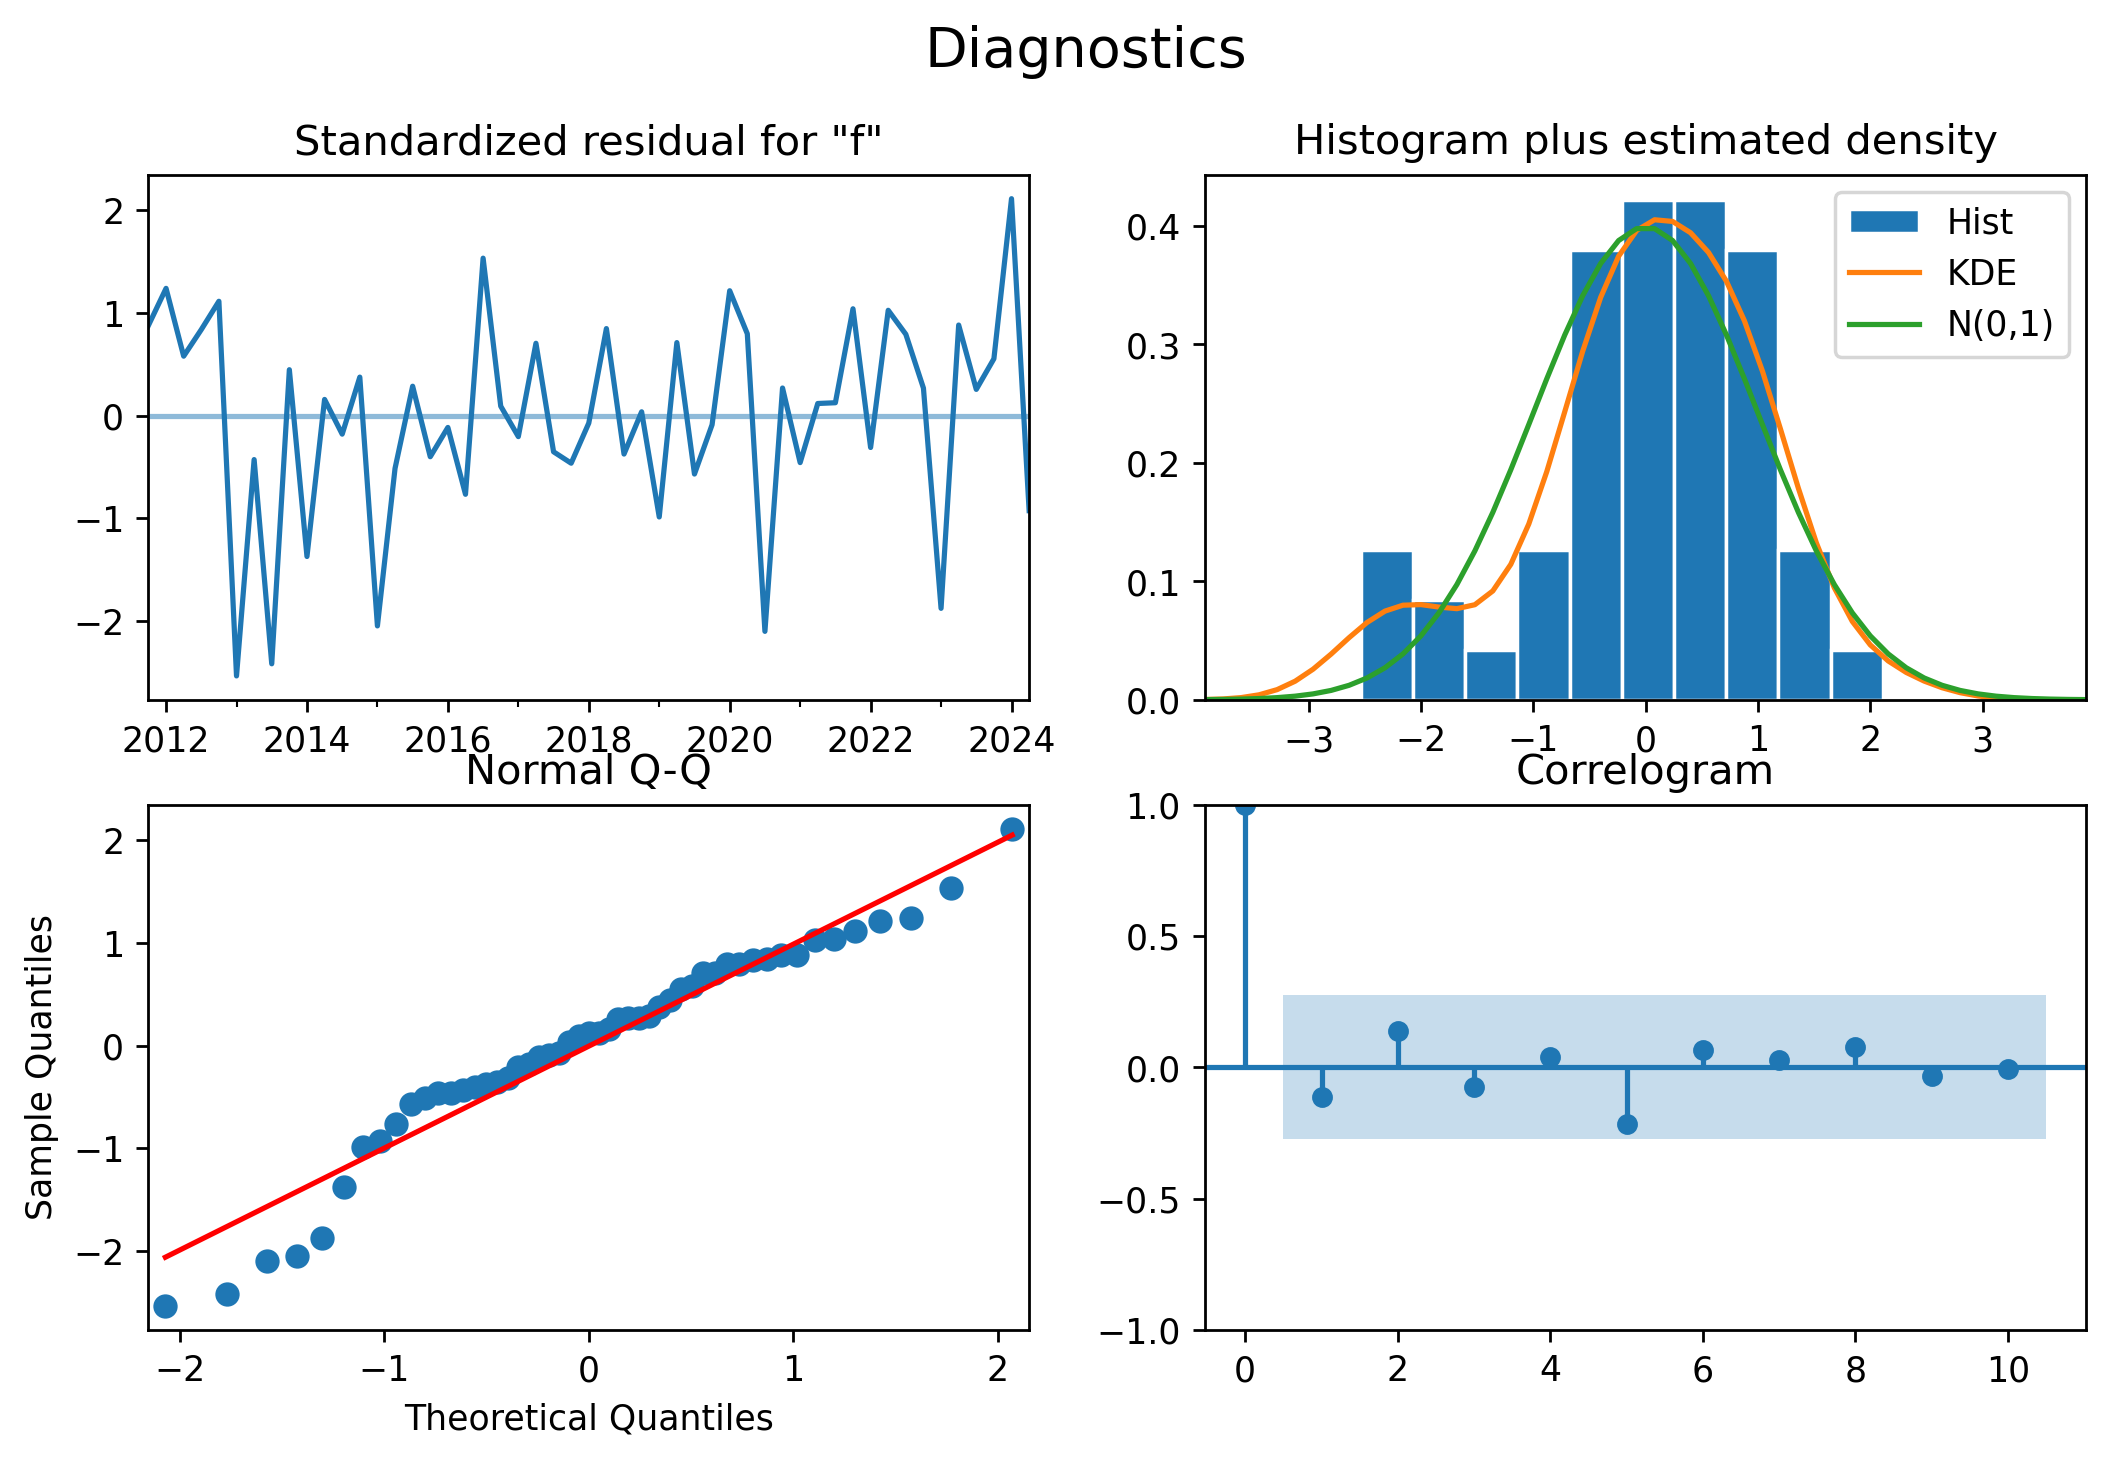

/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/2214452319.py:38: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start=data.index[-1], periods=5, freq='Q')[1:]


Forecasted Dates:
DatetimeIndex(['2024-09-30', '2024-12-31', '2025-03-31', '2025-06-30'], dtype='datetime64[ns]', freq='QE-DEC')

Forecasted Values:
2024-09-30    0.148455
2024-12-31    0.147606
2025-03-31    0.143128
2025-06-30    0.147342
Freq: QE-DEC, Name: predicted_mean, dtype: float64


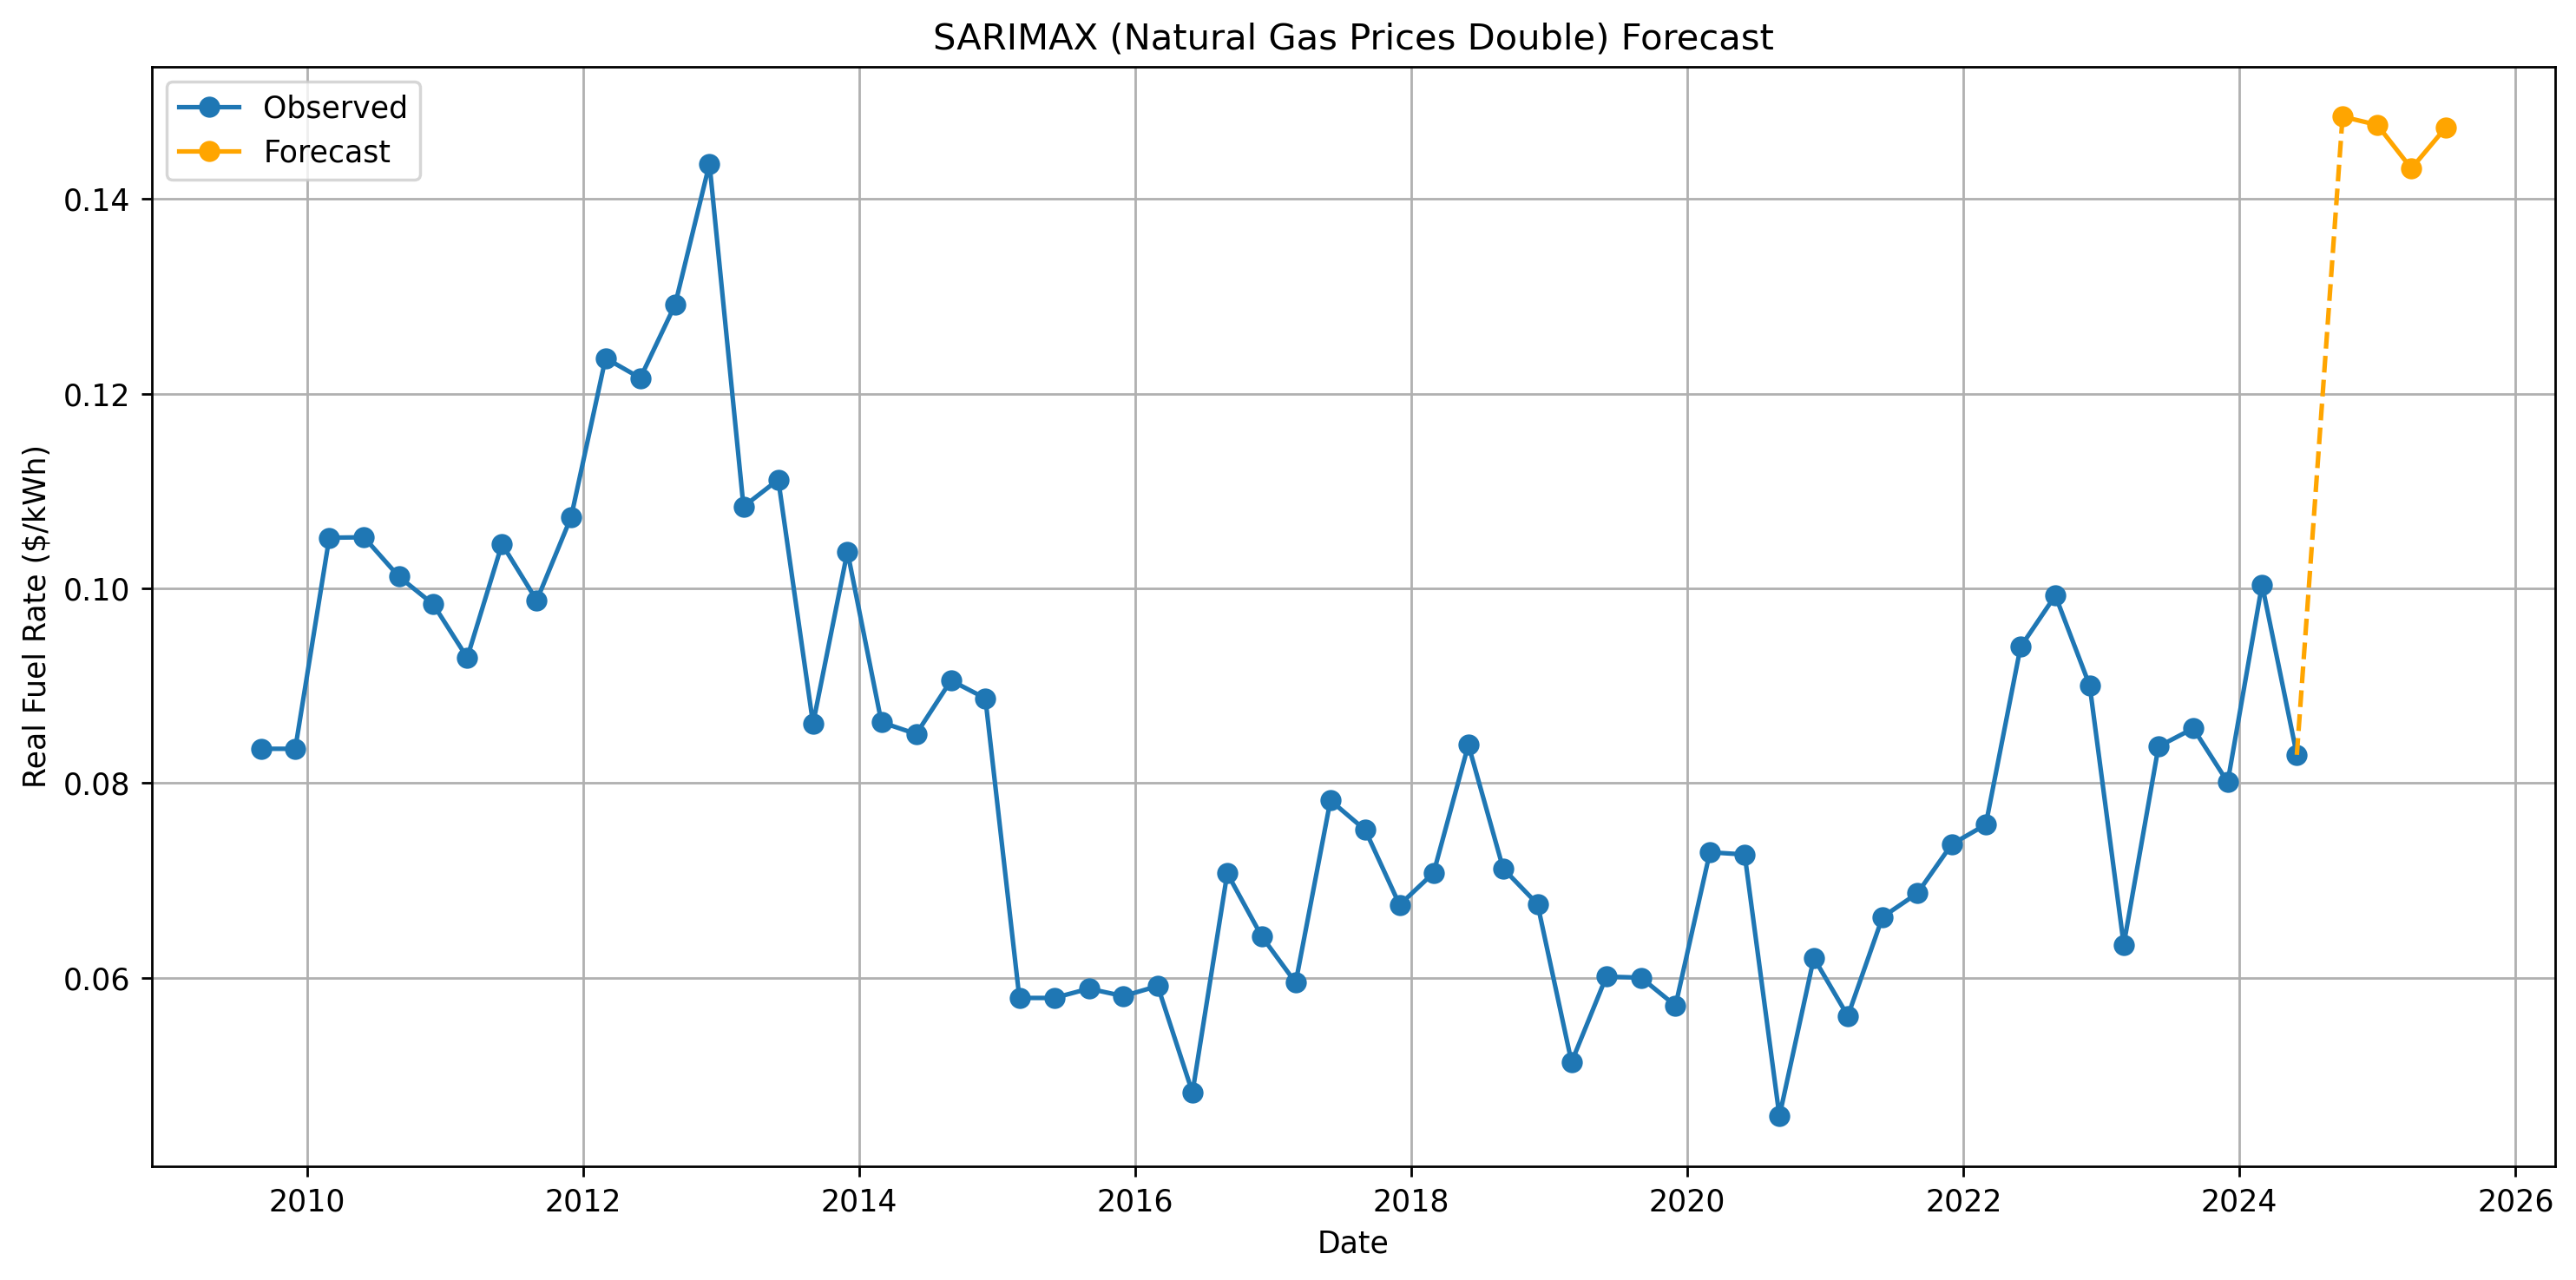

/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/2214452319.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_series[i] = (forecast_series[i]*last_cpi)/100
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/2214452319.py:106: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  forecast_series[i] = (forecast_series[i]*last_cpi)/100
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/2214452319.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

Nominal Forecast Values
2024-09-30    0.245889
2024-12-31    0.244483
2025-03-31    0.237065
2025-06-30    0.244045
Freq: QE-DEC, Name: predicted_mean, dtype: float64
Nominal Effective Rates Forecast
0.38635901225126235
0.38495285867180146
0.37753490969027403
0.38451486555400594


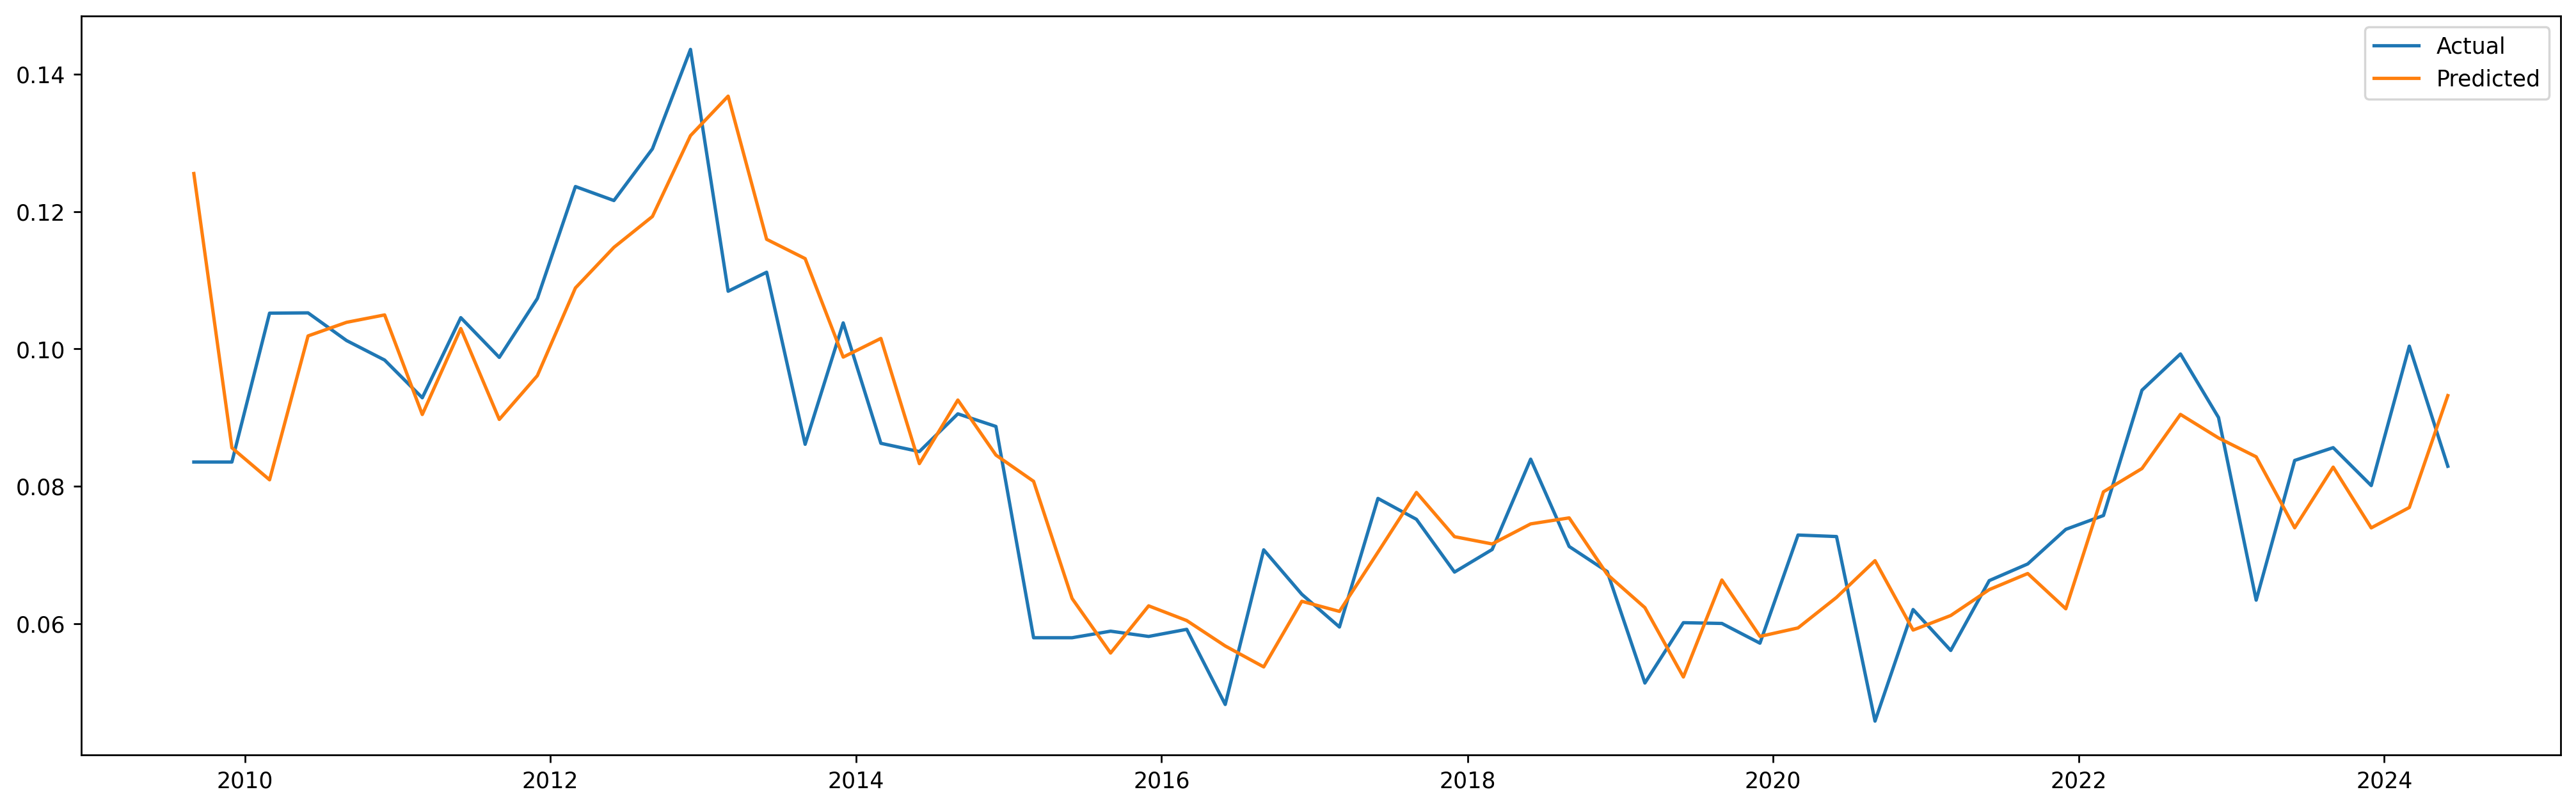

In [1023]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define exogenous variables
exog = pd.DataFrame({
    'net_gen': data['net_gen'],
    'nat_gas_prices': data['nat_gas_real'],
    'crude_prod': data['crude_oil_prod'], 
    'crude_prices_real': data['crude_prices_real'],
    'coal': data['coal'],
    'wind': data['wnd'],
    'oil': data['oil']
})

# Fit the SARIMAX model using the scaled exogenous variables
model_sarimax = SARIMAX(
    endog=data['fpp_real'],
    exog=exog,
    order=(0, 1, 1),
    seasonal_order=(2, 0, 1, 4),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model_sarimax.fit()

#plot diagnostics
results.plot_diagnostics(figsize=(10, 6))
plt.suptitle('Diagnostics', fontsize=16)
plt.show()

# Generate in-sample predictions
predicted = results.predict(start=0, end=len(data)-1, exog=exog)

# Prepare future exogenous data
future_dates = pd.date_range(start=data.index[-1], periods=5, freq='Q')[1:]

# Assuming window_size and n_steps are defined
window_size = 4  
n_steps = 4  # Number of steps to forecast

future_exog = {
    'net_gen': (np.mean(data['net_gen'].values[-window_size:])) * np.ones(n_steps),
    'nat_gas_prices': np.mean(data['nat_gas_real'].values[-window_size:]*2) * np.ones(n_steps),
    'crude_prod': np.mean(data['crude_oil_prod'].values[-window_size:]) * np.ones(n_steps),
    'crude_prices_real': np.mean(data['crude_prices_real'].values[-window_size:]*1.059) * np.ones(n_steps),
    'coal': np.mean(data['coal'].values[-window_size:]) * np.ones(n_steps),
    'wind': np.mean(data['wnd'].values[-window_size:]) * np.ones(n_steps),
    'oil': np.mean(data['oil'].values[-window_size:]) * np.ones(n_steps)

}
future_exog_df = pd.DataFrame(future_exog, index=future_dates)

# Forecasting with the SARIMAX model
forecast = results.get_forecast(steps=n_steps, exog=future_exog_df)
forecast_index = future_dates
forecast_series = forecast.predicted_mean

# Assign the forecast index to the forecast series
forecast_series.index = forecast_index

# Print the forecasted values
print("Forecasted Dates:")
print(forecast_index)

print("\nForecasted Values:")
print(forecast_series)

# Plotting the forecast
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(data.index, data['fpp_real'], label='Observed', marker='o')
ax.plot(forecast_index, forecast_series, color='orange', label='Forecast', marker='o')

# Extend observed data line to forecast start
observed_end = data.index[-1]
forecast_start = forecast_index[0]
observed_value_end = data['fpp_real'].iloc[-1]
forecast_value_start = forecast_series.iloc[0]
ax.plot([observed_end, forecast_start], [observed_value_end, forecast_value_start], color='orange', linestyle='--')

ax.set_title('SARIMAX (Natural Gas Prices Double) Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Real Fuel Rate ($/kWh)')
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


#plot predicted and actual values
plt.figure(figsize=(20,6))
plt.plot(data['fpp_real'],label='Actual')
plt.plot(predicted,label='Predicted')
plt.legend()


utility_last = data["utility_real"].iloc[-1]

#adjust for CPi
last_cpi = data['CPI_new'].iloc[-1]
for i in range(len(forecast_series)):
    forecast_series[i] = (forecast_series[i]*last_cpi)/100

print("Nominal Forecast Values")
print(forecast_series)

print("Nominal Effective Rates Forecast")
utility_add = (utility_last*last_cpi)/100

for i in range(len(forecast_series)):
    print(forecast_series[i] + utility_add)



Prices will increase to about $0.38-0.39/kWh

This is a 85% increase, from 0.08 -> 0.148

### What if the mines close down?

In [1024]:

#how much generation is coal generation
coal_gen = data['coal'].sum()
perc_coal = coal_gen/data['net_gen'].sum()
net_gen_last = data['net_gen'].iloc[-1]
coal_part = perc_coal*net_gen_last
perc_oil = data['oil'].sum()/data['net_gen'].sum()
print(perc_oil)
oil_part = perc_oil*net_gen_last

0.5957169272882205


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.61764D+00    |proj g|=  3.55033D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12      1     21      1     0     0   3.550D+07  -2.618D+00
  F =  -2.6176431490457777     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


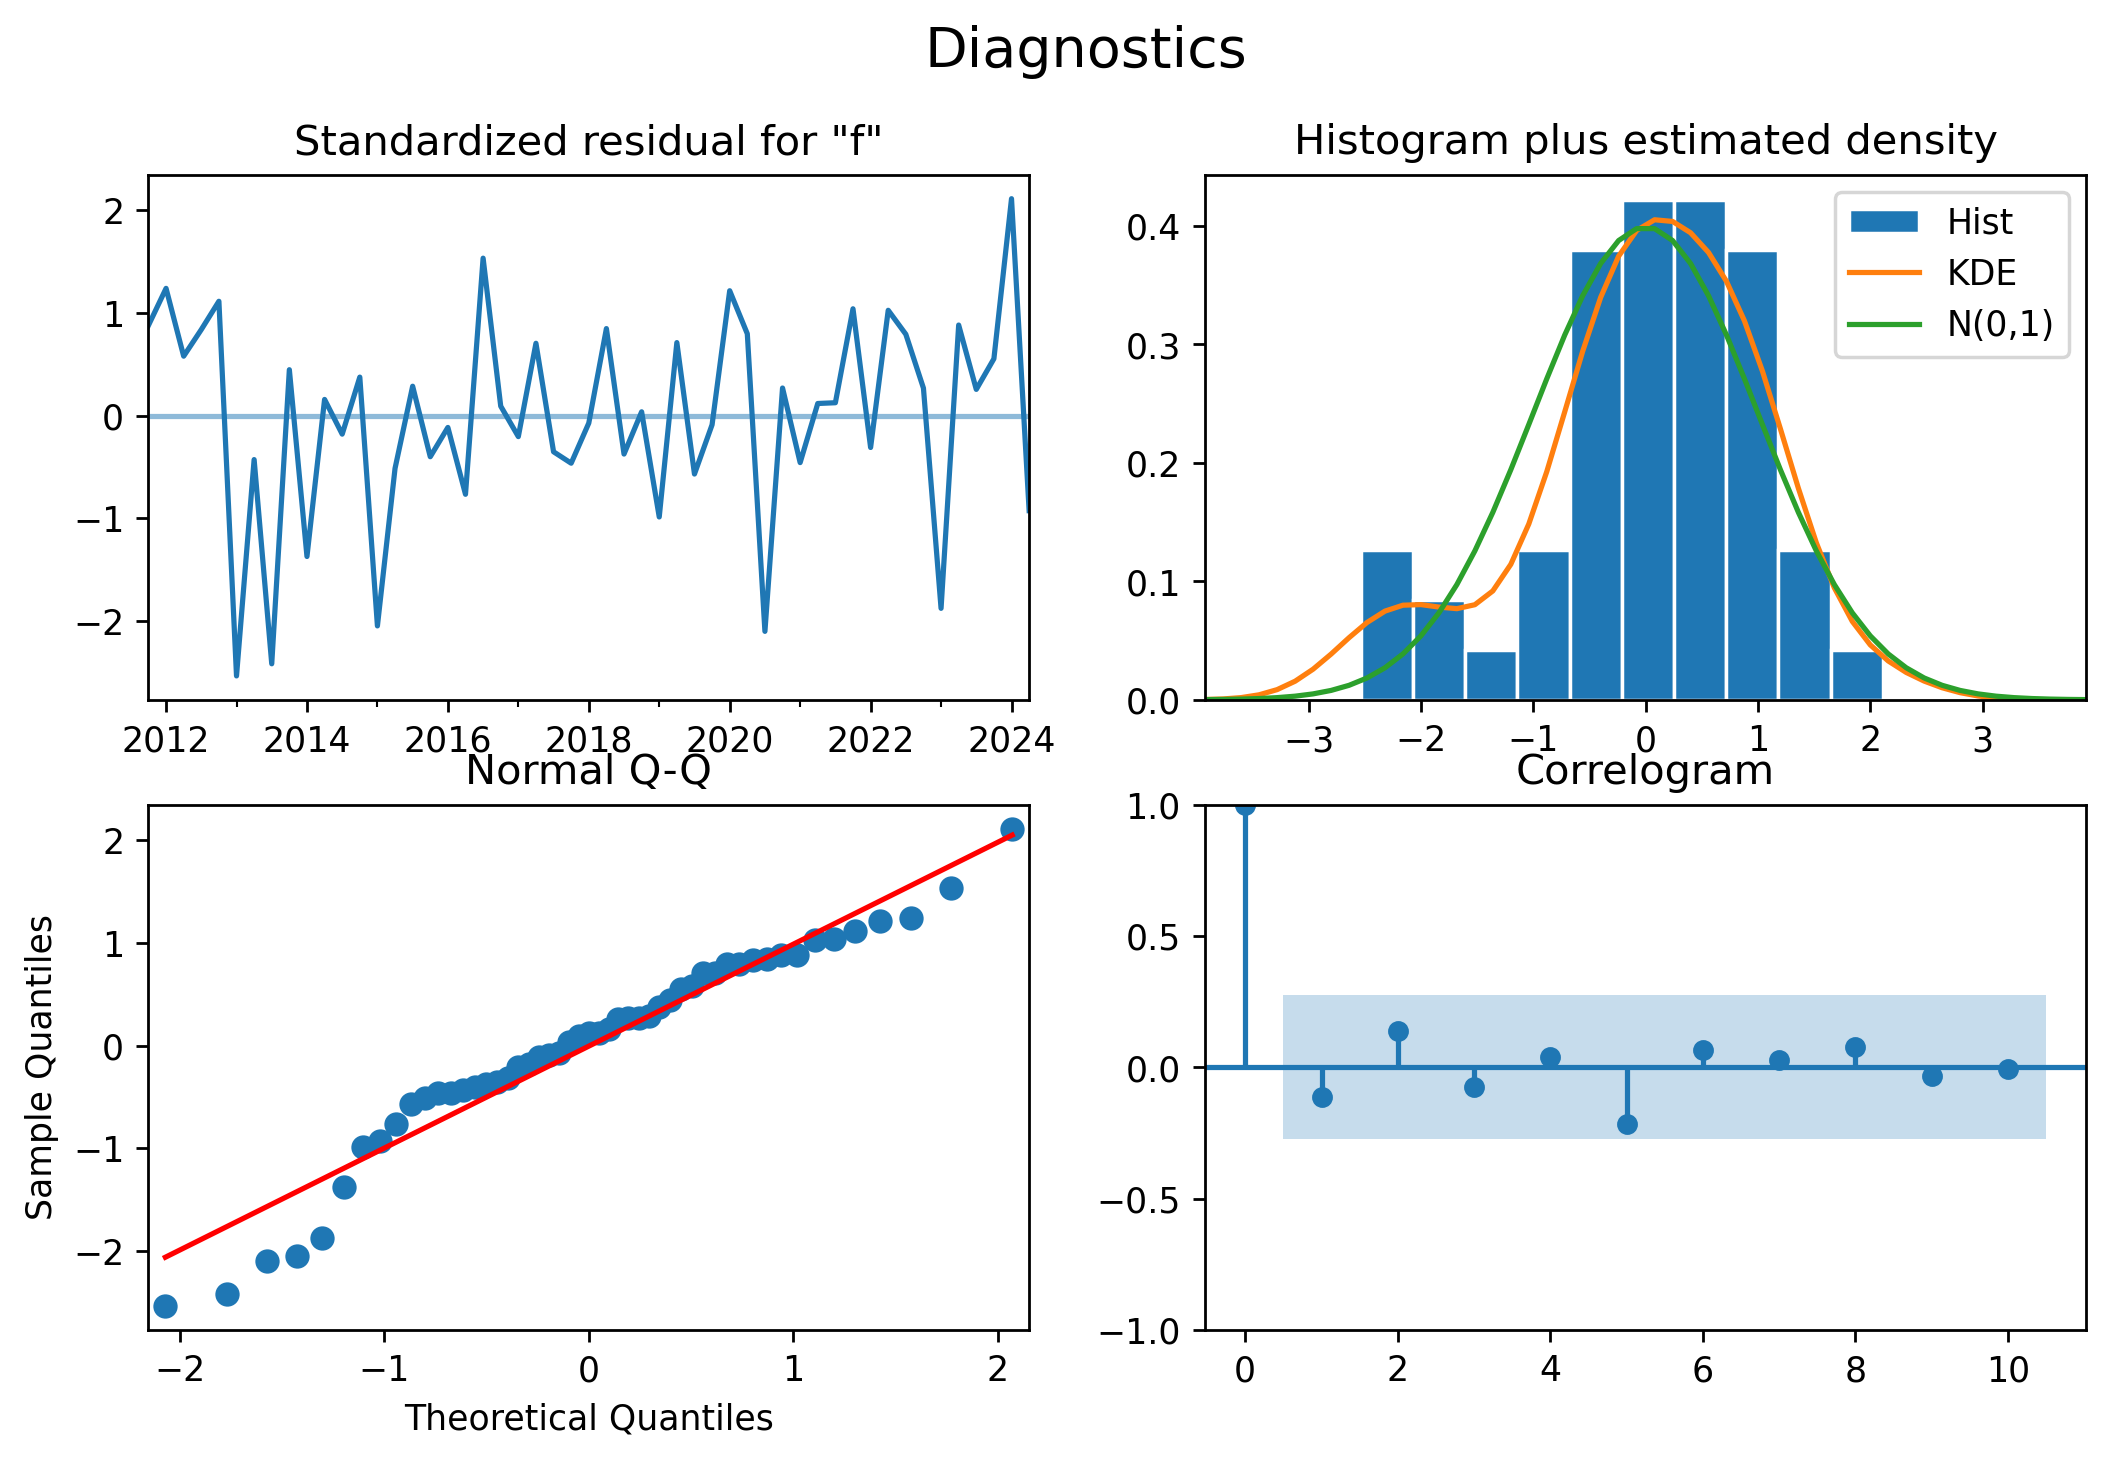

/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/1759746831.py:38: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start=data.index[-1], periods=5, freq='Q')[1:]


Forecasted Dates:
DatetimeIndex(['2024-09-30', '2024-12-31', '2025-03-31', '2025-06-30'], dtype='datetime64[ns]', freq='QE-DEC')

Forecasted Values:
2024-09-30    0.144390
2024-12-31    0.143541
2025-03-31    0.139063
2025-06-30    0.143277
Freq: QE-DEC, Name: predicted_mean, dtype: float64


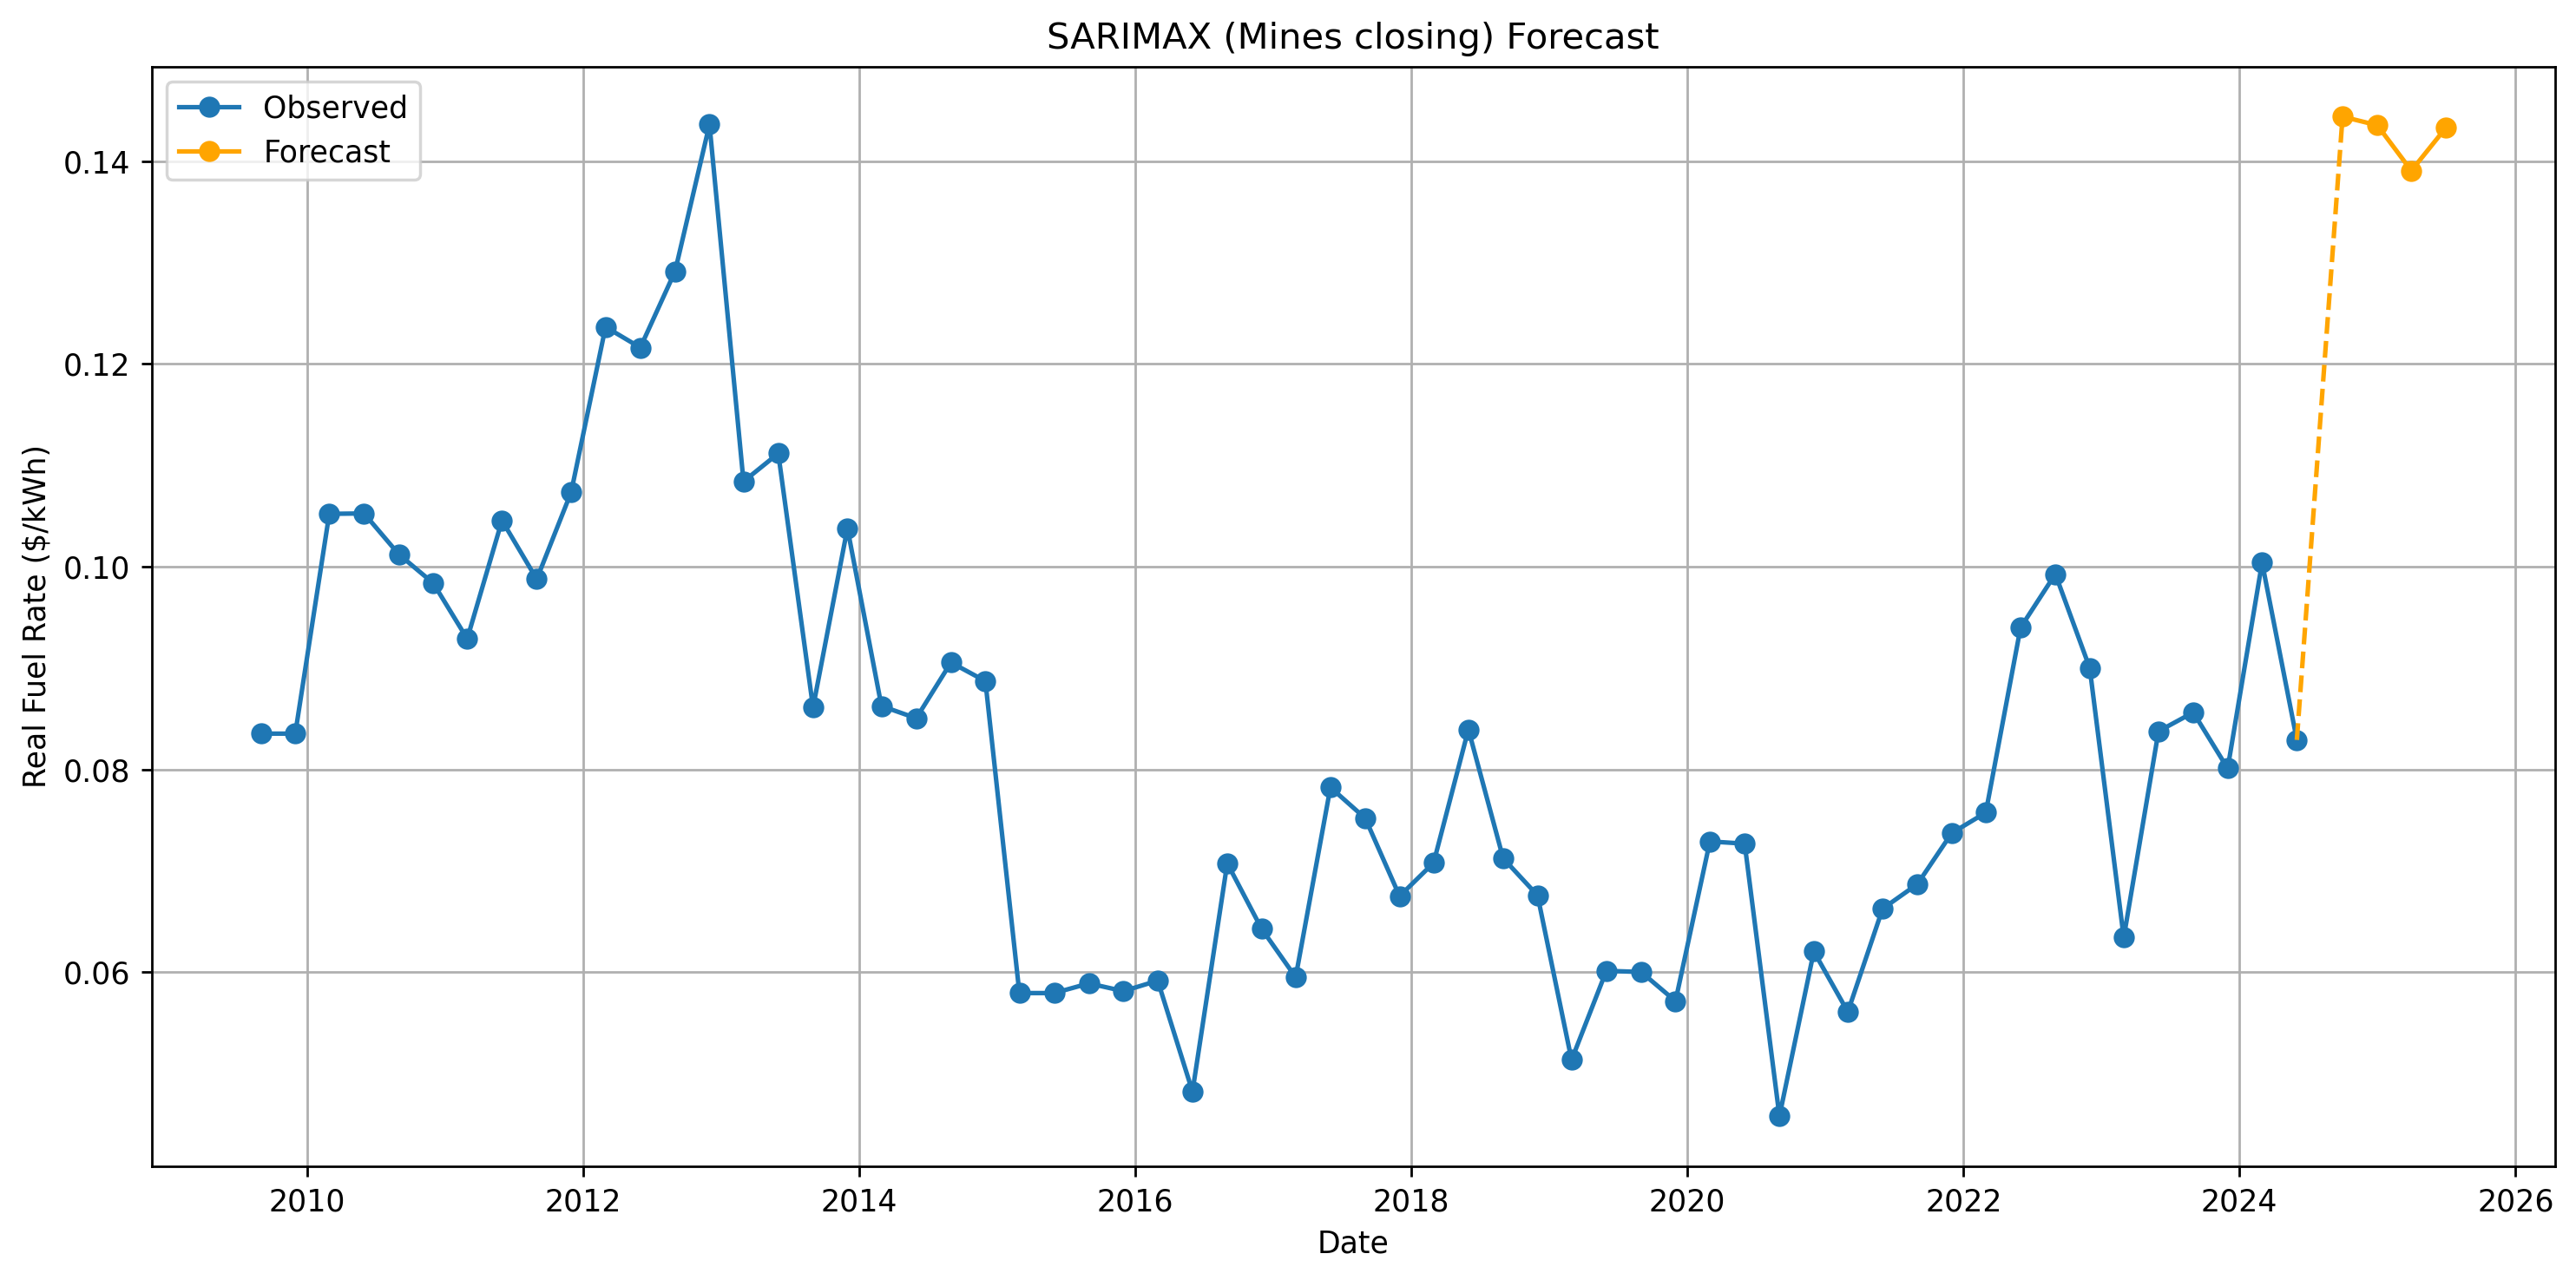

/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/1759746831.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_series[i] = (forecast_series[i]*last_cpi)/100
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/1759746831.py:108: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  forecast_series[i] = (forecast_series[i]*last_cpi)/100
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/1759746831.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

Nominal Forecast Values
2024-09-30    0.239156
2024-12-31    0.237750
2025-03-31    0.230332
2025-06-30    0.237312
Freq: QE-DEC, Name: predicted_mean, dtype: float64
Nominal Effective Rates Forecast
0.3796261792730383
0.3782200256935775
0.37080207671205
0.3777820325757819


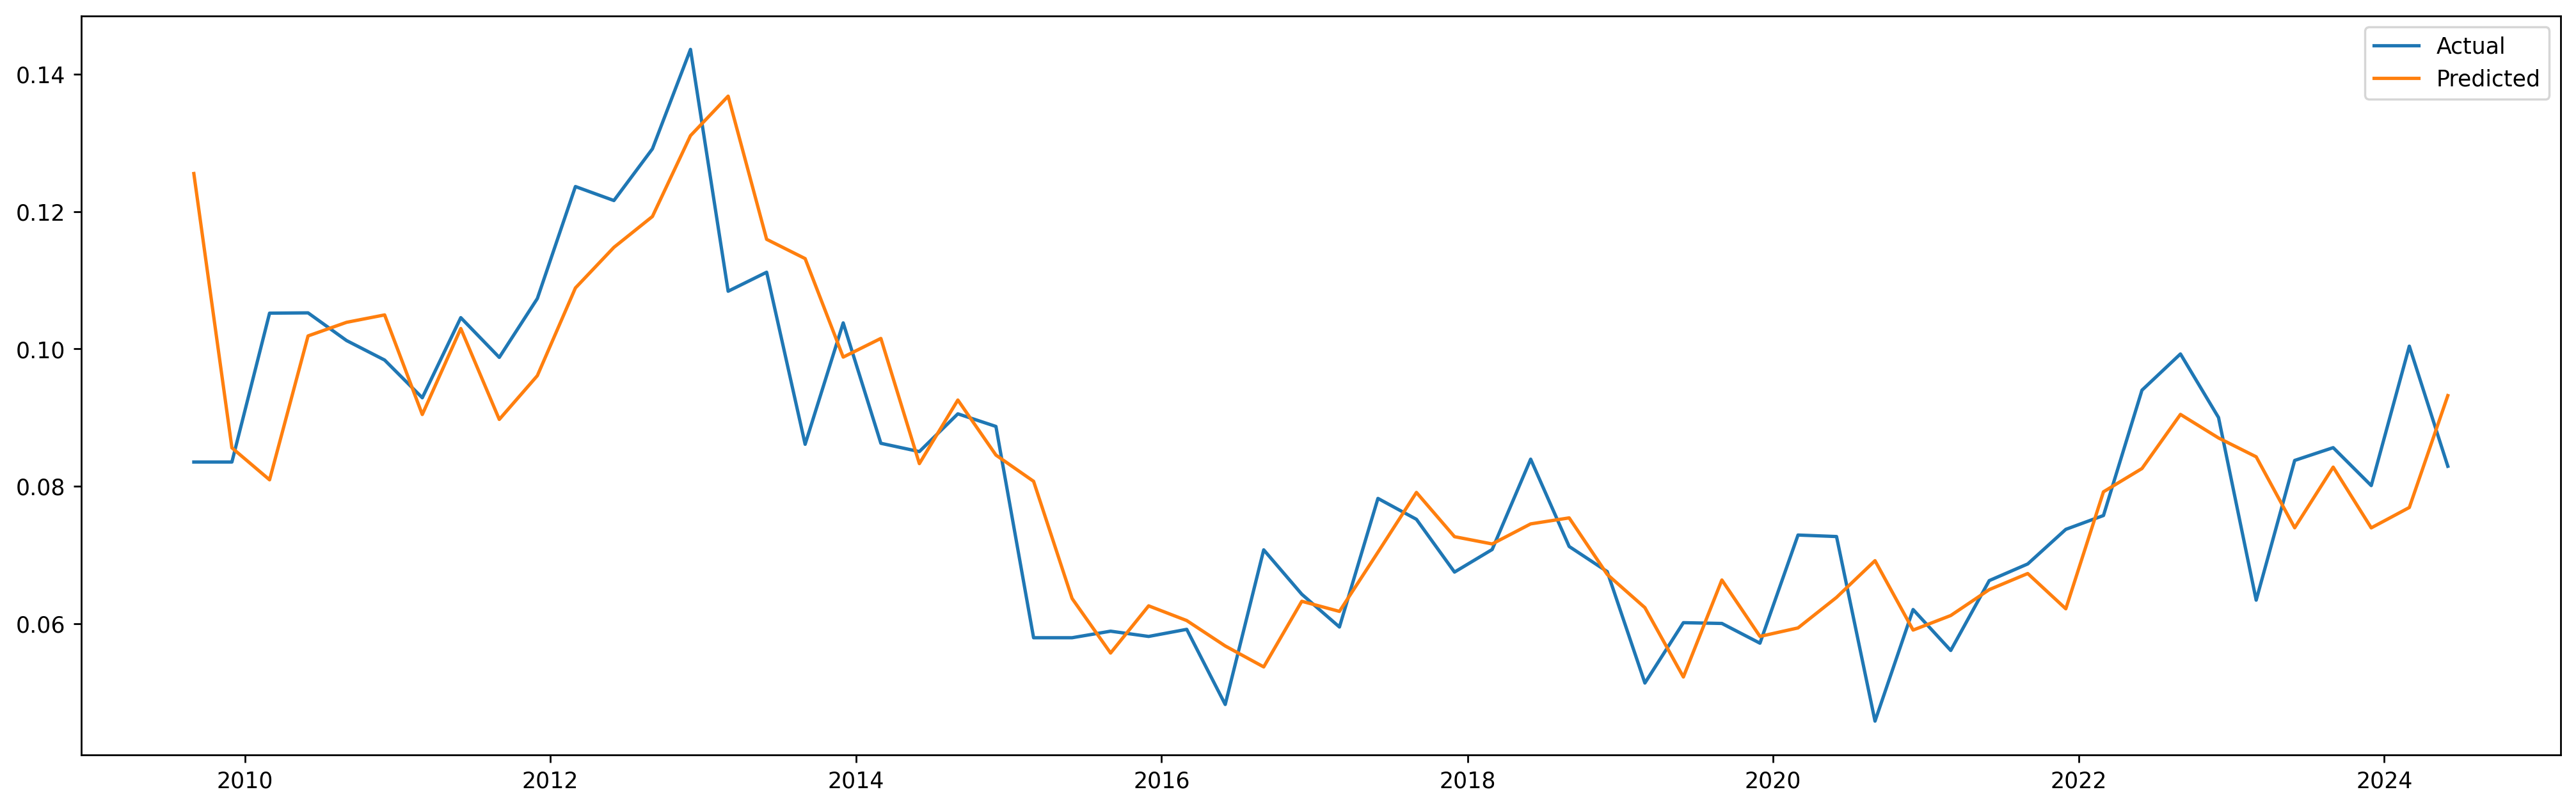

In [1025]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define exogenous variables
exog = pd.DataFrame({
    'net_gen': data['net_gen'],
    'nat_gas_prices': data['nat_gas_real'],
    'crude_prod': data['crude_oil_prod'], 
    'crude_prices_real': data['crude_prices_real'],
    'coal': data['coal'],
    'wind': data['wnd'],
    'oil': data['oil']
})

# Fit the SARIMAX model using the scaled exogenous variables
model_sarimax = SARIMAX(
    endog=data['fpp_real'],
    exog=exog,
    order=(0, 1, 1),
    seasonal_order=(2, 0, 1, 4),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model_sarimax.fit()

#plot diagnostics
results.plot_diagnostics(figsize=(10, 6))
plt.suptitle('Diagnostics', fontsize=16)
plt.show()

# Generate in-sample predictions
predicted = results.predict(start=0, end=len(data)-1, exog=exog)

# Prepare future exogenous data
future_dates = pd.date_range(start=data.index[-1], periods=5, freq='Q')[1:]

# Assuming window_size and n_steps are defined
window_size = 4  # Example window size
n_steps = 4  # Number of steps to forecast

future_exog = {

    'net_gen': (np.mean(data['net_gen'].values[-window_size:]-coal_part) * np.ones(n_steps)),
    'nat_gas_prices': np.mean(data['nat_gas_real'].values[-window_size:]*1.1) * np.ones(n_steps),
    'crude_prod': np.mean(data['crude_oil_prod'].values[-window_size:]+coal_part) * np.ones(n_steps),
    'crude_prices_real': (np.mean(data['crude_prices_real'].values[-window_size:])*1.059) * np.ones(n_steps),
    'coal': (0) * np.ones(n_steps),
    'wind': np.mean(data['wnd'].values[-window_size:]) * np.ones(n_steps),
    'oil': np.mean((data['oil'].values[-window_size:])) * np.ones(n_steps) 

}

future_exog_df = pd.DataFrame(future_exog, index=future_dates)

# Forecasting with the SARIMAX model
forecast = results.get_forecast(steps=n_steps, exog=future_exog_df)
forecast_index = future_dates
forecast_series = forecast.predicted_mean

# Assign the forecast index to the forecast series
forecast_series.index = forecast_index

# Print the forecasted values
print("Forecasted Dates:")
print(forecast_index)

print("\nForecasted Values:")
print(forecast_series)

# Plotting the forecast
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(data.index, data['fpp_real'], label='Observed', marker='o')
ax.plot(forecast_index, forecast_series, color='orange', label='Forecast', marker='o')

# Extend observed data line to forecast start
observed_end = data.index[-1]
forecast_start = forecast_index[0]
observed_value_end = data['fpp_real'].iloc[-1]
forecast_value_start = forecast_series.iloc[0]
ax.plot([observed_end, forecast_start], [observed_value_end, forecast_value_start], color='orange', linestyle='--')

ax.set_title('SARIMAX (Mines closing) Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Real Fuel Rate ($/kWh)')
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


#plot predicted and actual values
plt.figure(figsize=(20,6))
plt.plot(data['fpp_real'],label='Actual')
plt.plot(predicted,label='Predicted')
plt.legend()


utility_last = data["utility_real"].iloc[-1]

#adjust for CPi
last_cpi = data['CPI_new'].iloc[-1]
for i in range(len(forecast_series)):
    forecast_series[i] = (forecast_series[i]*last_cpi)/100

print("Nominal Forecast Values")
print(forecast_series)

print("Nominal Effective Rates Forecast")
utility_add = (utility_last*last_cpi)/100

for i in range(len(forecast_series)):
    print(forecast_series[i] + utility_add)



The mines leaving would cause price increases to $0.37/0.38/kWh. I interpret this as because the mines leave, could would be replaced by more expensive sources such as oil or natural gas, and the overall cost of electricity generation could increase. Oil and natural gas often have higher costs compared to coal, which can drive up prices.


This is a 68% increase, from 0.08 -> 0.14. 

### What Generation Doubling was met with Wind Generation?

/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.61764D+00    |proj g|=  3.55033D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12      1     21      1     0     0   3.550D+07  -2.618D+00
  F =  -2.6176431490457777     

ABNORMAL_TERMINATION_IN_LNSRCH                              


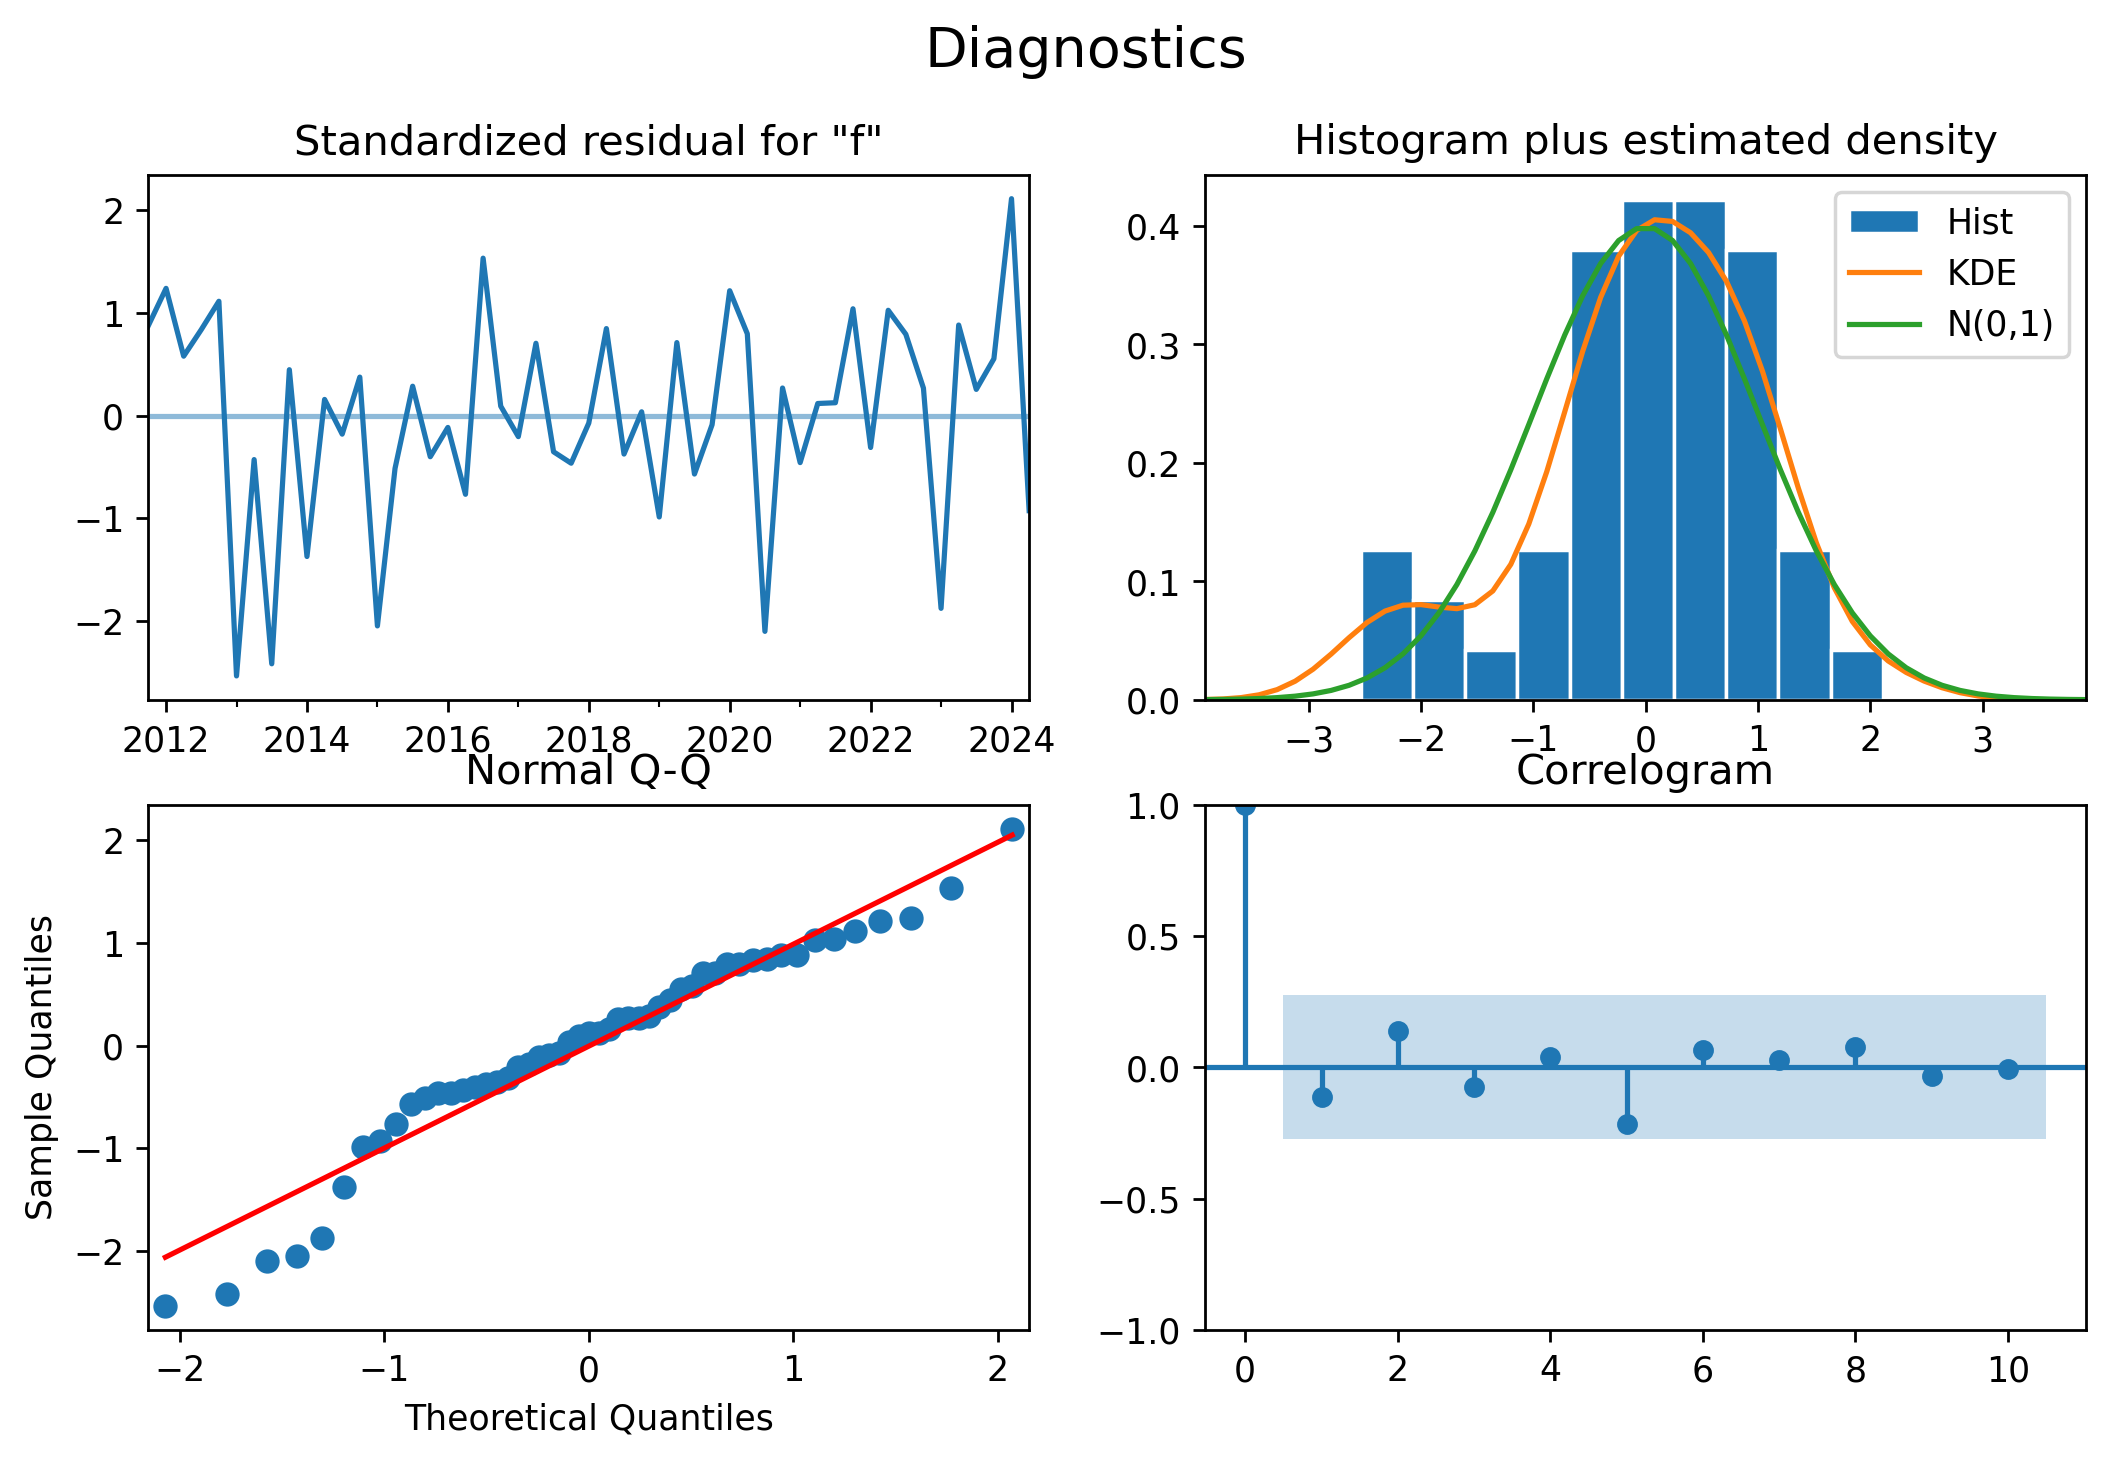

/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/101949648.py:38: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start=data.index[-1], periods=5, freq='Q')[1:]


Forecasted Dates:
DatetimeIndex(['2024-09-30', '2024-12-31', '2025-03-31', '2025-06-30'], dtype='datetime64[ns]', freq='QE-DEC')

Forecasted Values:
2024-09-30    0.050632
2024-12-31    0.049783
2025-03-31    0.045305
2025-06-30    0.049519
Freq: QE-DEC, Name: predicted_mean, dtype: float64


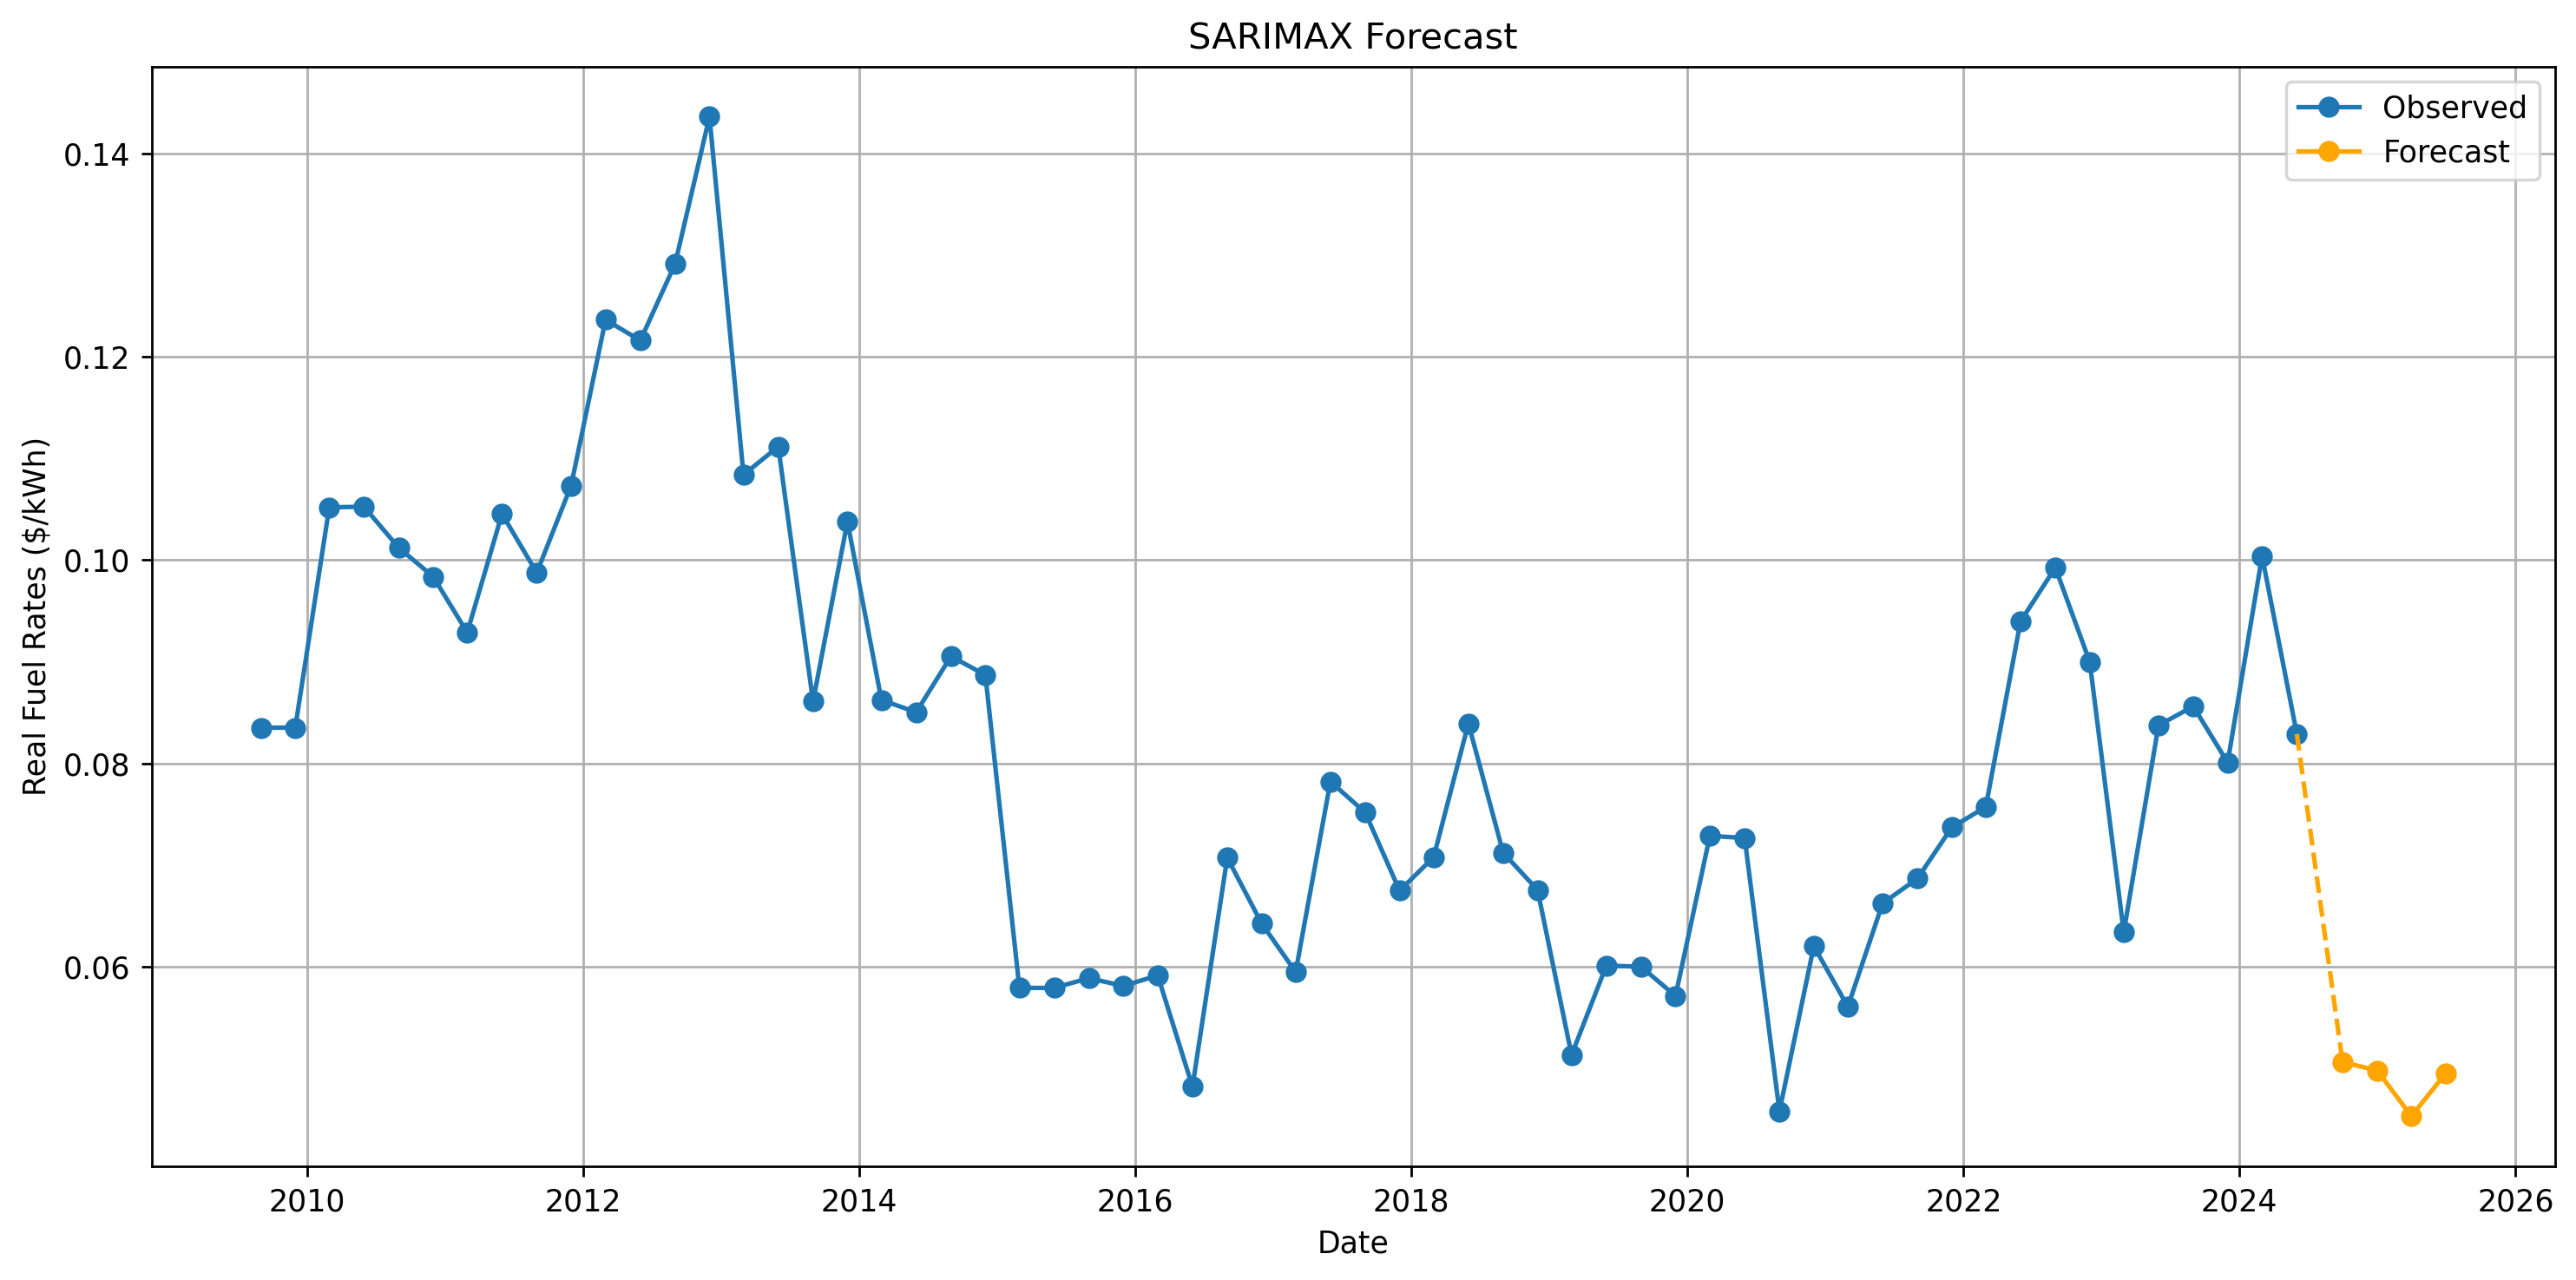

/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/101949648.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_series[i] = (forecast_series[i]*last_cpi)/100
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/101949648.py:107: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  forecast_series[i] = (forecast_series[i]*last_cpi)/100
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/101949648.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFram

Nominal Forecast Values
2024-09-30    0.083863
2024-12-31    0.082457
2025-03-31    0.075039
2025-06-30    0.082019
Freq: QE-DEC, Name: predicted_mean, dtype: float64
Nominal Effective Rates Forecast
0.2243332218077085
0.2229270682282476
0.21550911924672017
0.22248907511045213


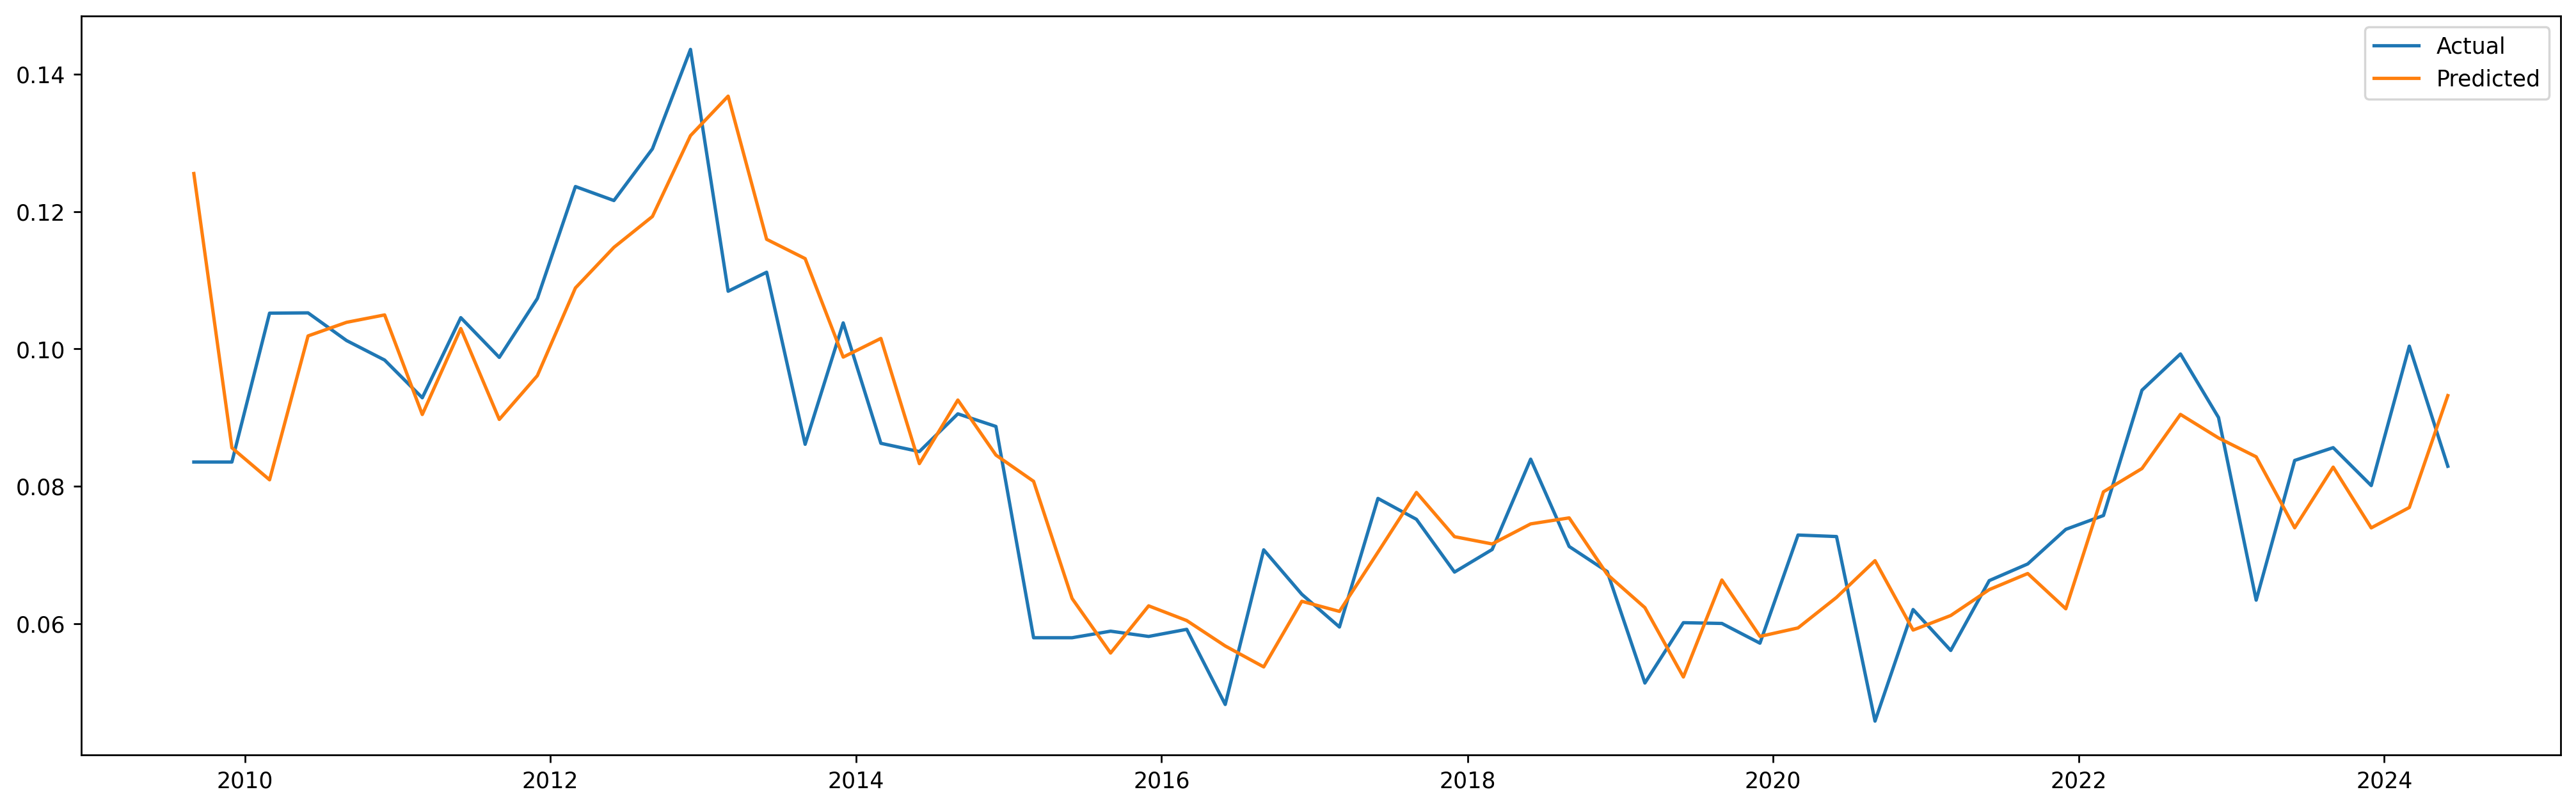

In [1028]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define exogenous variables
exog = pd.DataFrame({
    'net_gen': data['net_gen'],
    'nat_gas_prices': data['nat_gas_real'],
    'crude_prod': data['crude_oil_prod'], 
    'crude_prices_real': data['crude_prices_real'],
    'coal': data['coal'],
    'wind': data['wnd'],
    'oil': data['oil']
})

# Fit the SARIMAX model using the scaled exogenous variables
model_sarimax = SARIMAX(
    endog=data['fpp_real'],
    exog=exog,
    order=(0, 1, 1),
    seasonal_order=(2, 0, 1, 4),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model_sarimax.fit()

#plot diagnostics
results.plot_diagnostics(figsize=(10, 6))
plt.suptitle('Diagnostics', fontsize=16)
plt.show()

# Generate in-sample predictions
predicted = results.predict(start=0, end=len(data)-1, exog=exog)

# Prepare future exogenous data
future_dates = pd.date_range(start=data.index[-1], periods=5, freq='Q')[1:]

# Assuming window_size and n_steps are defined
window_size = 4  # Example window size
n_steps = 4  # Number of steps to forecast

wind_adding = np.mean(data['wnd'].values[-window_size:])*4
net_gen_adding = np.mean(data['net_gen'].values[-window_size:])

future_exog = {
    'net_gen': (np.mean(data['net_gen'].values[-window_size:]*2)) * np.ones(n_steps),
    'nat_gas_prices': np.mean(data['nat_gas_real'].values[-window_size:]) * np.ones(n_steps),
    'crude_prod': np.mean(data['crude_oil_prod'].values[-window_size:]) * np.ones(n_steps),
    'crude_prices_real': np.mean(data['crude_prices_real'].values[-window_size:]) * np.ones(n_steps),
    'coal': np.mean(data['coal'].values[-window_size:]) * np.ones(n_steps),
    'wind': np.mean(data['wnd'].values[-window_size:]+net_gen_adding) * np.ones(n_steps),
    'oil': np.mean(data['oil'].values[-window_size:]) * np.ones(n_steps)

}
future_exog_df = pd.DataFrame(future_exog, index=future_dates)

# Forecasting with the SARIMAX model
forecast = results.get_forecast(steps=n_steps, exog=future_exog_df)
forecast_index = future_dates
forecast_series = forecast.predicted_mean

# Assign the forecast index to the forecast series
forecast_series.index = forecast_index

# Print the forecasted values
print("Forecasted Dates:")
print(forecast_index)

print("\nForecasted Values:")
print(forecast_series)

# Plotting the forecast
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(data.index, data['fpp_real'], label='Observed', marker='o')
ax.plot(forecast_index, forecast_series, color='orange', label='Forecast', marker='o')

# Extend observed data line to forecast start
observed_end = data.index[-1]
forecast_start = forecast_index[0]
observed_value_end = data['fpp_real'].iloc[-1]
forecast_value_start = forecast_series.iloc[0]
ax.plot([observed_end, forecast_start], [observed_value_end, forecast_value_start], color='orange', linestyle='--')

ax.set_title('SARIMAX Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Real Fuel Rates ($/kWh)')
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


#plot predicted and actual values
plt.figure(figsize=(20,6))
plt.plot(data['fpp_real'],label='Actual')
plt.plot(predicted,label='Predicted')
plt.legend()
utility_last = data["utility_real"].iloc[-1]

#adjust for CPi
last_cpi = data['CPI_new'].iloc[-1]
for i in range(len(forecast_series)):
    forecast_series[i] = (forecast_series[i]*last_cpi)/100

print("Nominal Forecast Values")
print(forecast_series)

print("Nominal Effective Rates Forecast")
utility_add = (utility_last*last_cpi)/100

for i in range(len(forecast_series)):
    print(forecast_series[i] + utility_add)



Prices are projected to be $0.22/kWh with renewable energy meeting a doubling in generation

This is a 60% decrease, from 0.08 -> 0.05

### What if a data center is built? (Let's say, 100 MW Data Center)

/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.61764D+00    |proj g|=  3.55033D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12      1     21      1     0     0   3.550D+07  -2.618D+00
  F =  -2.6176431490457777     

ABNORMAL_TERMINATION_IN_LNSRCH                              


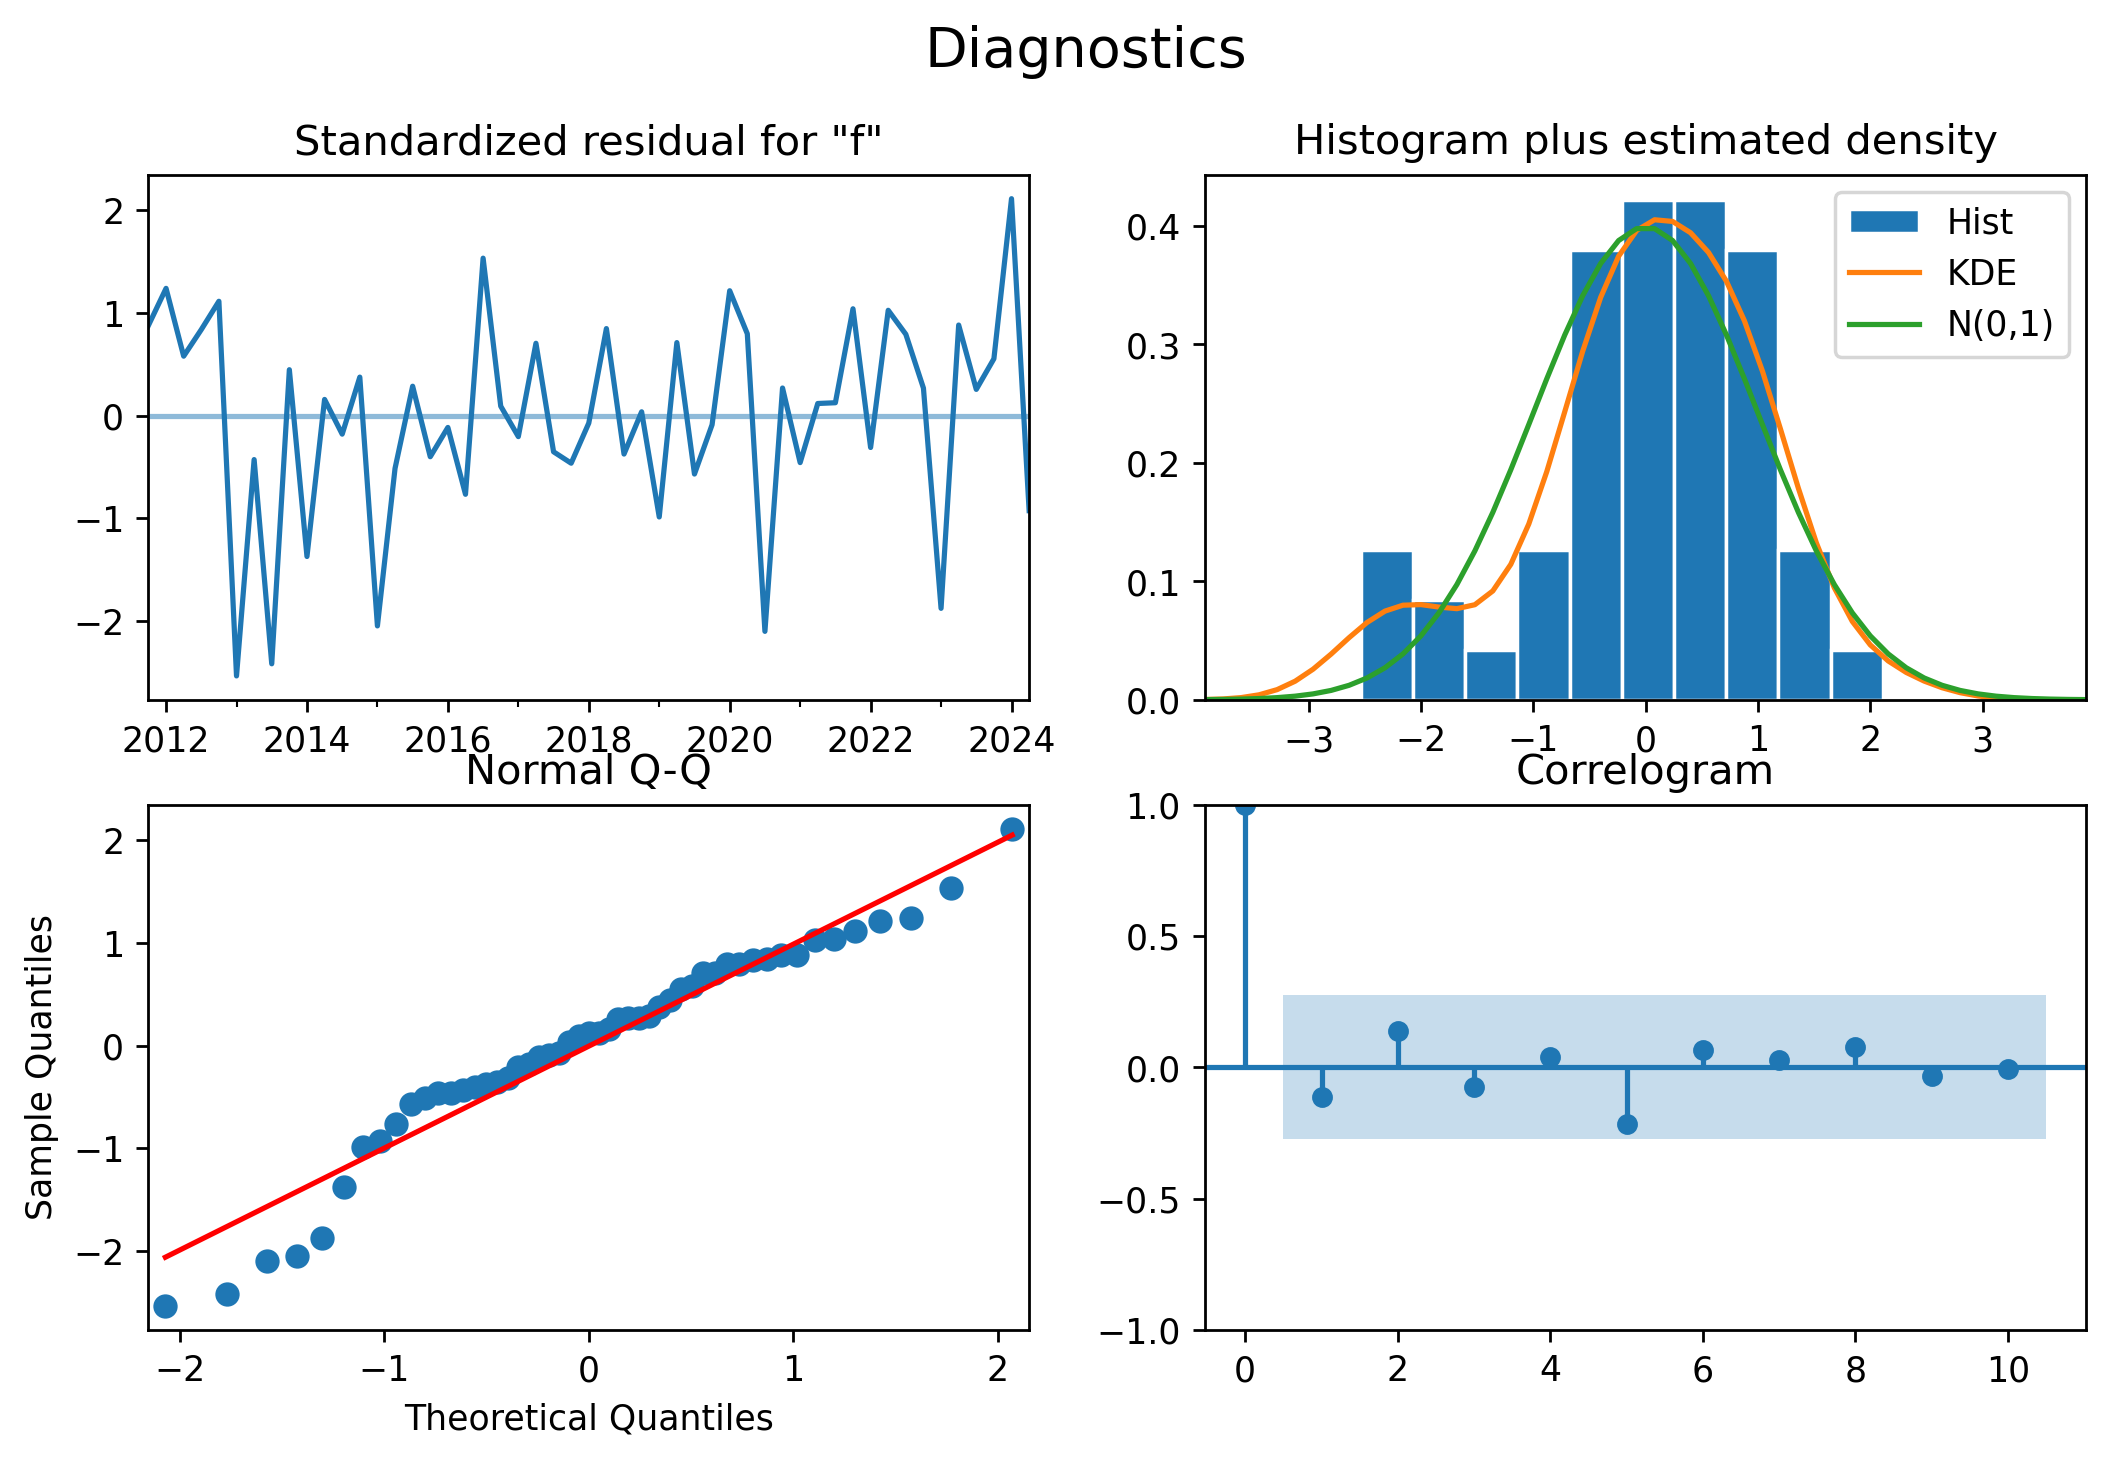

/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/2070885170.py:38: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start=data.index[-1], periods=5, freq='Q')[1:]


Forecasted Dates:
DatetimeIndex(['2024-09-30', '2024-12-31', '2025-03-31', '2025-06-30'], dtype='datetime64[ns]', freq='QE-DEC')

Forecasted Values:
2024-09-30    0.066073
2024-12-31    0.065224
2025-03-31    0.060745
2025-06-30    0.064959
Freq: QE-DEC, Name: predicted_mean, dtype: float64


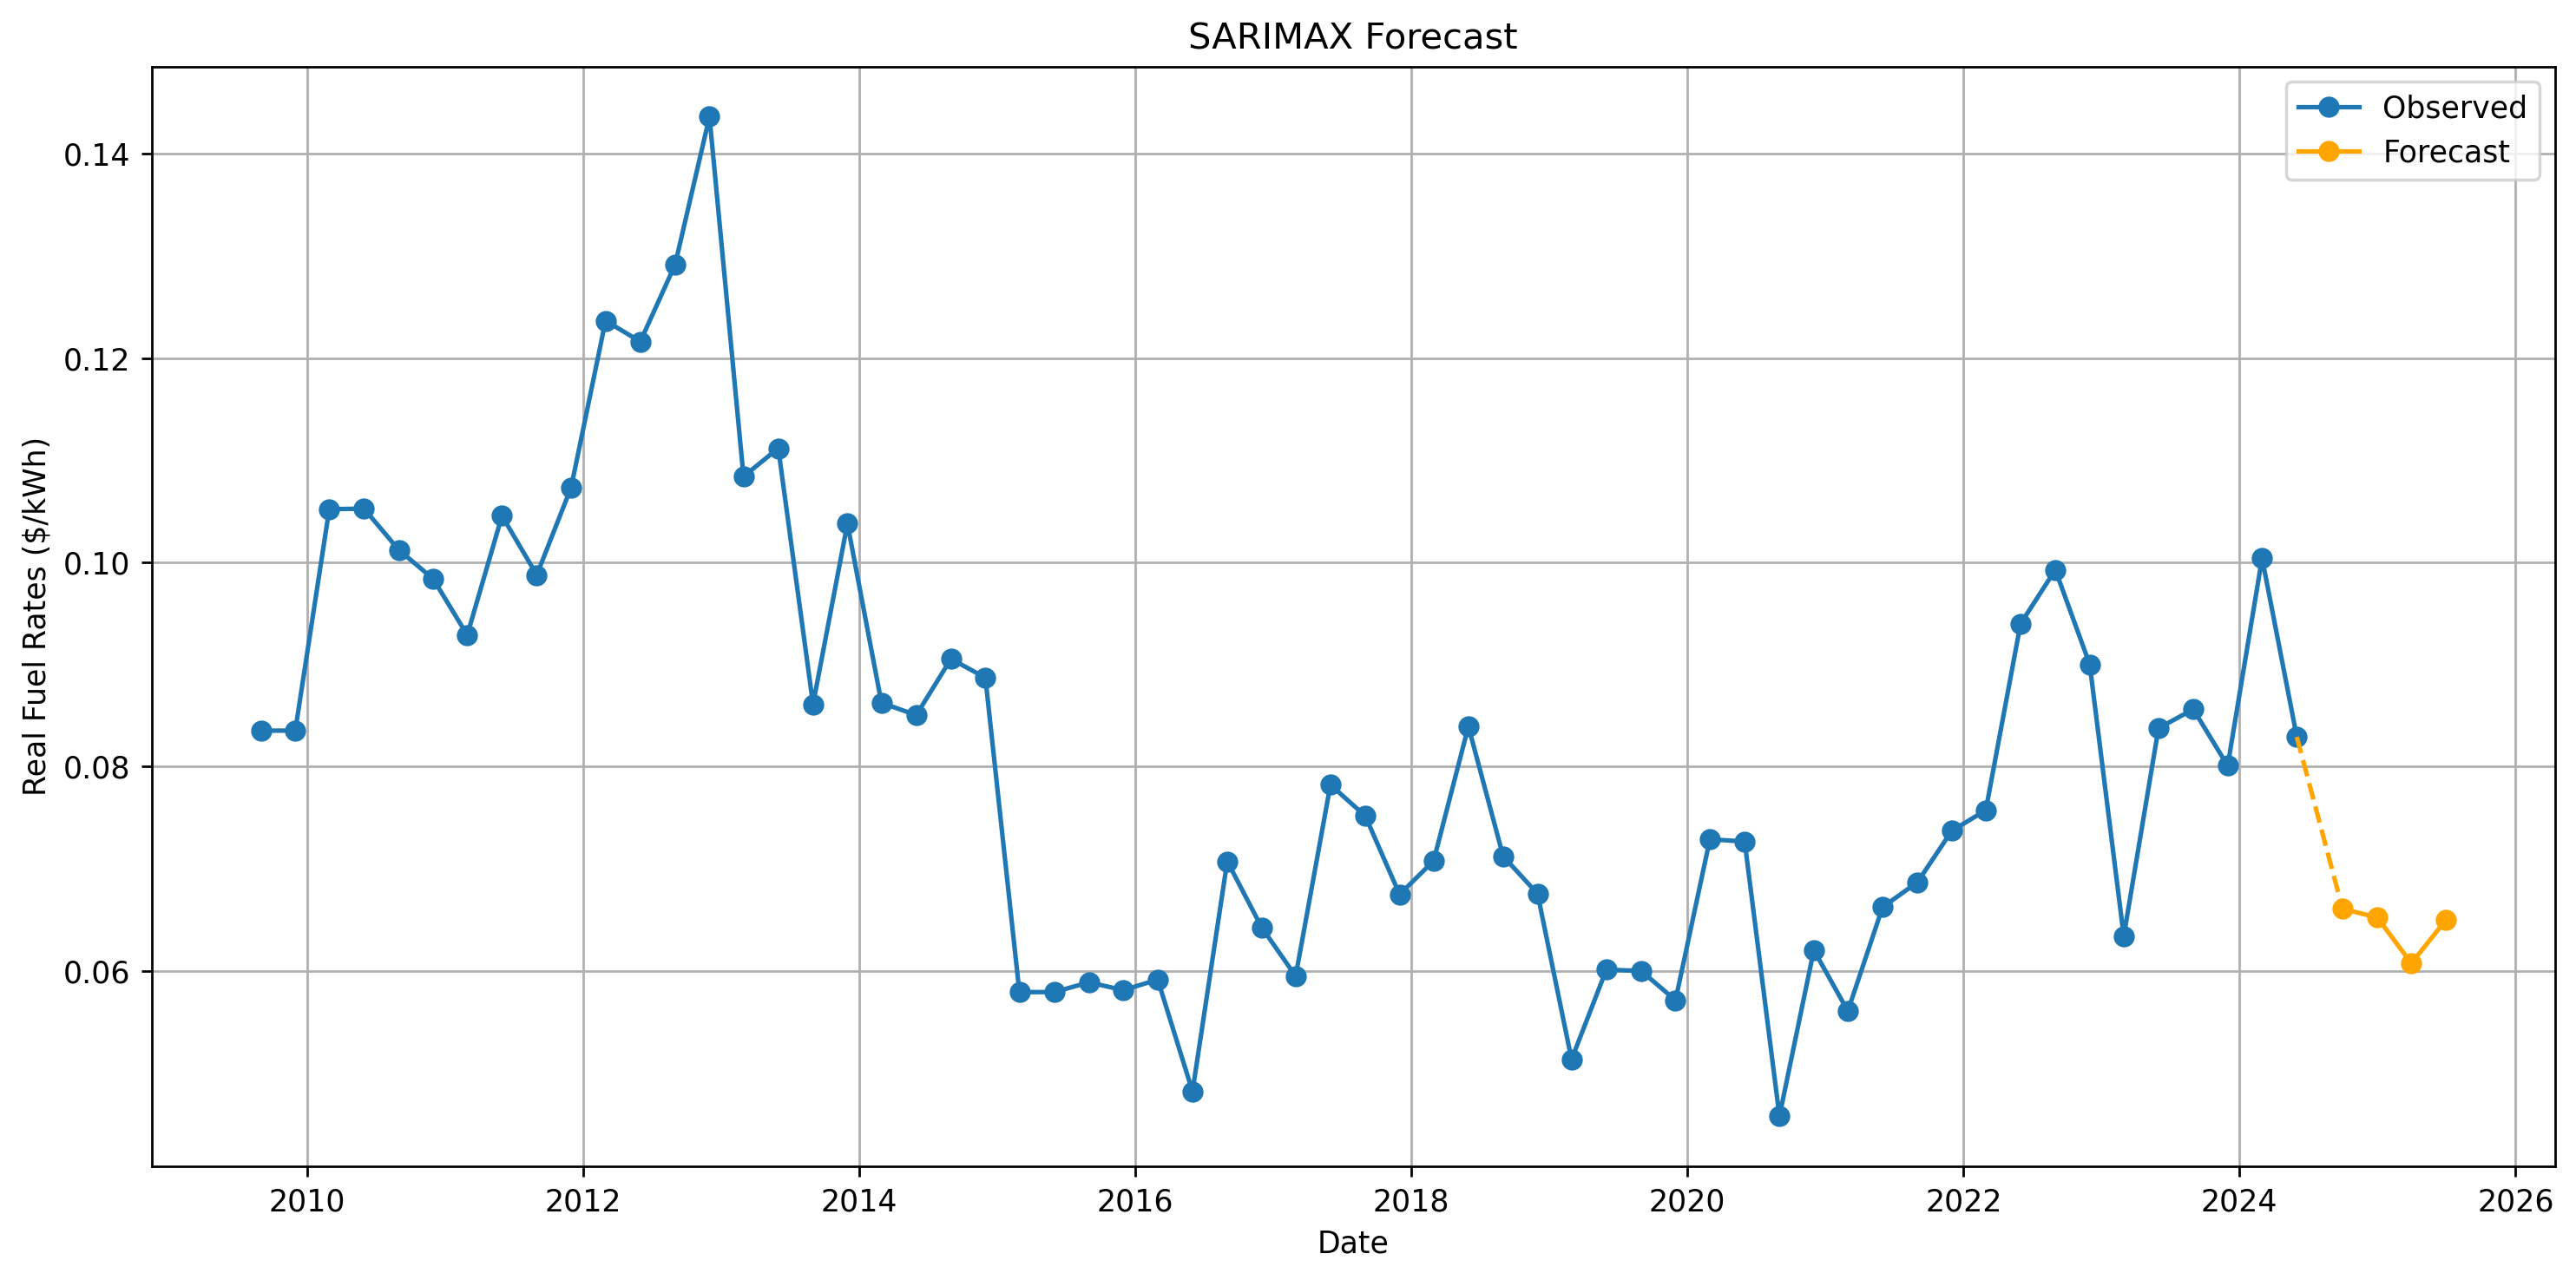

/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/2070885170.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_series[i] = (forecast_series[i]*last_cpi)/100
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/2070885170.py:104: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  forecast_series[i] = (forecast_series[i]*last_cpi)/100
/var/folders/nx/r0kn3t8x44x3r0j6v3nxvsp40000gn/T/ipykernel_23624/2070885170.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

Nominal Forecast Values
2024-09-30    0.109437
2024-12-31    0.108031
2025-03-31    0.100613
2025-06-30    0.107593
Freq: QE-DEC, Name: predicted_mean, dtype: float64
Nominal Effective Rates Forecast
0.24990744778115942
0.24850129420169853
0.24108334522017108
0.24806330108390306


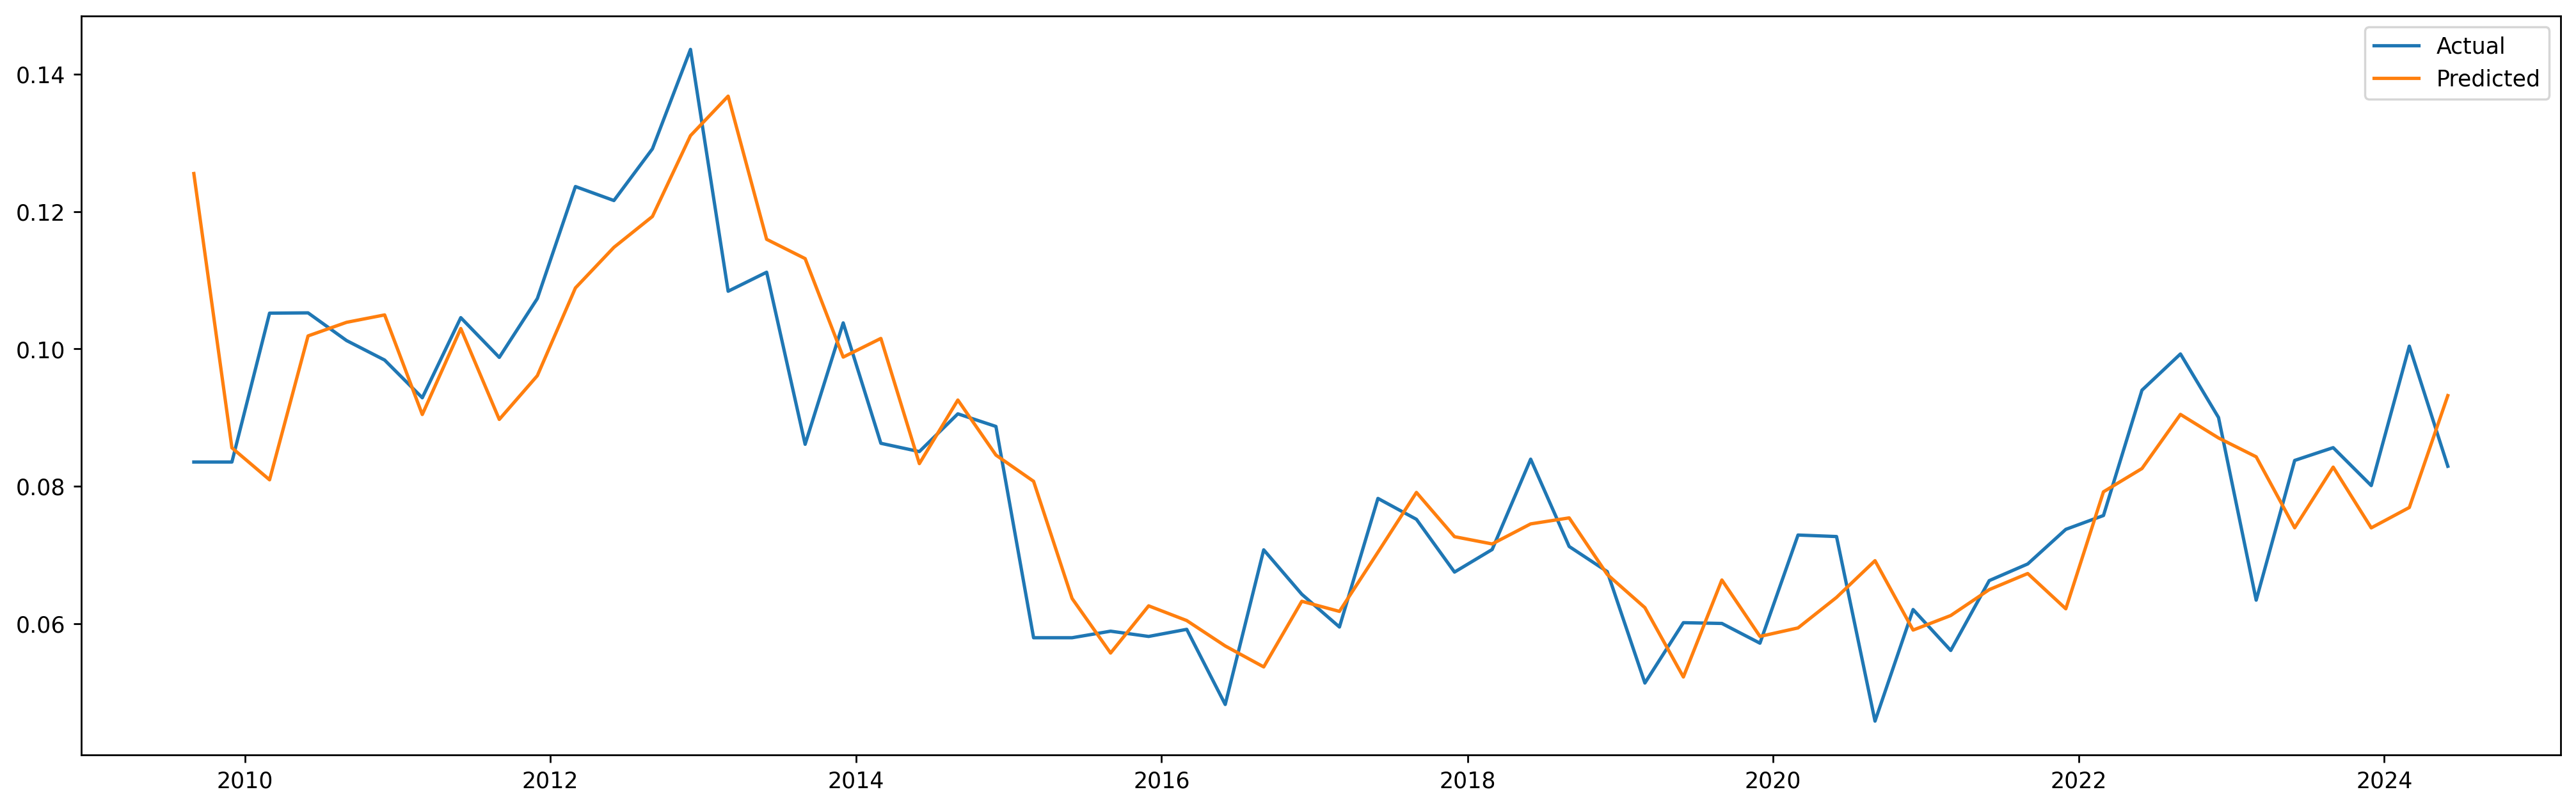

In [1029]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define exogenous variables
exog = pd.DataFrame({
    'net_gen': data['net_gen'],
    'nat_gas_prices': data['nat_gas_real'],
    'crude_prod': data['crude_oil_prod'], 
    'crude_prices_real': data['crude_prices_real'],
    'coal': data['coal'],
    'wind': data['wnd'],
    'oil': data['oil']
})

# Fit the SARIMAX model using the scaled exogenous variables
model_sarimax = SARIMAX(
    endog=data['fpp_real'],
    exog=exog,
    order=(0, 1, 1),
    seasonal_order=(2, 0, 1, 4),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model_sarimax.fit()

#plot diagnostics
results.plot_diagnostics(figsize=(10, 6))
plt.suptitle('Diagnostics', fontsize=16)
plt.show()

# Generate in-sample predictions
predicted = results.predict(start=0, end=len(data)-1, exog=exog)

# Prepare future exogenous data
future_dates = pd.date_range(start=data.index[-1], periods=5, freq='Q')[1:]

# Assuming window_size and n_steps are defined
window_size = 4  # Example window size
n_steps = 4  # Number of steps to forecast


future_exog = {
    'net_gen': (np.mean(data['net_gen'].values[-window_size:]*1.5)) * np.ones(n_steps),
    'nat_gas_prices': np.mean(data['nat_gas_real'].values[-window_size:]) * np.ones(n_steps),
    'crude_prod': np.mean(data['crude_oil_prod'].values[-window_size:]) * np.ones(n_steps),
    'crude_prices_real': np.mean(data['crude_prices_real'].values[-window_size:]) * np.ones(n_steps),
    'coal': np.mean(data['coal'].values[-window_size:]) * np.ones(n_steps),
    'wind': np.mean(data['wnd'].values[-window_size:]+net_gen_adding/2) * np.ones(n_steps),
    'oil': np.mean(data['oil'].values[-window_size:]+net_gen_adding/2) * np.ones(n_steps)

}
future_exog_df = pd.DataFrame(future_exog, index=future_dates)

# Forecasting with the SARIMAX model
forecast = results.get_forecast(steps=n_steps, exog=future_exog_df)
forecast_index = future_dates
forecast_series = forecast.predicted_mean

# Assign the forecast index to the forecast series
forecast_series.index = forecast_index

# Print the forecasted values
print("Forecasted Dates:")
print(forecast_index)

print("\nForecasted Values:")
print(forecast_series)

# Plotting the forecast
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(data.index, data['fpp_real'], label='Observed', marker='o')
ax.plot(forecast_index, forecast_series, color='orange', label='Forecast', marker='o')

# Extend observed data line to forecast start
observed_end = data.index[-1]
forecast_start = forecast_index[0]
observed_value_end = data['fpp_real'].iloc[-1]
forecast_value_start = forecast_series.iloc[0]
ax.plot([observed_end, forecast_start], [observed_value_end, forecast_value_start], color='orange', linestyle='--')

ax.set_title('SARIMAX Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Real Fuel Rates ($/kWh)')
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

#plot predicted and actual values
plt.figure(figsize=(20,6))
plt.plot(data['fpp_real'],label='Actual')
plt.plot(predicted,label='Predicted')
plt.legend()
utility_last = data["utility_real"].iloc[-1]

#adjust for CPi
last_cpi = data['CPI_new'].iloc[-1]
for i in range(len(forecast_series)):
    forecast_series[i] = (forecast_series[i]*last_cpi)/100

print("Nominal Forecast Values")
print(forecast_series)

print("Nominal Effective Rates Forecast")
utility_add = (utility_last*last_cpi)/100

for i in range(len(forecast_series)):
    print(forecast_series[i] + utility_add)



Prices are predicted to be $0.24/kWh with a data center (and doubling of generation) occuring

This is a 33% decrease in real fuel rates, 0.08 -> 0.06.